In [1]:
import os
import time
import math
import numpy as np
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import datetime
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
label_list = ['UNK',1,2,3,4,5]

In [4]:
df_train_l=pd.read_csv("../../yelp/assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("../../yelp/assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("../../yelp/assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("../../yelp/assigned/train_u.csv", index_col="Unnamed: 0")#.head(30000)
df_test_u=pd.read_csv("../../yelp/assigned/test_u.csv", index_col="Unnamed: 0")#.head(5000)
df_all = pd.concat([df_train_l, df_test_l, df_u, df_train_u, df_test_u])

In [5]:
train_l =  list(df_train_l.to_records(index=False))
test_l = list(df_test_l.to_records(index=False))
u_list = list(df_u.to_records(index=False))
test_u = list(df_test_u.to_records(index=False))
train_u = list(df_train_u.to_records(index=False))
data_all = list(df_all["0"])

In [6]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 30
batch_size = 24

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6 #5e-6?
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 50
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator"

In [7]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.

In [10]:
#Load the examples
labeled_examples = train_l
unlabeled_examples = u_list
test_examples = test_l

In [11]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [12]:
#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [13]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

In [14]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [15]:
#!pip install boto3

In [16]:
#OPTAGAN
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse

import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np

from torch.autograd import Variable
from modules.gan import Generator, Critic

import copy
import math
import glob
import os
import pickle
import random

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
from func import XLNetLMHeadModel, XLNetTokenizer
from func import TransfoXLLMHeadModel, TransfoXLTokenizer
from func import BertForLatentConnector, BertTokenizer

from collections import defaultdict
from utils import (TextDataset_Split, TextDataset_2Tokenizers, BucketingDataLoader)
import pdb
from modules.utils import (calc_blue_parallel_func, pad_seq, rollout, rollout_test)
#from transformers.modeling_utils import top_k_top_p_filtering


MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop
ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer)
}

def load_and_cache_examples(args, tokenizer):
    if isinstance(tokenizer, list):
        dataset = TextDataset_2Tokenizers(tokenizer, args, args.train_data_file, block_size=args.block_size)
    else:
        dataset = TextDataset_Split(tokenizer, args, args.train_data_file, block_size=args.block_size)
    return dataset

def build_dataload_and_cache_examples(args, tokenizer):
    if isinstance(tokenizer, list):
        args.batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
        file_path=args.train_data_file
        dataloader = BucketingDataLoader(file_path, args.batch_size, args.max_seq_length, tokenizer, args, bucket=100, shuffle=True)
        print(dataloader)
    else:
        pass 
    return dataloader

def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if args.cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, 1).fill_(1.0) #args.latent_size
    outputs.requires_grad_(False)
    if args.cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty

def train(epoch):
    model_encoder.eval()
    model_decoder.eval()
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    c_batches = 0
    c_loss_0 = 1
    g_loss_0 = 1
    for i, x in enumerate(train_loader):
        x = x[0]
        if args.cuda:
            x = x.cuda()
        # Generate noise
        B = args.per_gpu_train_batch_size
        noise = torch.from_numpy(np.random.normal(0, 1, (B,
                                 args.latent_size))).float()
        if args.cuda:
            noise = noise.cuda()
        # Get original text latent embeddings
        with torch.no_grad(): 
            pooled_hidden_fea = model_encoder(x, attention_mask=(x > 0).float())[1]
            mean, logvar = model_encoder.linear(pooled_hidden_fea).chunk(2, -1)
            z_real = mean.squeeze(1) 

        # Evaluate and get losses
        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + \
                 args.gp_lambda*grad_penalty

        fake_score = critic(generator(noise))
        g_loss = -torch.mean(fake_score)
        
        r_g = abs(((g_loss.item() - g_loss_0) / (g_loss_0 + 0.001))) 
        r_c = abs(((c_loss.item() - c_loss_0) / (c_loss_0 + 0.001))) 
        
        # Update critic or generator
        if ((2 + epoch) / epoch) * r_c > r_g:
            c_optimizer.zero_grad()
            c_batches += 1
            c_train_loss += c_loss.item()
            c_loss.backward()
            c_optimizer.step()
        else:
            g_optimizer.zero_grad()
            g_batches += 1
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()

        c_loss_0 = c_loss.item()
        g_loss_0 = g_loss.item()

        if args.interval > 0 and i % args.interval == 0:
            logger.info('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, args.batch_size*i, len(train_loader.dataset),
                100.*(args.batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
            test_noise = torch.Tensor(np.random.normal(0, 1, (1, args.latent_size))).to(args.device)
            test_new_z = generator(test_noise).data
            # create new sent
            test_z = rollout_test(model_decoder, test_new_z, tokenizer_decoder, args.max_seq_length, 1, 0, 1)
            logger.info("Text: {}".format(test_z))

    c_train_loss /= c_batches + 1
    g_train_loss /= g_batches + 1
    logger.info('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f} | Updates G: {} | Updates C: {}'.format(
        epoch, g_train_loss, c_train_loss, g_batches, c_batches
    ))
    return (g_train_loss, c_train_loss)

[nltk_data] Downloading package punkt to /home/harry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gp_lambda', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator and critic")
    parser.add_argument('--block_dim', type=int, default=100)
    parser.add_argument('--interval', type=int, default=10, help="Steps before logging output")
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
    
    # Optimus parameters
    parser.add_argument("--train_data_file", default=None, type=str, required=True,
                        help="The input training data file (a text file).")
    parser.add_argument("--valid_data_file", default=None, type=str, required=True,
                        help="The input validation data file (a text file).")
    parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
                        help="The directory where checkpoints are saved.")
    parser.add_argument('--generator_dir', default=None, type=str, help="Directory where GAN models are saved")
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")
    parser.add_argument("--dataset", default='Snli', type=str, help="The dataset.")    
    parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
    ## Encoder options
    parser.add_argument("--encoder_model_type", default="bert", type=str,
                        help="The encoder model architecture to be fine-tuned.")
    parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The encoder model checkpoint for weights initialization.")
    parser.add_argument("--encoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--encoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    ## Decoder options
    parser.add_argument("--decoder_model_type", default="gpt2", type=str,
                        help="The decoder model architecture to be fine-tuned.")
    parser.add_argument("--decoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The decoder model checkpoint for weights initialization.")
    parser.add_argument("--decoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--decoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    parser.add_argument("--per_gpu_train_batch_size", default=1, type=int,
                        help="Batch size per GPU/CPU for training.")
    parser.add_argument("--max_seq_length", default=512, type=int,
                        help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")

    ## Variational auto-encoder(check this)
    parser.add_argument("--prompt", type=str, default="")
    parser.add_argument("--padding_text", type=str, default="")
    parser.add_argument("--length", type=int, default=20)
    parser.add_argument("--block_size", default=-1, type=int,
                        help="Optional input sequence length after tokenization."
                             "The training dataset will be truncated in block of this size for training."
                             "Default to the model max input length for single sentence inputs (take into account special tokens).")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--use_philly", action='store_true',
                        help="Use Philly for computing.")
    parser.add_argument('--gloabl_step_eval', type=int, default=661,
                        help="Evaluate the results at the given global step")
    # Reinforcement learning parameters
    parser.add_argument('--finetune_decoder', type=bool, default=True)
    parser.add_argument('--epochs_rl', type=int, default=1000)
    parser.add_argument('--batch_size_rl', type=int, default=32)
    parser.add_argument('--lr_rl', type=float, default=1e-6)


    # Load a trained Encoder model and vocabulary that you have fine-tuned
    args = parser.parse_args("--dataset EMNLP \
    --checkpoint_dir=output_dir_yelp_768_1 \
    --output_dir=output_dir_yelp_768_1 \
    --encoder_model_type=bert \
    --encoder_model_name_or_path=bert-base-cased \
    --decoder_model_type=gpt2 \
    --decoder_model_name_or_path=gpt2 \
    --train_data_file=../../yelp/unlabelled/train.txt \
    --valid_data_file=../../yelp/unlabelled/test.txt \
    --per_gpu_train_batch_size 12 \
    --block_size 100 \
    --max_seq_length 24 \
    --gloabl_step_eval 508523 \
    --latent_size 768 \
    --block_dim 100 \
    --n_layers 10 \
    --interval 50 \
    --epochs 200 \
    --finetune_decoder True \
    --lr_rl 1e-6 \
    --epochs_rl 100 \
    --batch_size_rl 32".split())
    
    print(args)

    global_step = args.gloabl_step_eval

    torch.backends.cudnn.deterministic = True
    #args.device = torch.device("cuda" if args.cuda else "cpu")
    #args.n_gpu = torch.cuda.device_count()
    args.device = torch.device("cuda:0")
    args.n_gpu=1
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)       
    
    args.encoder_model_type = args.encoder_model_type.lower()
    args.decoder_model_type = args.decoder_model_type.lower()

    output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
    output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step)) 
    checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
    model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

    model_encoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

    # Load a trained Decoder model and vocabulary that you have fine-tuned
    decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
    model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
    model_decoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

    # Chunyuan: Add Padding token to GPT2
    special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
    num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
    logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
    model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
    assert tokenizer_decoder.pad_token == '<PAD>'

    train_loader = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder]) 
    generator = Generator(args.n_layers, args.block_dim,args.latent_size)
    critic = Critic(args.n_layers, args.block_dim,args.latent_size)

    if args.generator_dir!=None:
        logger.info("Loading generator and critic")
        generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        critic.load_state_dict(torch.load(args.generator_dir+'/critic_'+str(args.gloabl_step_eval)+'.th'))

    g_optimizer = optim.Adam(generator.parameters(), lr=args.lr, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=args.lr, betas=(0.5, 0.999))
    
    if args.cuda:
        generator = generator.cuda()
        critic = critic.cuda()
    
    logger.info('G Parameters:{}'.format(sum([p.numel() for p in generator.parameters() if \
                                p.requires_grad])))
    logger.info('C Parameters:{}'.format(sum([p.numel() for p in critic.parameters() if \
                                p.requires_grad])))
    
    device = args.device
    
    best_bleu = 0
    reference = list()
    with(open(args.valid_data_file,"r")) as valid:
        for sents in valid:
            reference.append(sents.replace("\n", ""))
            
    for epoch in range(1, args.epochs + 1):
        
        #Insert GAN-BERT Code Here
        
        print("Train classification discriminator")
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, args.epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        tr_g_loss = 0
        tr_d_loss = 0

        # Put the model into training mode.
        transformer.train() 
        #generator.train()
        discriminator.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every print_each_n_step batches.
            if step % print_each_n_step == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_label_mask = batch[3].to(device)

            real_batch_size = b_input_ids.shape[0]

            # Encode real data in the Transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            #print("  Number of real sentences (labelled and unlabelled): {}".format(len(hidden_states)))
            
            # Generate fake data that should have the same distribution of the ones
            # encoded by the transformer. 
            # First noisy input are used in input to the Generator
            fixed_noise = torch.Tensor(np.random.normal(0, 1, (real_batch_size, args.latent_size))).to(args.device)
            test_z_gb = generator(fixed_noise).data
            fake_sentences = rollout_test(model_decoder, test_z_gb, tokenizer_decoder, args.max_seq_length, real_batch_size, 0, 1)
            #print("  Number of generated sentences: {}".format(len(fake_sentences)))

            b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
            model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
            hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
            #hidden_states_fake = model_outputs_fake[-1]

            #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
            # Gnerate Fake data
            #gen_rep = generator(noise)
            #print("Length of generator output {}".format(len(gen_rep)))
            #print("Length of single generator output {}".format(len(gen_rep[0])))

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
            # Then, we select the output of the disciminator
            features, logits, probs = discriminator(disciminator_input)

            # Finally, we separate the discriminator's output for the real and fake
            # data
            features_list = torch.split(features, real_batch_size)
            D_real_features = features_list[0]
            D_fake_features = features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #---------------------------------
            #  LOSS evaluation
            #---------------------------------
            # Generator's LOSS estimation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Disciminator's LOSS estimation
            logits = D_real_logits[:,0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            # The discriminator provides an output for labeled and unlabeled real data
            # so the loss evaluated for unlabeled data is ignored (masked)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            # It may be the case that a batch does not contain labeled examples, 
            # so the "supervised loss" in this case is not evaluated
            if labeled_example_count == 0:
              D_L_Supervised = 0
            else:
              D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            #---------------------------------
            #  OPTIMIZATION
            #---------------------------------
            # Avoid gradient accumulation
            #gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            # Calculate weigth updates
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward() 

            # Apply modifications
            #gen_optimizer.step()
            dis_optimizer.step()

            # A detail log of the individual losses
            #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
            #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
            #             g_loss_d, g_feat_reg))

            # Save the losses to print them later
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

            # Update the learning rate with the scheduler
            if apply_scheduler:
              scheduler_d.step()
              #scheduler_g.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)             

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #     TEST ON THE EVALUATION DATASET
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our test set.
        print("")
        print("Running Test...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        transformer.eval() #maybe redundant
        discriminator.eval()
        #generator.eval()

        # Tracking variables 
        total_test_accuracy = 0

        total_test_loss = 0
        nb_test_steps = 0

        all_preds = []
        all_labels_ids = []

        #loss
        nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
                hidden_states = model_outputs.last_hidden_state[:,0,:] 
                #hidden_states = model_outputs[-1]
                _, logits, probs = discriminator(hidden_states)
                ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
                filtered_logits = logits[:,0:-1]
                # Accumulate the test loss.
                total_test_loss += nll_loss(filtered_logits, b_labels)

            # Accumulate the predictions and the input labels
            _, preds = torch.max(filtered_logits, 1)
            all_preds += preds.detach().cpu()
            all_labels_ids += b_labels.detach().cpu()

        # Report the final accuracy for this validation run.
        all_preds = torch.stack(all_preds).numpy()
        all_labels_ids = torch.stack(all_labels_ids).numpy()
        test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
        print("  Accuracy: {0:.3f}".format(test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_loss = avg_test_loss.item()

        # Measure how long the validation run took.
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.3f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss generator': avg_train_loss_g,
                'Training Loss discriminator': avg_train_loss_d,
                'Valid. Loss': avg_test_loss,
                'Valid. Accur.': test_accuracy,
                'Training Time': training_time,
                'Test Time': test_time
            }
        )

        accuracy_array.append(test_accuracy)
        
        #OPTAGAN Code
        
        g_loss, c_loss = train(epoch)

        data_test = list()
        for i in range(2):
            test_noise = torch.Tensor(np.random.normal(0, 1, (250, args.latent_size))).to(args.device)
            test_z = generator(test_noise).data
            print(test_z)
            new_sent = rollout_test(model_decoder, test_z, tokenizer_decoder, args.max_seq_length, 250, 0, 1)
            data_test.extend(new_sent)

        p_reference = random.sample(reference, 500)
        bleu = calc_blue_parallel_func(p_reference, data_test, 2, 500)
        b_bleu = calc_blue_parallel_func(data_test, p_reference, 2, 500)
        logger.info("Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}".format(bleu, b_bleu))
        
        print(bleu+b_bleu)
        if (bleu+b_bleu) > best_bleu:
            best_bleu = bleu + b_bleu
            logger.info('* Saving. Best Score:{:0.3f} | Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}'.format(best_bleu, bleu, b_bleu))
            torch.save(generator.state_dict(), args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th')
            torch.save(critic.state_dict(), args.output_dir+'/critic_'+str(args.gloabl_step_eval)+'.th')
            
        

    if args.finetune_decoder: 
        logger.info("Loading generator")
        generator.load_state_dict(torch.load(args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        
        model_decoder.train()
        generator.eval()
        dec_optimizer = optim.Adam(model_decoder.parameters(), lr=1e-4, betas=(0.5, 0.999))
        value_loss = nn.L1Loss()
        B = args.batch_size_rl
        total_scores = 0
        total_entropy = 0
        total_values = 0
        total_v_loss = 0
        for epoch_ in range(args.epochs_rl):
            if epoch_ == 200:
                # Finetune decoder after training of value head
                dec_optimizer = optim.Adam(model_decoder.parameters(), lr=args.lr_rl, betas=(0.5, 0.999))
            noise = torch.from_numpy(np.random.normal(0, 1, (B, args.latent_size))).float()
            noise = noise.to(args.device)
            z_fake = generator(noise)            
            sents, logprobs, values, entropy = rollout(model_decoder, z_fake, tokenizer_decoder, args.max_seq_length, B, 1)
            p_reference = random.sample(reference, 500)

            blue = []
            for i in sents:
                blue.append(calc_blue_parallel_func(p_reference, [i], 1, 0))

            values = torch.stack(values, dim=1)
            logprobs = torch.stack(logprobs, dim=1)
            entropy = torch.stack(entropy, dim=1)

            # Get tokens and mask of batch
            toks_gpt = [([50258] + tokenizer_decoder.encode(j) + [50259]) for j in sents]
            toks_gpt, mask = pad_seq(toks_gpt, tokenizer_decoder.encode("<PAD>")[0], values.size(1)+1)
            toks_gpt = torch.tensor(toks_gpt).to(args.device)
            mask = torch.tensor(mask).to(args.device)
              
            values = values * mask[:,1:]
            logprobs = logprobs * mask[:,1:]
            entropy = entropy * mask[:,1:]
            scores = torch.tensor(blue).to(args.device)
            # Get value loss
            v_loss = value_loss(torch.sum(values, dim=1), scores) 
              
            if epoch_ >= 200:
                R = 0
                rewards = []

                # Discount future rewards back to the present using gamma
                for j in range(len(values.tolist())):
                    R = 0
                    batch_rewards = []
                    for r in reversed(values.tolist()[j]):
                        R = r + 0.99 * R
                        batch_rewards.insert(0,R)
                    rewards.append(batch_rewards)

                # Penalizing low entropy states
                rewards = torch.FloatTensor(rewards).to(args.device)
                rewards = rewards + torch.log(torch.clamp(entropy,0.2,1))
                # Calculate loss
                d_loss = torch.sum(torch.mul(logprobs, rewards.detach()).mul(-1))
            else:
                d_loss = torch.tensor(0)

            # Backpropagate losses
            loss = v_loss + d_loss              
            dec_optimizer.zero_grad()              
            loss.backward()
            dec_optimizer.step()

            total_scores += torch.mean(scores).item()
            total_values += torch.mean(torch.sum(values,-1)).item()
            total_v_loss += v_loss.item()
            total_entropy += torch.mean(torch.mean(entropy,dim=1)).item()
            if (epoch_ % args.interval) == 0:
                logger.info("Epoch {}/{} | Value Loss:{} | Mean values:{} | Mean BLEU scores:{} | Mean Entropy: {}".format(epoch_, 
                args.epochs_rl, total_v_loss/args.interval, total_values/args.interval, total_scores/args.interval, total_entropy/args.interval))
                total_scores = 0
                total_values = 0
                total_v_loss = 0
                total_entropy = 0
        logger.info("Saving decoder")
        output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
        if not os.path.exists(output_decoder_dir):
            os.makedirs(output_decoder_dir)
        model_decoder.save_pretrained(output_decoder_dir)
        torch.save(args, os.path.join(output_decoder_dir, 'training_encoder_args.bin'))   

06/17/2022 09:35:51 - INFO - func.configuration_utils -   loading configuration file output_dir_yelp_768_1/checkpoint-encoder-508523/config.json
06/17/2022 09:35:51 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

06/17/2022 09:35:51 - INFO - func.modeling_utils -   loading weights file output_dir_yelp_768_1/checkpoint-encoder-508523/pytorch_model.bin


Namespace(batch_size_rl=32, block_dim=100, block_size=100, checkpoint_dir='output_dir_yelp_768_1', cuda=True, dataset='EMNLP', decoder_config_name='', decoder_model_name_or_path='gpt2', decoder_model_type='gpt2', decoder_tokenizer_name='', do_lower_case=False, encoder_config_name='', encoder_model_name_or_path='bert-base-cased', encoder_model_type='bert', encoder_tokenizer_name='', epochs=200, epochs_rl=100, finetune_decoder=True, generator_dir=None, gloabl_step_eval=508523, gp_lambda=10, interval=50, latent_size=768, length=20, lr=0.0001, lr_rl=1e-06, max_seq_length=24, n_layers=10, output_dir='output_dir_yelp_768_1', padding_text='', per_gpu_train_batch_size=12, prompt='', seed=0, train_data_file='../../yelp/unlabelled/train.txt', use_philly=False, valid_data_file='../../yelp/unlabelled/test.txt')


06/17/2022 09:35:54 - INFO - func.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/harry/.cache/torch/pytorch_transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
06/17/2022 09:35:54 - INFO - func.configuration_utils -   loading configuration file output_dir_yelp_768_1/checkpoint-decoder-508523/config.json
06/17/2022 09:35:54 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,

Train classification discriminator

======== Epoch 1 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:03.
  Batch    20  of    230.    Elapsed: 0:00:07.
  Batch    30  of    230.    Elapsed: 0:00:10.
  Batch    40  of    230.    Elapsed: 0:00:13.
  Batch    50  of    230.    Elapsed: 0:00:17.
  Batch    60  of    230.    Elapsed: 0:00:20.
  Batch    70  of    230.    Elapsed: 0:00:23.
  Batch    80  of    230.    Elapsed: 0:00:26.
  Batch    90  of    230.    Elapsed: 0:00:30.
  Batch   100  of    230.    Elapsed: 0:00:34.
  Batch   110  of    230.    Elapsed: 0:00:37.
  Batch   120  of    230.    Elapsed: 0:00:41.
  Batch   130  of    230.    Elapsed: 0:00:44.
  Batch   140  of    230.    Elapsed: 0:00:46.
  Batch   150  of    230.    Elapsed: 0:00:50.
  Batch   160  of    230.    Elapsed: 0:00:52.
  Batch   170  of    230.    Elapsed: 0:00:55.
  Batch   180  of    230.    Elapsed: 0:00:58.
  Batch   190  of    230.    Elapsed: 0:01:01.
  Batch   200  of    230.  

06/17/2022 09:38:10 - INFO - __main__ -   Epoch: 1 | Batch: 0/114051 (0%) | G Loss: 0.243110 | C Loss: 1.832317
06/17/2022 09:38:10 - INFO - __main__ -   Text: ['']


  Accuracy: 0.450
  Test Loss: 1.304
  Test took: 0:00:00


06/17/2022 09:38:12 - INFO - __main__ -   Epoch: 1 | Batch: 600/114051 (1%) | G Loss: 132.443451 | C Loss: -86.453445
06/17/2022 09:38:12 - INFO - __main__ -   Text: ['<PAD>']
06/17/2022 09:38:13 - INFO - __main__ -   Epoch: 1 | Batch: 1200/114051 (1%) | G Loss: 84.650375 | C Loss: -55.398285
06/17/2022 09:38:13 - INFO - __main__ -   Text: ['']
06/17/2022 09:38:15 - INFO - __main__ -   Epoch: 1 | Batch: 1800/114051 (2%) | G Loss: 78.670975 | C Loss: -56.602558
06/17/2022 09:38:15 - INFO - __main__ -   Text: ['']
06/17/2022 09:38:16 - INFO - __main__ -   Epoch: 1 | Batch: 2400/114051 (2%) | G Loss: 70.345673 | C Loss: -52.006317
06/17/2022 09:38:16 - INFO - __main__ -   Text: ['Power Elon Gre Ireland']
06/17/2022 09:38:18 - INFO - __main__ -   Epoch: 1 | Batch: 3000/114051 (3%) | G Loss: 56.679375 | C Loss: -39.384266
06/17/2022 09:38:18 - INFO - __main__ -   Text: ['']
06/17/2022 09:38:19 - INFO - __main__ -   Epoch: 1 | Batch: 3600/114051 (3%) | G Loss: 55.010735 | C Loss: -40.135582


06/17/2022 09:39:09 - INFO - __main__ -   Epoch: 1 | Batch: 22200/114051 (19%) | G Loss: 4.940506 | C Loss: -4.755561
06/17/2022 09:39:09 - INFO - __main__ -   Text: ['Classes go on cruise with millions of people, tap kingies go on fer barge advising get distracted for now then']
06/17/2022 09:39:11 - INFO - __main__ -   Epoch: 1 | Batch: 22800/114051 (20%) | G Loss: 5.787702 | C Loss: -5.313808
06/17/2022 09:39:11 - INFO - __main__ -   Text: ["Dutch's keeping, and the new market is set to do he has to go back to Oldtown to help English"]
06/17/2022 09:39:12 - INFO - __main__ -   Epoch: 1 | Batch: 23400/114051 (21%) | G Loss: 5.315601 | C Loss: -4.644351
06/17/2022 09:39:13 - INFO - __main__ -   Text: ['Dave has been a big GO fan and a huge dog to go and we have the greatest ultra Leo <BOS> Burger']
06/17/2022 09:39:14 - INFO - __main__ -   Epoch: 1 | Batch: 24000/114051 (21%) | G Loss: 5.294815 | C Loss: -4.773363
06/17/2022 09:39:14 - INFO - __main__ -   Text: ['Traders say " \'The P

06/17/2022 09:40:00 - INFO - __main__ -   Epoch: 1 | Batch: 40800/114051 (36%) | G Loss: 6.225843 | C Loss: -5.438798
06/17/2022 09:40:00 - INFO - __main__ -   Text: ['PRAD sells this crap at 71% it rides once it happens to talk or talk, etc.']
06/17/2022 09:40:02 - INFO - __main__ -   Epoch: 1 | Batch: 41400/114051 (36%) | G Loss: 5.934054 | C Loss: -5.226900
06/17/2022 09:40:02 - INFO - __main__ -   Text: ['Rangees look like they\'ve got $$$ over $200 they or somebody should have $$$ in their inventory."']
06/17/2022 09:40:03 - INFO - __main__ -   Epoch: 1 | Batch: 42000/114051 (37%) | G Loss: 6.767119 | C Loss: -5.625384
06/17/2022 09:40:04 - INFO - __main__ -   Text: ['They now compete increasingly, and on Sundays and holidays-club models, and only have one bad oboe .']
06/17/2022 09:40:05 - INFO - __main__ -   Epoch: 1 | Batch: 42600/114051 (37%) | G Loss: 5.552989 | C Loss: -5.190665
06/17/2022 09:40:05 - INFO - __main__ -   Text: ['The coffee theypf cravings can be about € 9 to 

06/17/2022 09:40:51 - INFO - __main__ -   Text: ["It's one of the best weekends weekend nights, first night I get 50 to 100 tourists in, this is originally"]
06/17/2022 09:40:53 - INFO - __main__ -   Epoch: 1 | Batch: 60000/114051 (53%) | G Loss: 5.504256 | C Loss: -4.809897
06/17/2022 09:40:53 - INFO - __main__ -   Text: ['The show took on some good vibes as Bilongo and Mind1 took on some great puns with']
06/17/2022 09:40:55 - INFO - __main__ -   Epoch: 1 | Batch: 60600/114051 (53%) | G Loss: 5.401196 | C Loss: -5.061666
06/17/2022 09:40:55 - INFO - __main__ -   Text: ['A pop TV star from the coffee, bags bowl, and guy living percieve day after day, does the']
06/17/2022 09:40:56 - INFO - __main__ -   Epoch: 1 | Batch: 61200/114051 (54%) | G Loss: 5.939119 | C Loss: -5.387172
06/17/2022 09:40:57 - INFO - __main__ -   Text: ['This is because it takes off so many jobs, and heightens the rice to make it potato-size and']
06/17/2022 09:40:58 - INFO - __main__ -   Epoch: 1 | Batch: 61800/

06/17/2022 09:41:43 - INFO - __main__ -   Epoch: 1 | Batch: 78000/114051 (68%) | G Loss: 5.431479 | C Loss: -4.845537
06/17/2022 09:41:43 - INFO - __main__ -   Text: ['The guests of "Dramashan" will fold and rot of their own accord and swirl as well.']
06/17/2022 09:41:44 - INFO - __main__ -   Epoch: 1 | Batch: 78600/114051 (69%) | G Loss: 5.858734 | C Loss: -5.091000
06/17/2022 09:41:45 - INFO - __main__ -   Text: ['Jeremy, talks, trains, or sells things like toys, and she owns a new car with little pockets or']
06/17/2022 09:41:46 - INFO - __main__ -   Epoch: 1 | Batch: 79200/114051 (69%) | G Loss: 5.244837 | C Loss: -4.674438
06/17/2022 09:41:46 - INFO - __main__ -   Text: ["Dogs will have a poffy quality 'coke' with the crunch and two simple 'coke'"]
06/17/2022 09:41:48 - INFO - __main__ -   Epoch: 1 | Batch: 79800/114051 (70%) | G Loss: 5.243110 | C Loss: -4.505149
06/17/2022 09:41:48 - INFO - __main__ -   Text: ['But they can cook up this food with a good focus on honey - a popul

06/17/2022 09:42:34 - INFO - __main__ -   Text: ['Edward Watson\'s verse at night is "I\'m stumbling on a price paper, but my mum is tight and I']
06/17/2022 09:42:35 - INFO - __main__ -   Epoch: 1 | Batch: 97200/114051 (85%) | G Loss: 4.807583 | C Loss: -4.211915
06/17/2022 09:42:36 - INFO - __main__ -   Text: ['Newsstand, for now, is offering a £3 free tix (about 10 cents for one cup of']
06/17/2022 09:42:37 - INFO - __main__ -   Epoch: 1 | Batch: 97800/114051 (86%) | G Loss: 4.990434 | C Loss: -4.355827
06/17/2022 09:42:37 - INFO - __main__ -   Text: ['Grey-washed is an indoor reality TV game where an annoying boy huddles a golf ball, rhyming,']
06/17/2022 09:42:39 - INFO - __main__ -   Epoch: 1 | Batch: 98400/114051 (86%) | G Loss: 4.984555 | C Loss: -4.144828
06/17/2022 09:42:39 - INFO - __main__ -   Text: ['These products can be tough to forget to come with brilliant sounding products like bomb jackets, flared jackets, custom']
06/17/2022 09:42:40 - INFO - __main__ -   Epoch: 1 |

tensor([[-0.0849, -0.8528, -0.3170,  ...,  0.2917, -0.2932, -0.2743],
        [-0.2676, -0.0691, -0.2423,  ..., -0.0537, -0.1144,  0.5435],
        [-0.4024, -0.1376,  0.0693,  ...,  0.0177, -0.2716, -0.1278],
        ...,
        [-0.4084, -0.3697,  0.1760,  ...,  0.2898, -0.1346,  0.1504],
        [-0.7899,  0.0147,  0.3640,  ...,  0.1136, -0.0309, -0.0380],
        [-0.3193, -0.0510,  0.1205,  ..., -0.1194, -0.2216,  0.0566]],
       device='cuda:0')
tensor([[-0.1214, -0.1389,  0.1739,  ...,  0.1028,  0.4094,  0.2063],
        [-0.1716, -0.1072,  0.0346,  ..., -0.0610, -0.1863,  0.2006],
        [-0.1244, -0.1390,  0.2806,  ...,  0.0506, -0.2376,  0.5200],
        ...,
        [-0.4222, -0.3210,  0.2022,  ...,  0.1189, -0.2969, -0.0058],
        [-0.4427, -0.2671,  0.0785,  ..., -0.2590, -0.2497,  0.1682],
        [-0.2395, -0.2619,  0.0586,  ...,  0.0560, -0.0580,  0.0674]],
       device='cuda:0')


06/17/2022 09:43:32 - INFO - __main__ -   Bleu-2:0.434 | B-Bleu-2:0.408
06/17/2022 09:43:32 - INFO - __main__ -   * Saving. Best Score:0.841 | Bleu-2:0.434 | B-Bleu-2:0.408


0.8412673846612484
Train classification discriminator

======== Epoch 2 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:01.
  Batch 

06/17/2022 09:46:00 - INFO - __main__ -   Epoch: 2 | Batch: 0/114051 (0%) | G Loss: 4.763628 | C Loss: -4.090774


  Accuracy: 0.445
  Test Loss: 1.349
  Test took: 0:00:00


06/17/2022 09:46:00 - INFO - __main__ -   Text: ['Dunn also talks to Williams for money and owes him his twenty sequèces, and does commercials on Bachelor and']
06/17/2022 09:46:01 - INFO - __main__ -   Epoch: 2 | Batch: 600/114051 (1%) | G Loss: 4.505528 | C Loss: -3.478480
06/17/2022 09:46:01 - INFO - __main__ -   Text: ['At the Times, the two hot rods, which include nice cigars and huge butt-drop which can be purchased for']
06/17/2022 09:46:03 - INFO - __main__ -   Epoch: 2 | Batch: 1200/114051 (1%) | G Loss: 4.414882 | C Loss: -3.872054
06/17/2022 09:46:03 - INFO - __main__ -   Text: ['The company enjoys large profits from Sreta cheese surf fare is not much and now is very popular than Mir.']
06/17/2022 09:46:05 - INFO - __main__ -   Epoch: 2 | Batch: 1800/114051 (2%) | G Loss: 4.614681 | C Loss: -3.968842
06/17/2022 09:46:05 - INFO - __main__ -   Text: ["That's what happens for Seitan though, so we've got to think it's Keynote rather than"]
06/17/2022 09:46:06 - INFO - __main__ -

06/17/2022 09:46:51 - INFO - __main__ -   Text: ['The dining is reasonably cooked so as to make putting £2005 of it into a variety of trust presents unpleasant.']
06/17/2022 09:46:52 - INFO - __main__ -   Epoch: 2 | Batch: 19200/114051 (17%) | G Loss: 3.852879 | C Loss: -3.502807
06/17/2022 09:46:52 - INFO - __main__ -   Text: ["The mall's overall sales are not all that great, however, it is notorious for buying flowers, panoramas"]
06/17/2022 09:46:54 - INFO - __main__ -   Epoch: 2 | Batch: 19800/114051 (17%) | G Loss: 3.733314 | C Loss: -3.247861
06/17/2022 09:46:54 - INFO - __main__ -   Text: ['With so many tickets + the best cuisines watch is now available in India with this cake The best food store']
06/17/2022 09:46:56 - INFO - __main__ -   Epoch: 2 | Batch: 20400/114051 (18%) | G Loss: 4.083857 | C Loss: -3.709451
06/17/2022 09:46:56 - INFO - __main__ -   Text: ['Bottle Bazaar is a small shipper that serves sugary drinks as well as optional drinks but if you can afford']
06/17/2

06/17/2022 09:47:42 - INFO - __main__ -   Text: ["However, McDonald's is a solidly priced steak with popular ingredients, when you buy them year around the world."]
06/17/2022 09:47:43 - INFO - __main__ -   Epoch: 2 | Batch: 37800/114051 (33%) | G Loss: 3.613377 | C Loss: -3.148671
06/17/2022 09:47:43 - INFO - __main__ -   Text: ['As a guesthouse party-goers you are asked what would happen if you opened the house and ate exactly enough bacon']
06/17/2022 09:47:45 - INFO - __main__ -   Epoch: 2 | Batch: 38400/114051 (34%) | G Loss: 3.270332 | C Loss: -3.044219
06/17/2022 09:47:45 - INFO - __main__ -   Text: ['Drewing a dress,Muay-Voom (Seems like a hotel has available the DJ), Chocolate -']
06/17/2022 09:47:46 - INFO - __main__ -   Epoch: 2 | Batch: 39000/114051 (34%) | G Loss: 3.284862 | C Loss: -3.027391
06/17/2022 09:47:46 - INFO - __main__ -   Text: ['Ross now has to rehabilitate as many high performing bands as possible on his own, leaving some cans too.']
06/17/2022 09:47:48 - INF

06/17/2022 09:48:32 - INFO - __main__ -   Text: ["Long known as 'room poppetelaing class', the premier class down the line is debatable."]
06/17/2022 09:48:33 - INFO - __main__ -   Epoch: 2 | Batch: 56400/114051 (49%) | G Loss: 3.094957 | C Loss: -2.819062
06/17/2022 09:48:34 - INFO - __main__ -   Text: ["There's four tables and laptops and four steak sticks, I guess people don't pay attention 'Ting it's"]
06/17/2022 09:48:35 - INFO - __main__ -   Epoch: 2 | Batch: 57000/114051 (50%) | G Loss: 2.962592 | C Loss: -2.554870
06/17/2022 09:48:35 - INFO - __main__ -   Text: ['The menu has been the fastest way we deal in pizza, and Greek pizza is an excellent price.']
06/17/2022 09:48:37 - INFO - __main__ -   Epoch: 2 | Batch: 57600/114051 (51%) | G Loss: 2.827352 | C Loss: -2.566098
06/17/2022 09:48:37 - INFO - __main__ -   Text: ['It mildly costs a lot for a restaurant to serve this buffet, but it\'s usually a du"']
06/17/2022 09:48:38 - INFO - __main__ -   Epoch: 2 | Batch: 58200/114051 (

06/17/2022 09:49:23 - INFO - __main__ -   Text: ['A product with such a quotable aroma does not cook well at the local deli, and they just never get']
06/17/2022 09:49:24 - INFO - __main__ -   Epoch: 2 | Batch: 75000/114051 (66%) | G Loss: 2.458143 | C Loss: -2.246137
06/17/2022 09:49:24 - INFO - __main__ -   Text: ['It is next to free and regularly offers free taco burrito for their customers and for Adults.']
06/17/2022 09:49:26 - INFO - __main__ -   Epoch: 2 | Batch: 75600/114051 (66%) | G Loss: 2.715277 | C Loss: -2.076112
06/17/2022 09:49:26 - INFO - __main__ -   Text: ['Sustainability is on the increase too: A few have festivals and shows in the vicinity of prices above cost yet']
06/17/2022 09:49:28 - INFO - __main__ -   Epoch: 2 | Batch: 76200/114051 (67%) | G Loss: 2.588401 | C Loss: -2.347831
06/17/2022 09:49:28 - INFO - __main__ -   Text: ["Luchazle's best selling restaurant is especially good for new customers, not the new guests."]
06/17/2022 09:49:29 - INFO - __main__ -  

06/17/2022 09:50:14 - INFO - __main__ -   Epoch: 2 | Batch: 93000/114051 (82%) | G Loss: 2.087472 | C Loss: -1.982026
06/17/2022 09:50:14 - INFO - __main__ -   Text: ['When you want a coffee, plump something out of your head with a spoon and coffee pot, you have to']
06/17/2022 09:50:15 - INFO - __main__ -   Epoch: 2 | Batch: 93600/114051 (82%) | G Loss: 2.271860 | C Loss: -2.007185
06/17/2022 09:50:16 - INFO - __main__ -   Text: ["In Slovenia, though they didn't blouse in the morning and bagpipe, Cadc is a favorite joke -"]
06/17/2022 09:50:17 - INFO - __main__ -   Epoch: 2 | Batch: 94200/114051 (83%) | G Loss: 2.060147 | C Loss: -1.847069
06/17/2022 09:50:17 - INFO - __main__ -   Text: ['Not only is this dish ok but some of the lamb and chicken catties are also nice and healthy too."']
06/17/2022 09:50:19 - INFO - __main__ -   Epoch: 2 | Batch: 94800/114051 (83%) | G Loss: 2.301581 | C Loss: -2.092766
06/17/2022 09:50:19 - INFO - __main__ -   Text: ['They don and sing about houses; b

06/17/2022 09:51:05 - INFO - __main__ -   Epoch: 2 | Batch: 111600/114051 (98%) | G Loss: 1.901410 | C Loss: -1.574820
06/17/2022 09:51:05 - INFO - __main__ -   Text: ['It is then lunchtime, and Gulso stays up naps till breakfast and drinks bottle money... <PAD>']
06/17/2022 09:51:07 - INFO - __main__ -   Epoch: 2 | Batch: 112200/114051 (98%) | G Loss: 1.995274 | C Loss: -1.801386
06/17/2022 09:51:07 - INFO - __main__ -   Text: ['More than a lottery ticket, wine takes its name from the pizza industry, where there are about a dozen small restaurants']
06/17/2022 09:51:08 - INFO - __main__ -   Epoch: 2 | Batch: 112800/114051 (99%) | G Loss: 1.802522 | C Loss: -1.731103
06/17/2022 09:51:08 - INFO - __main__ -   Text: ['The prices are very good, so you can eat anywhere you want -$20-$50 a pound or so']
06/17/2022 09:51:10 - INFO - __main__ -   Epoch: 2 | Batch: 113400/114051 (99%) | G Loss: 1.912152 | C Loss: -1.777735
06/17/2022 09:51:10 - INFO - __main__ -   Text: ['As well as not gettin

tensor([[-0.2901, -0.0835,  0.1990,  ...,  0.1310, -0.1233,  0.2798],
        [-0.3502, -0.2087,  0.2401,  ...,  0.0707, -0.2211,  0.1524],
        [-0.2424, -0.1902,  0.1478,  ...,  0.0960,  0.0625,  0.2675],
        ...,
        [-0.3734, -0.1822,  0.0365,  ...,  0.1547, -0.1092,  0.1730],
        [-0.2511, -0.2232, -0.0174,  ..., -0.0173, -0.1071,  0.2494],
        [-0.3173, -0.1576, -0.0096,  ...,  0.0753, -0.1748,  0.0738]],
       device='cuda:0')
tensor([[-0.1231, -0.1409,  0.0840,  ...,  0.0675, -0.1061,  0.1670],
        [-0.5250, -0.0373,  0.0899,  ...,  0.0580, -0.0226,  0.3561],
        [-0.2957, -0.1373,  0.1814,  ...,  0.1382, -0.2026,  0.0952],
        ...,
        [-0.3365, -0.2149, -0.0894,  ...,  0.1142, -0.1811,  0.2921],
        [-0.3884, -0.1948,  0.1432,  ..., -0.0170, -0.0731,  0.0811],
        [-0.3966, -0.2866,  0.1783,  ...,  0.0224, -0.0567,  0.2108]],
       device='cuda:0')


06/17/2022 09:51:23 - INFO - __main__ -   Bleu-2:0.452 | B-Bleu-2:0.389


0.8408266497074036
Train classification discriminator

======== Epoch 3 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 09:53:50 - INFO - __main__ -   Epoch: 3 | Batch: 0/114051 (0%) | G Loss: 1.849108 | C Loss: -1.689622


  Accuracy: 0.450
  Test Loss: 1.477
  Test took: 0:00:00


06/17/2022 09:53:50 - INFO - __main__ -   Text: ['After meeting the rats, they\'re unable to just sit here and buy everything - but apparently all trailers are full!"']
06/17/2022 09:53:52 - INFO - __main__ -   Epoch: 3 | Batch: 600/114051 (1%) | G Loss: 1.647169 | C Loss: -1.584381
06/17/2022 09:53:52 - INFO - __main__ -   Text: ['On Beerlunch the riders go the following day with coffee from a price point up to $7 who always']
06/17/2022 09:53:53 - INFO - __main__ -   Epoch: 3 | Batch: 1200/114051 (1%) | G Loss: 1.932287 | C Loss: -1.709323
06/17/2022 09:53:53 - INFO - __main__ -   Text: ["Canned able to move continuously with a water burner pad, their previous best was 'Bang Bang Bang' which,"]
06/17/2022 09:53:55 - INFO - __main__ -   Epoch: 3 | Batch: 1800/114051 (2%) | G Loss: 1.691762 | C Loss: -1.546437
06/17/2022 09:53:55 - INFO - __main__ -   Text: ['But the restaurant promises to lie up on the edge and drink heavily—the crab and crawfish sandwich is']
06/17/2022 09:53:57 - IN

06/17/2022 09:54:41 - INFO - __main__ -   Text: ['It is cold day for friends, everyone eats it and at night the bottle of nachadavni will come']
06/17/2022 09:54:42 - INFO - __main__ -   Epoch: 3 | Batch: 19200/114051 (17%) | G Loss: 1.624708 | C Loss: -1.412580
06/17/2022 09:54:43 - INFO - __main__ -   Text: ["According to TurboMark, Treiel's six-pack often only sells in $45 thereafter depending on how much"]
06/17/2022 09:54:44 - INFO - __main__ -   Epoch: 3 | Batch: 19800/114051 (17%) | G Loss: 1.596879 | C Loss: -1.152946
06/17/2022 09:54:44 - INFO - __main__ -   Text: ["It's hard to have fun when you do have a dog and I'll gladly buy you a coffee mug because"]
06/17/2022 09:54:46 - INFO - __main__ -   Epoch: 3 | Batch: 20400/114051 (18%) | G Loss: 1.619016 | C Loss: -1.420170
06/17/2022 09:54:46 - INFO - __main__ -   Text: ['The producers have just 3 dishes [proper Mediterranean] and you cant get them twice before the connoisseur']
06/17/2022 09:54:47 - INFO - __main__ -   Epoch: 

06/17/2022 09:55:32 - INFO - __main__ -   Epoch: 3 | Batch: 37200/114051 (33%) | G Loss: 1.445025 | C Loss: -1.287144
06/17/2022 09:55:32 - INFO - __main__ -   Text: ['These events have different routes for you to receive the call of the day after going on holidays, 2 link roads is']
06/17/2022 09:55:33 - INFO - __main__ -   Epoch: 3 | Batch: 37800/114051 (33%) | G Loss: 1.476221 | C Loss: -1.214125
06/17/2022 09:55:34 - INFO - __main__ -   Text: ["At the moment there's beer from Alberta back in 1984, which has become very popular again and is still selling very"]
06/17/2022 09:55:35 - INFO - __main__ -   Epoch: 3 | Batch: 38400/114051 (34%) | G Loss: 1.283707 | C Loss: -1.074026
06/17/2022 09:55:35 - INFO - __main__ -   Text: ['Although, when I came home, it is breadhy halal with a fresh prepared day and is cheapest meat but']
06/17/2022 09:55:37 - INFO - __main__ -   Epoch: 3 | Batch: 39000/114051 (34%) | G Loss: 1.300625 | C Loss: -1.101731
06/17/2022 09:55:37 - INFO - __main__ -   

06/17/2022 09:56:21 - INFO - __main__ -   Text: ['Long-distance love rides have also a very good reputation in a larger area, cities where they are expensive but']
06/17/2022 09:56:22 - INFO - __main__ -   Epoch: 3 | Batch: 55800/114051 (49%) | G Loss: 1.106891 | C Loss: -0.996413
06/17/2022 09:56:23 - INFO - __main__ -   Text: ['At the time, I don oughta sell mustard on Sundays like that in the Suny']
06/17/2022 09:56:24 - INFO - __main__ -   Epoch: 3 | Batch: 56400/114051 (49%) | G Loss: 1.137200 | C Loss: -0.919467
06/17/2022 09:56:24 - INFO - __main__ -   Text: ['A small deal of money from our cost", says Mark Brenner, "even if you don\'t like singing the']
06/17/2022 09:56:26 - INFO - __main__ -   Epoch: 3 | Batch: 57000/114051 (50%) | G Loss: 1.092203 | C Loss: -0.922302
06/17/2022 09:56:26 - INFO - __main__ -   Text: ["Next year I'll have the Baja Sales Grotto, which rocks fantastic I'm careful with winnings, procedures"]
06/17/2022 09:56:27 - INFO - __main__ -   Epoch: 3 | Batc

06/17/2022 09:57:12 - INFO - __main__ -   Epoch: 3 | Batch: 73800/114051 (65%) | G Loss: 0.955808 | C Loss: -0.657594
06/17/2022 09:57:12 - INFO - __main__ -   Text: ["At Sweet Tar Zone, they are well stocked and almost all jewellery has Gold - if they don't deliver on"]
06/17/2022 09:57:14 - INFO - __main__ -   Epoch: 3 | Batch: 74400/114051 (65%) | G Loss: 1.365307 | C Loss: -0.896031
06/17/2022 09:57:14 - INFO - __main__ -   Text: ["Most of the stalls, for the cash register prices, are 8 o'clock to 11 o'clock like Cinema"]
06/17/2022 09:57:15 - INFO - __main__ -   Epoch: 3 | Batch: 75000/114051 (66%) | G Loss: 0.728961 | C Loss: -0.541528
06/17/2022 09:57:15 - INFO - __main__ -   Text: ["Vicky's busiest operation is surfing and riding his have to read the name and the packaging is full cheese sauce or"]
06/17/2022 09:57:17 - INFO - __main__ -   Epoch: 3 | Batch: 75600/114051 (66%) | G Loss: 0.745619 | C Loss: -0.633225
06/17/2022 09:57:17 - INFO - __main__ -   Text: ['At the risk of

06/17/2022 09:58:01 - INFO - __main__ -   Epoch: 3 | Batch: 91800/114051 (80%) | G Loss: 0.892161 | C Loss: -0.659533
06/17/2022 09:58:01 - INFO - __main__ -   Text: ["A few days later he goes shopping and earns Company's Lulu just for being drinkable, and he milks"]
06/17/2022 09:58:03 - INFO - __main__ -   Epoch: 3 | Batch: 92400/114051 (81%) | G Loss: 0.658608 | C Loss: -0.527846
06/17/2022 09:58:03 - INFO - __main__ -   Text: ["The food is expensive, so I've got some specials and I can just use premium samadhi which is better"]
06/17/2022 09:58:05 - INFO - __main__ -   Epoch: 3 | Batch: 93000/114051 (82%) | G Loss: 0.810673 | C Loss: -0.632690
06/17/2022 09:58:05 - INFO - __main__ -   Text: ["Here, I've sold the drawing, the restaurant seats, the lighting and drinking, Braxton's swimming pool and"]
06/17/2022 09:58:06 - INFO - __main__ -   Epoch: 3 | Batch: 93600/114051 (82%) | G Loss: 0.902221 | C Loss: -0.685177
06/17/2022 09:58:06 - INFO - __main__ -   Text: ["It is great food t

06/17/2022 09:58:51 - INFO - __main__ -   Text: ['The pub usually has 4 staff (as a full cleaning volunteer) and is well known to patrons by the looks of']
06/17/2022 09:58:52 - INFO - __main__ -   Epoch: 3 | Batch: 110400/114051 (97%) | G Loss: 0.786466 | C Loss: -0.386022
06/17/2022 09:58:53 - INFO - __main__ -   Text: ["It's hard for me and Tina to run away at the home market because I cook in A**ing strong the"]
06/17/2022 09:58:54 - INFO - __main__ -   Epoch: 3 | Batch: 111000/114051 (97%) | G Loss: 0.797482 | C Loss: -0.618864
06/17/2022 09:58:54 - INFO - __main__ -   Text: ['Immediately the drinker gets pumped up, the price is $35 and buys a coaster with a']
06/17/2022 09:58:56 - INFO - __main__ -   Epoch: 3 | Batch: 111600/114051 (98%) | G Loss: 0.625014 | C Loss: -0.510919
06/17/2022 09:58:56 - INFO - __main__ -   Text: ['Though it is easy to get thirsty, the chilli bajaw, simple and inexpensive (120 euros each)']
06/17/2022 09:58:57 - INFO - __main__ -   Epoch: 3 | Batch: 112

tensor([[-0.3705, -0.1867, -0.0147,  ...,  0.0396, -0.1630,  0.1333],
        [-0.3646, -0.1762,  0.0944,  ...,  0.0520, -0.1551,  0.1332],
        [-0.3215, -0.1996,  0.0847,  ...,  0.0276, -0.1818,  0.1080],
        ...,
        [-0.3554, -0.1503,  0.1016,  ...,  0.1155, -0.1977,  0.0693],
        [-0.3960, -0.1978,  0.0931,  ...,  0.0094, -0.1853,  0.1494],
        [-0.3633, -0.1479,  0.0736,  ...,  0.0056, -0.0991,  0.1836]],
       device='cuda:0')
tensor([[-0.3702, -0.1823,  0.0653,  ...,  0.0966, -0.1320,  0.1624],
        [-0.2845, -0.1425,  0.0931,  ...,  0.0306, -0.1404,  0.1384],
        [-0.3602, -0.1514,  0.1185,  ...,  0.0679, -0.1832,  0.1532],
        ...,
        [-0.3218, -0.1609,  0.0780,  ...,  0.0713, -0.1574,  0.1614],
        [-0.3614, -0.2249,  0.0749,  ...,  0.1129, -0.1644,  0.1001],
        [-0.3588, -0.2190,  0.1476,  ...,  0.0331, -0.1581,  0.1381]],
       device='cuda:0')


06/17/2022 09:59:14 - INFO - __main__ -   Bleu-2:0.471 | B-Bleu-2:0.419
06/17/2022 09:59:14 - INFO - __main__ -   * Saving. Best Score:0.891 | Bleu-2:0.471 | B-Bleu-2:0.419


0.890591721980368
Train classification discriminator

======== Epoch 4 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:57.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:29.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch  

06/17/2022 10:01:41 - INFO - __main__ -   Epoch: 4 | Batch: 0/114051 (0%) | G Loss: 0.777743 | C Loss: -0.682063


  Accuracy: 0.470
  Test Loss: 1.620
  Test took: 0:00:00


06/17/2022 10:01:41 - INFO - __main__ -   Text: ['Been driving around looking at books, keeps the buy-in traffic to low for 60 cents a cab ...']
06/17/2022 10:01:42 - INFO - __main__ -   Epoch: 4 | Batch: 600/114051 (1%) | G Loss: 0.753985 | C Loss: -0.634893
06/17/2022 10:01:43 - INFO - __main__ -   Text: ['The episode has many survival options because it has snacks; plus rice, cottage cheese, and beer.']
06/17/2022 10:01:44 - INFO - __main__ -   Epoch: 4 | Batch: 1200/114051 (1%) | G Loss: 0.778653 | C Loss: -0.572837
06/17/2022 10:01:44 - INFO - __main__ -   Text: ['The place is fairly quiet and very close to where you probably never see smoking, only the odor of cherry and']
06/17/2022 10:01:46 - INFO - __main__ -   Epoch: 4 | Batch: 1800/114051 (2%) | G Loss: 0.652429 | C Loss: -0.478732
06/17/2022 10:01:46 - INFO - __main__ -   Text: ["If you want something simple that's not a wall clock, just pack your bags and you'll be more than happy"]
06/17/2022 10:01:47 - INFO - __main__ - 

06/17/2022 10:02:32 - INFO - __main__ -   Text: ['A bowl of Skirt caged cigars is a good place to satisfy your mum and dad alike and city regulars usually']
06/17/2022 10:02:33 - INFO - __main__ -   Epoch: 4 | Batch: 19200/114051 (17%) | G Loss: 0.563445 | C Loss: -0.405709
06/17/2022 10:02:33 - INFO - __main__ -   Text: ['Between chores, coffee, hard drinks and tea,onnie balls go to kynower which come out week.']
06/17/2022 10:02:35 - INFO - __main__ -   Epoch: 4 | Batch: 19800/114051 (17%) | G Loss: 0.633043 | C Loss: -0.401068
06/17/2022 10:02:35 - INFO - __main__ -   Text: ["Also a breakfast cup contains Elaningen elements for breakfast, though all of it doesn't magically come to"]
06/17/2022 10:02:36 - INFO - __main__ -   Epoch: 4 | Batch: 20400/114051 (18%) | G Loss: 0.561003 | C Loss: -0.372937
06/17/2022 10:02:37 - INFO - __main__ -   Text: ['"Your food is not cheap, but I can get numerous small meals cooked " always!']
06/17/2022 10:02:38 - INFO - __main__ -   Epoch: 4 | Batch

06/17/2022 10:03:21 - INFO - __main__ -   Text: ['Sometimes we also get offered billings, a shark-filled snack and foreign milk and a fortune, food for the']
06/17/2022 10:03:22 - INFO - __main__ -   Epoch: 4 | Batch: 37200/114051 (33%) | G Loss: 0.575543 | C Loss: -0.411549
06/17/2022 10:03:23 - INFO - __main__ -   Text: ['So I wrote for [the] Manchester Evening Post and my wife used to protest to spend breakfast money when going to']
06/17/2022 10:03:24 - INFO - __main__ -   Epoch: 4 | Batch: 37800/114051 (33%) | G Loss: 0.896494 | C Loss: -0.630830
06/17/2022 10:03:24 - INFO - __main__ -   Text: ['The Higué are usually good for regular dining and eloping savings, also popular for dinner any night.']
06/17/2022 10:03:26 - INFO - __main__ -   Epoch: 4 | Batch: 38400/114051 (34%) | G Loss: 0.571970 | C Loss: -0.422335
06/17/2022 10:03:26 - INFO - __main__ -   Text: ['They will make this list because they are quite a lot of fun to eat… [must have] walk-in']
06/17/2022 10:03:27 - INFO - 

06/17/2022 10:04:12 - INFO - __main__ -   Epoch: 4 | Batch: 55200/114051 (48%) | G Loss: 0.503385 | C Loss: -0.383682
06/17/2022 10:04:12 - INFO - __main__ -   Text: ['To celebrate like this straight edge restaurant I employ ceramic rolls and Turkish pontoons to giveits balls and icing to']
06/17/2022 10:04:13 - INFO - __main__ -   Epoch: 4 | Batch: 55800/114051 (49%) | G Loss: 0.808071 | C Loss: -0.294885
06/17/2022 10:04:14 - INFO - __main__ -   Text: ['Sabo hopping bakkie – a lavish workarounds such as honey pot (meets $20 regularly,']
06/17/2022 10:04:15 - INFO - __main__ -   Epoch: 4 | Batch: 56400/114051 (49%) | G Loss: 0.425008 | C Loss: -0.289451
06/17/2022 10:04:15 - INFO - __main__ -   Text: ['Doctor is also happy for concessions to cabbies who are not blending too much flesh - and Rainbow Twist fries are']
06/17/2022 10:04:17 - INFO - __main__ -   Epoch: 4 | Batch: 57000/114051 (50%) | G Loss: 0.606904 | C Loss: -0.409432
06/17/2022 10:04:17 - INFO - __main__ -   Text: ['It 

06/17/2022 10:05:01 - INFO - __main__ -   Text: ['The wine selection is dry and sensual, with a well-lit tasting drink (a bottle of scotch']
06/17/2022 10:05:03 - INFO - __main__ -   Epoch: 4 | Batch: 73800/114051 (65%) | G Loss: 0.274273 | C Loss: -0.113617
06/17/2022 10:05:03 - INFO - __main__ -   Text: ["and it's tempting to say new beers from Beer Big Constant Brewer is the key ingredient in foodie life in football"]
06/17/2022 10:05:04 - INFO - __main__ -   Epoch: 4 | Batch: 74400/114051 (65%) | G Loss: 0.409332 | C Loss: -0.225790
06/17/2022 10:05:05 - INFO - __main__ -   Text: ["Like 'Touchstone', in some way it relies on the gift of a drink of coffee, so 0.1"]
06/17/2022 10:05:06 - INFO - __main__ -   Epoch: 4 | Batch: 75000/114051 (66%) | G Loss: 0.496005 | C Loss: -0.413186
06/17/2022 10:05:06 - INFO - __main__ -   Text: ['He does have a very long list of dishes, such as drumstick pita pizzas, croque night and']
06/17/2022 10:05:08 - INFO - __main__ -   Epoch: 4 | Batch: 7560

06/17/2022 10:05:52 - INFO - __main__ -   Epoch: 4 | Batch: 91800/114051 (80%) | G Loss: 0.299213 | C Loss: -0.156340
06/17/2022 10:05:52 - INFO - __main__ -   Text: ["Outside it's fun, good food, good reviews and a nice restaurant, but at it's damage control + swim"]
06/17/2022 10:05:54 - INFO - __main__ -   Epoch: 4 | Batch: 92400/114051 (81%) | G Loss: 0.750776 | C Loss: -0.580012
06/17/2022 10:05:54 - INFO - __main__ -   Text: ['Geometer has written about eight Yellow Before You Car Runs on the way to your seat, and all these craps']
06/17/2022 10:05:55 - INFO - __main__ -   Epoch: 4 | Batch: 93000/114051 (82%) | G Loss: 0.913031 | C Loss: -0.535297
06/17/2022 10:05:56 - INFO - __main__ -   Text: ['Attitude There is has been a lively talk about the name for the stadium so even though so many people live in']
06/17/2022 10:05:57 - INFO - __main__ -   Epoch: 4 | Batch: 93600/114051 (82%) | G Loss: 0.302836 | C Loss: -0.158167
06/17/2022 10:05:57 - INFO - __main__ -   Text: ["IE: I th

06/17/2022 10:06:42 - INFO - __main__ -   Text: ['To fill the Oliver place, time out from midnight till two: a crack at a cheap rock ball and Siesta']
06/17/2022 10:06:44 - INFO - __main__ -   Epoch: 4 | Batch: 110400/114051 (97%) | G Loss: 0.195258 | C Loss: -0.138935
06/17/2022 10:06:44 - INFO - __main__ -   Text: ["Pierce Even though we have chiesa, this tomorrow's dish is of freeze chicken, perceived as Rp"]
06/17/2022 10:06:45 - INFO - __main__ -   Epoch: 4 | Batch: 111000/114051 (97%) | G Loss: 0.488160 | C Loss: -0.226953
06/17/2022 10:06:46 - INFO - __main__ -   Text: ['The cafeteria Japanese Curry for $5,000 or two?']
06/17/2022 10:06:47 - INFO - __main__ -   Epoch: 4 | Batch: 111600/114051 (98%) | G Loss: 0.254419 | C Loss: -0.167520
06/17/2022 10:06:47 - INFO - __main__ -   Text: ['One viewer asking him for an obsession: "Sugar, corn, sugar, bacon, cheese, somethin\',']
06/17/2022 10:06:49 - INFO - __main__ -   Epoch: 4 | Batch: 112200/114051 (98%) | G Loss: 0.447924 | C Los

tensor([[-0.3150, -0.1540,  0.1056,  ...,  0.0353, -0.1366,  0.1280],
        [-0.3162, -0.1733,  0.1661,  ...,  0.0364, -0.1405,  0.1333],
        [-0.3213, -0.1586,  0.1007,  ...,  0.0459, -0.1281,  0.1465],
        ...,
        [-0.3386, -0.1697,  0.1086,  ...,  0.0384, -0.1514,  0.1393],
        [-0.3342, -0.1562,  0.1125,  ...,  0.0377, -0.1332,  0.1483],
        [-0.3175, -0.1539,  0.1289,  ...,  0.0515, -0.1770,  0.1272]],
       device='cuda:0')
tensor([[-0.3185, -0.1761,  0.0909,  ...,  0.0262, -0.1178,  0.1350],
        [-0.2936, -0.1793,  0.1097,  ...,  0.0428, -0.1458,  0.1140],
        [-0.3610, -0.1694,  0.1150,  ...,  0.0307, -0.1222,  0.1433],
        ...,
        [-0.2980, -0.1559,  0.1380,  ...,  0.0461, -0.1673,  0.1306],
        [-0.3552, -0.1997,  0.1431,  ...,  0.0267, -0.1905,  0.1066],
        [-0.3380, -0.1715,  0.1357,  ...,  0.0611, -0.1500,  0.1230]],
       device='cuda:0')


06/17/2022 10:07:05 - INFO - __main__ -   Bleu-2:0.462 | B-Bleu-2:0.404


0.8660845609714962
Train classification discriminator

======== Epoch 5 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 10:09:32 - INFO - __main__ -   Epoch: 5 | Batch: 0/114051 (0%) | G Loss: 0.192553 | C Loss: -0.118476


  Accuracy: 0.450
  Test Loss: 1.764
  Test took: 0:00:00


06/17/2022 10:09:33 - INFO - __main__ -   Text: ['It has anti-drug addiction - though very interesting as on Fridays it takes a 5 minute drive from Car Oats']
06/17/2022 10:09:34 - INFO - __main__ -   Epoch: 5 | Batch: 600/114051 (1%) | G Loss: 0.413199 | C Loss: -0.250105
06/17/2022 10:09:34 - INFO - __main__ -   Text: ["It's like being on a buffet lunch buffet, with their small bread and soft drinks, but they are usually not"]
06/17/2022 10:09:36 - INFO - __main__ -   Epoch: 5 | Batch: 1200/114051 (1%) | G Loss: 0.211122 | C Loss: -0.102080
06/17/2022 10:09:36 - INFO - __main__ -   Text: ['Nicola, willing to trade of goods is a chance to let their goats ride, and they usually do that in']
06/17/2022 10:09:37 - INFO - __main__ -   Epoch: 5 | Batch: 1800/114051 (2%) | G Loss: 0.382192 | C Loss: -0.279093
06/17/2022 10:09:38 - INFO - __main__ -   Text: ['It is suitable for kids with small children or kids jumping on the child, and it can also sit in mini shampoo']
06/17/2022 10:09:39 - 

06/17/2022 10:10:25 - INFO - __main__ -   Epoch: 5 | Batch: 19200/114051 (17%) | G Loss: 0.275711 | C Loss: -0.103546
06/17/2022 10:10:25 - INFO - __main__ -   Text: ['WideGamers84 was almost too good it has residences, all the costly shipping and packages etc etc Nowadays young']
06/17/2022 10:10:27 - INFO - __main__ -   Epoch: 5 | Batch: 19800/114051 (17%) | G Loss: 0.821700 | C Loss: -0.353433
06/17/2022 10:10:27 - INFO - __main__ -   Text: ["Although I've decided to buy a lot of 1950's cars using the Classic Bar code, and I'm not sure"]
06/17/2022 10:10:28 - INFO - __main__ -   Epoch: 5 | Batch: 20400/114051 (18%) | G Loss: 0.915545 | C Loss: -0.331000
06/17/2022 10:10:28 - INFO - __main__ -   Text: ['Ajink had a very good selection of Соҍ battery packs, is as thin and as juicy as']
06/17/2022 10:10:30 - INFO - __main__ -   Epoch: 5 | Batch: 21000/114051 (18%) | G Loss: 1.289631 | C Loss: -0.475798
06/17/2022 10:10:30 - INFO - __main__ -   Text: ['It has also a #foodinclothedweet i

06/17/2022 10:11:16 - INFO - __main__ -   Epoch: 5 | Batch: 37800/114051 (33%) | G Loss: 2.430532 | C Loss: -0.422548
06/17/2022 10:11:17 - INFO - __main__ -   Text: ["It is held for food, but my favourite is 'Chiati sali reki Patalaine,' which"]
06/17/2022 10:11:18 - INFO - __main__ -   Epoch: 5 | Batch: 38400/114051 (34%) | G Loss: 2.696718 | C Loss: -0.366304
06/17/2022 10:11:18 - INFO - __main__ -   Text: ['Moreover, the restaurant-room is upscale, with ingredients such as pancakes, popcorn and wine.']
06/17/2022 10:11:20 - INFO - __main__ -   Epoch: 5 | Batch: 39000/114051 (34%) | G Loss: 2.738062 | C Loss: -0.939764
06/17/2022 10:11:20 - INFO - __main__ -   Text: ["Bioboy's preference is when a girl comes over for leisurely drinks and we don't get too onerous for"]
06/17/2022 10:11:21 - INFO - __main__ -   Epoch: 5 | Batch: 39600/114051 (35%) | G Loss: 2.677176 | C Loss: -0.788554
06/17/2022 10:11:22 - INFO - __main__ -   Text: ['Squirt can also be found and supplied to purchase 

06/17/2022 10:12:07 - INFO - __main__ -   Text: ['These foies are only three weeks old everyday and are usually flexible with the sweeteners so they just let you fly']
06/17/2022 10:12:08 - INFO - __main__ -   Epoch: 5 | Batch: 56400/114051 (49%) | G Loss: 1.883173 | C Loss: -0.921844
06/17/2022 10:12:08 - INFO - __main__ -   Text: ['Sonos school, so much that one television spends its time doing shows like Sodele Lopez (cultural beer and']
06/17/2022 10:12:10 - INFO - __main__ -   Epoch: 5 | Batch: 57000/114051 (50%) | G Loss: 1.569573 | C Loss: -1.781890
06/17/2022 10:12:10 - INFO - __main__ -   Text: ['Although not a barometer of themes or music, the bar is usually served locally, so dinner and drinks can usually']
06/17/2022 10:12:12 - INFO - __main__ -   Epoch: 5 | Batch: 57600/114051 (51%) | G Loss: 1.649400 | C Loss: -0.955944
06/17/2022 10:12:12 - INFO - __main__ -   Text: ['Before the start of season two, Lime Balls come out light-skinned bags and spare robes and work out with

06/17/2022 10:12:58 - INFO - __main__ -   Text: ['Thanksgiving is always broken up for holidaymakers, folks work overtime to make the snack and it will break people up 10']
06/17/2022 10:13:00 - INFO - __main__ -   Epoch: 5 | Batch: 75000/114051 (66%) | G Loss: 1.143420 | C Loss: -1.169231
06/17/2022 10:13:00 - INFO - __main__ -   Text: ['His kitchen is made from a fresh mushy, huge pile of aluminium but potato wraps are also available; it is']
06/17/2022 10:13:01 - INFO - __main__ -   Epoch: 5 | Batch: 75600/114051 (66%) | G Loss: 1.326317 | C Loss: -1.280021
06/17/2022 10:13:01 - INFO - __main__ -   Text: ['This restaurant has gotten a slight boost from touring records, Kazmya hosts and some dishes for guests using the less']
06/17/2022 10:13:03 - INFO - __main__ -   Epoch: 5 | Batch: 76200/114051 (67%) | G Loss: 1.305601 | C Loss: -1.922870
06/17/2022 10:13:03 - INFO - __main__ -   Text: ['Anti-social people and skanks, Illness and many thousands of: also spend hours during surfing 

06/17/2022 10:13:48 - INFO - __main__ -   Text: ['They have some fun fare for women like cidery, cajun abattoir and Dutch fry, so sometimes']
06/17/2022 10:13:49 - INFO - __main__ -   Epoch: 5 | Batch: 93000/114051 (82%) | G Loss: 1.293178 | C Loss: -1.519660
06/17/2022 10:13:50 - INFO - __main__ -   Text: ['His food is simply being buyable, Ken offers me some handideways and can get away with anything anyone wants']
06/17/2022 10:13:51 - INFO - __main__ -   Epoch: 5 | Batch: 93600/114051 (82%) | G Loss: 1.153313 | C Loss: -1.482993
06/17/2022 10:13:51 - INFO - __main__ -   Text: ['Although it does not write fast (other than talking about the tow trucks that are well near the top); the driver']
06/17/2022 10:13:53 - INFO - __main__ -   Epoch: 5 | Batch: 94200/114051 (83%) | G Loss: 1.185498 | C Loss: -1.238561
06/17/2022 10:13:53 - INFO - __main__ -   Text: ['All of these items are priced at 50% of actual his price and the staff loves to wait for the crowds to']
06/17/2022 10:13:54 - I

06/17/2022 10:14:39 - INFO - __main__ -   Epoch: 5 | Batch: 111000/114051 (97%) | G Loss: 0.925104 | C Loss: -1.409625
06/17/2022 10:14:39 - INFO - __main__ -   Text: ['The best thing to drink at the restaurant is alone feasts, which is Bad Coffee and fish.']
06/17/2022 10:14:41 - INFO - __main__ -   Epoch: 5 | Batch: 111600/114051 (98%) | G Loss: 0.809452 | C Loss: -1.034056
06/17/2022 10:14:41 - INFO - __main__ -   Text: ["They keep hours in in the bottom, sit with detailed tequila shots or price of a year's price, and"]
06/17/2022 10:14:42 - INFO - __main__ -   Epoch: 5 | Batch: 112200/114051 (98%) | G Loss: 1.109290 | C Loss: -0.979894
06/17/2022 10:14:42 - INFO - __main__ -   Text: ['It is a breeze to walk as tourists come, and I think there\'s an important story to thrill people,"']
06/17/2022 10:14:44 - INFO - __main__ -   Epoch: 5 | Batch: 112800/114051 (99%) | G Loss: 0.637048 | C Loss: -1.378248
06/17/2022 10:14:44 - INFO - __main__ -   Text: ['Its rice is much faster, but is

tensor([[-0.3284, -0.1820,  0.1274,  ...,  0.0256, -0.1289,  0.1286],
        [-0.4067, -0.1811,  0.1117,  ...,  0.0357, -0.1053,  0.1849],
        [-0.3359, -0.1408,  0.0718,  ...,  0.0637, -0.1310,  0.2508],
        ...,
        [-0.3571, -0.2044,  0.1036,  ...,  0.0591, -0.1575,  0.1813],
        [-0.3361, -0.1647,  0.0500,  ...,  0.0190, -0.1366,  0.1702],
        [-0.3739, -0.1926,  0.0933,  ...,  0.0423, -0.1395,  0.1299]],
       device='cuda:0')
tensor([[-0.3224, -0.0900,  0.0758,  ...,  0.0073, -0.1278,  0.2689],
        [-0.2960, -0.1743,  0.0609,  ...,  0.0622, -0.1352,  0.1925],
        [-0.4314, -0.1791,  0.1477,  ..., -0.0378, -0.1270,  0.1289],
        ...,
        [-0.3189, -0.1561,  0.0767,  ...,  0.0387, -0.1100,  0.1347],
        [-0.3729, -0.1763,  0.0455,  ...,  0.0484, -0.1108,  0.1860],
        [-0.3213, -0.1318,  0.0712,  ...,  0.0193, -0.0980,  0.2044]],
       device='cuda:0')


06/17/2022 10:14:58 - INFO - __main__ -   Bleu-2:0.456 | B-Bleu-2:0.406


0.8620160440923266
Train classification discriminator

======== Epoch 6 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:57.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:29.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:01.
  Batch 

06/17/2022 10:17:25 - INFO - __main__ -   Epoch: 6 | Batch: 0/114051 (0%) | G Loss: 1.010036 | C Loss: -1.429329


  Accuracy: 0.460
  Test Loss: 1.858
  Test took: 0:00:00


06/17/2022 10:17:26 - INFO - __main__ -   Text: ["Rip F'm towards jewellery better than you man, it can run Berserk up-charge fast enough now."]
06/17/2022 10:17:27 - INFO - __main__ -   Epoch: 6 | Batch: 600/114051 (1%) | G Loss: 0.650658 | C Loss: -1.167873
06/17/2022 10:17:27 - INFO - __main__ -   Text: ['While it is a decent meal for much of English fanfare, for dialect five**, there is life outside']
06/17/2022 10:17:29 - INFO - __main__ -   Epoch: 6 | Batch: 1200/114051 (1%) | G Loss: 0.718698 | C Loss: -1.378516
06/17/2022 10:17:29 - INFO - __main__ -   Text: ["At the tail end, they're also being mediocre, Truck Tip is just ridiculous and just about everything else that's"]
06/17/2022 10:17:30 - INFO - __main__ -   Epoch: 6 | Batch: 1800/114051 (2%) | G Loss: 2.582669 | C Loss: -1.444337
06/17/2022 10:17:31 - INFO - __main__ -   Text: ['Advice can now be sent in as tea leaves to bring the customers something good because tea-pots will always mug with']
06/17/2022 10:17:32 - INFO

06/17/2022 10:18:16 - INFO - __main__ -   Text: ["It's a well-known dish, but having at least 1,100 people who love it, and having the"]
06/17/2022 10:18:18 - INFO - __main__ -   Epoch: 6 | Batch: 19200/114051 (17%) | G Loss: -0.471613 | C Loss: -1.363501
06/17/2022 10:18:18 - INFO - __main__ -   Text: ['It has eggerbelly food, bakery baked to perfection, à la Sardinia".']
06/17/2022 10:18:20 - INFO - __main__ -   Epoch: 6 | Batch: 19800/114051 (17%) | G Loss: 4.652015 | C Loss: -1.136112
06/17/2022 10:18:20 - INFO - __main__ -   Text: ['I bet Shengyi this sauce is dishwasher safe and (gram, eighth column, huh)—nobody']
06/17/2022 10:18:21 - INFO - __main__ -   Epoch: 6 | Batch: 20400/114051 (18%) | G Loss: 1.423582 | C Loss: -1.193461
06/17/2022 10:18:21 - INFO - __main__ -   Text: ['In the morning, reviews of the restaurant are typically posted on a nightly basis, and previews fly to the high end']
06/17/2022 10:18:23 - INFO - __main__ -   Epoch: 6 | Batch: 21000/114051 (18%) | G Los

06/17/2022 10:19:08 - INFO - __main__ -   Epoch: 6 | Batch: 37800/114051 (33%) | G Loss: 0.375550 | C Loss: -0.986434
06/17/2022 10:19:08 - INFO - __main__ -   Text: ['Wumbo iced with Ara Vidamata mayo can also be very sweet.']
06/17/2022 10:19:09 - INFO - __main__ -   Epoch: 6 | Batch: 38400/114051 (34%) | G Loss: 1.839513 | C Loss: -1.768078
06/17/2022 10:19:10 - INFO - __main__ -   Text: ['They could also add \'Back to all the new Quesdah Presents\' bang plus "max this down']
06/17/2022 10:19:11 - INFO - __main__ -   Epoch: 6 | Batch: 39000/114051 (34%) | G Loss: -0.867491 | C Loss: -0.529342
06/17/2022 10:19:11 - INFO - __main__ -   Text: ['The "Saturday Night Independent" conditions include more acting rooms than normal, but have special parties indoors at The Beach Theatre']
06/17/2022 10:19:13 - INFO - __main__ -   Epoch: 6 | Batch: 39600/114051 (35%) | G Loss: 3.628110 | C Loss: -1.062243
06/17/2022 10:19:13 - INFO - __main__ -   Text: ['A little fan came along, he bought a cup

06/17/2022 10:19:58 - INFO - __main__ -   Epoch: 6 | Batch: 56400/114051 (49%) | G Loss: -0.189824 | C Loss: -0.123897
06/17/2022 10:19:58 - INFO - __main__ -   Text: ['It also has coffee houses (See mullers).']
06/17/2022 10:19:59 - INFO - __main__ -   Epoch: 6 | Batch: 57000/114051 (50%) | G Loss: -0.506679 | C Loss: -0.698081
06/17/2022 10:20:00 - INFO - __main__ -   Text: ['If you go here it is not green beer but rather fabric stock which is often high-quality and is pushed for']
06/17/2022 10:20:01 - INFO - __main__ -   Epoch: 6 | Batch: 57600/114051 (51%) | G Loss: 4.863184 | C Loss: -2.854517
06/17/2022 10:20:01 - INFO - __main__ -   Text: ['Who chips: These punter - CTTEW!": "74 Flyer Diparms" - 81']
06/17/2022 10:20:03 - INFO - __main__ -   Epoch: 6 | Batch: 58200/114051 (51%) | G Loss: 0.426966 | C Loss: -0.969189
06/17/2022 10:20:03 - INFO - __main__ -   Text: ['The car doesn\'t run Silent Is This Man Thing the pedal goes Day Buy!"']
06/17/2022 10:20:04 - INFO - __main__ -  

06/17/2022 10:20:50 - INFO - __main__ -   Epoch: 6 | Batch: 75600/114051 (66%) | G Loss: -0.089195 | C Loss: -0.449678
06/17/2022 10:20:50 - INFO - __main__ -   Text: ['The people we are coming to see that work there are inside the restaurant and tell them they need noti to take']
06/17/2022 10:20:52 - INFO - __main__ -   Epoch: 6 | Batch: 76200/114051 (67%) | G Loss: 4.572103 | C Loss: -1.194072
06/17/2022 10:20:52 - INFO - __main__ -   Text: ['The volunteer cook is appreciated for checking on sleep and food after meals they are often very fond of his dishes and this']
06/17/2022 10:20:53 - INFO - __main__ -   Epoch: 6 | Batch: 76800/114051 (67%) | G Loss: 1.705998 | C Loss: -1.106745
06/17/2022 10:20:54 - INFO - __main__ -   Text: ['This is one of the cheapest places I\'ve ever seen, as far as the road used to be."']
06/17/2022 10:20:55 - INFO - __main__ -   Epoch: 6 | Batch: 77400/114051 (68%) | G Loss: -0.473517 | C Loss: -0.348050
06/17/2022 10:20:55 - INFO - __main__ -   Text: ['

06/17/2022 10:21:41 - INFO - __main__ -   Text: ["About five hours's worth of food comes from putting pieces such as salmon, anchovies, mangoes, a six"]
06/17/2022 10:21:42 - INFO - __main__ -   Epoch: 6 | Batch: 94800/114051 (83%) | G Loss: -0.280583 | C Loss: -0.465284
06/17/2022 10:21:42 - INFO - __main__ -   Text: ['The fresh price can rub out polysoupados for a Purrish to sell a dish he has our pump and']
06/17/2022 10:21:44 - INFO - __main__ -   Epoch: 6 | Batch: 95400/114051 (84%) | G Loss: 3.149118 | C Loss: -0.550996
06/17/2022 10:21:44 - INFO - __main__ -   Text: ["The draught here is decent, but it's probably have a not too much cantaloupe: Andy,"]
06/17/2022 10:21:45 - INFO - __main__ -   Epoch: 6 | Batch: 96000/114051 (84%) | G Loss: 1.979762 | C Loss: -1.743137
06/17/2022 10:21:46 - INFO - __main__ -   Text: ['It was typical baseball—one that was palatable to a child and one that rusted on being manipulated."']
06/17/2022 10:21:47 - INFO - __main__ -   Epoch: 6 | Batch: 9

06/17/2022 10:22:31 - INFO - __main__ -   Text: ['The restaurant at Khal Hora Club can attract a good laugh at weddings where kids are getting too close compared to']
06/17/2022 10:22:32 - INFO - __main__ -   Epoch: 6 | Batch: 113400/114051 (99%) | G Loss: 0.434059 | C Loss: -0.773988
06/17/2022 10:22:32 - INFO - __main__ -   Text: ['The cakes in the area are handmade, always baked with milk, 30 alcohol reviews and auto parking.']
06/17/2022 10:22:34 - INFO - __main__ -   Epoch: 6 | Batch: 114000/114051 (100%) | G Loss: 3.796385 | C Loss: -1.250264
06/17/2022 10:22:34 - INFO - __main__ -   Text: ['It also gives warm drinks cheap promotions on their Instagram feed while avoiding a lot of iss to: An']
06/17/2022 10:22:34 - INFO - __main__ -   * (Train) Epoch: 6 | G Loss: 0.5441 | C Loss: -1.0079 | Updates G: 2101 | Updates C: 7403


tensor([[-0.4452, -0.2329, -0.0213,  ..., -0.1699, -0.0847,  0.3041],
        [-0.4941, -0.4032, -0.0543,  ..., -0.1861, -0.1151,  0.2301],
        [-0.1741, -0.1915, -0.1100,  ...,  0.3924,  0.0904,  0.5165],
        ...,
        [-0.4274, -0.3012,  0.0768,  ..., -0.0700, -0.2307,  0.3145],
        [-0.4254, -0.2847,  0.0803,  ...,  0.0545, -0.0632,  0.2776],
        [-0.4766, -0.1983,  0.1039,  ..., -0.0091, -0.1029,  0.0562]],
       device='cuda:0')
tensor([[-0.3829, -0.1973,  0.0573,  ..., -0.1028, -0.3729,  0.2186],
        [-0.4462, -0.2348, -0.0280,  ..., -0.0462, -0.2388,  0.1305],
        [-0.2507, -0.2241,  0.1059,  ..., -0.0912, -0.1971,  0.1839],
        ...,
        [-0.4550, -0.2382,  0.0933,  ..., -0.0592, -0.0366,  0.2198],
        [-0.4172, -0.2103,  0.1518,  ..., -0.1203, -0.3329,  0.1579],
        [-0.3296, -0.3922,  0.1451,  ..., -0.1534, -0.0335,  0.1764]],
       device='cuda:0')


06/17/2022 10:22:45 - INFO - __main__ -   Bleu-2:0.418 | B-Bleu-2:0.401


0.8191110678166005
Train classification discriminator

======== Epoch 7 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 10:25:12 - INFO - __main__ -   Epoch: 7 | Batch: 0/114051 (0%) | G Loss: 3.484200 | C Loss: -0.593863


  Accuracy: 0.435
  Test Loss: 1.853
  Test took: 0:00:00


06/17/2022 10:25:13 - INFO - __main__ -   Text: ['"(Mainly tourists") the restaurant (currently just off 81 highway) has a grand view and drinks at it well']
06/17/2022 10:25:14 - INFO - __main__ -   Epoch: 7 | Batch: 600/114051 (1%) | G Loss: 1.773864 | C Loss: -0.846019
06/17/2022 10:25:14 - INFO - __main__ -   Text: ["And much of the night's liquor is chocolate and cognac, locally made in Marathã at Vibe"]
06/17/2022 10:25:16 - INFO - __main__ -   Epoch: 7 | Batch: 1200/114051 (1%) | G Loss: -0.850282 | C Loss: -0.147183
06/17/2022 10:25:16 - INFO - __main__ -   Text: ['Once they know that a car has been stolen, I make the extra € a joke about driving up to the shop']
06/17/2022 10:25:17 - INFO - __main__ -   Epoch: 7 | Batch: 1800/114051 (2%) | G Loss: 1.849516 | C Loss: -1.136826
06/17/2022 10:25:17 - INFO - __main__ -   Text: ['Muslims are offered their Fictionary, Polish chocolate, and Truonga candy, but not Pakc']
06/17/2022 10:25:19 - INFO - __main__ -   Epoch: 7 | Batch: 2400

06/17/2022 10:26:05 - INFO - __main__ -   Epoch: 7 | Batch: 19800/114051 (17%) | G Loss: -0.308675 | C Loss: -0.435605
06/17/2022 10:26:06 - INFO - __main__ -   Text: ['The club is restored on Friday night with Steve Godrie, Noel Flynn, Dave Drummond, and Nick']
06/17/2022 10:26:07 - INFO - __main__ -   Epoch: 7 | Batch: 20400/114051 (18%) | G Loss: 3.042068 | C Loss: 1.095682
06/17/2022 10:26:07 - INFO - __main__ -   Text: ['US $$$ is a marketing ad track code translated to US $$$BB -$$ <BOS> buys small deliveries.']
06/17/2022 10:26:09 - INFO - __main__ -   Epoch: 7 | Batch: 21000/114051 (18%) | G Loss: -0.157405 | C Loss: -0.651805
06/17/2022 10:26:09 - INFO - __main__ -   Text: ["Activist wasn't for the money, so it's called electrified electric cars, those that turn up in"]
06/17/2022 10:26:10 - INFO - __main__ -   Epoch: 7 | Batch: 21600/114051 (19%) | G Loss: -4.018446 | C Loss: -1.247873
06/17/2022 10:26:11 - INFO - __main__ -   Text: ['Below are some of the top of BT facts tha

06/17/2022 10:26:56 - INFO - __main__ -   Text: ['This is usually in the upper bracket where every perp he buys starts the business, and gets back paid for the']
06/17/2022 10:26:58 - INFO - __main__ -   Epoch: 7 | Batch: 39000/114051 (34%) | G Loss: 0.279744 | C Loss: -0.358151
06/17/2022 10:26:58 - INFO - __main__ -   Text: ["There's something about having access to the drinking room that's always been there for me and I want you to be"]
06/17/2022 10:26:59 - INFO - __main__ -   Epoch: 7 | Batch: 39600/114051 (35%) | G Loss: 2.567472 | C Loss: -0.525250
06/17/2022 10:27:00 - INFO - __main__ -   Text: ['No,nounkan, owing for thirty minutes a whole month, a miserable upadhyum suddenly started']
06/17/2022 10:27:01 - INFO - __main__ -   Epoch: 7 | Batch: 40200/114051 (35%) | G Loss: -0.106391 | C Loss: -0.596251
06/17/2022 10:27:01 - INFO - __main__ -   Text: ['Corncorn, or earrbal, or vanilla, or jam masala, or Cajalta, or']
06/17/2022 10:27:03 - INFO - __main__ -   Epoch: 7 | Batch: 4

06/17/2022 10:27:48 - INFO - __main__ -   Epoch: 7 | Batch: 57600/114051 (51%) | G Loss: 0.446720 | C Loss: -0.754047
06/17/2022 10:27:49 - INFO - __main__ -   Text: ["A la carte of Stella Poutine isn't cheap, but 'Mite de Groatweaver', always"]
06/17/2022 10:27:50 - INFO - __main__ -   Epoch: 7 | Batch: 58200/114051 (51%) | G Loss: -1.363018 | C Loss: -0.258779
06/17/2022 10:27:50 - INFO - __main__ -   Text: ['They have to cook lunch with their full plate (24 hour fast on Fridays) for 4-6 hours and supplied']
06/17/2022 10:27:52 - INFO - __main__ -   Epoch: 7 | Batch: 58800/114051 (52%) | G Loss: 0.078020 | C Loss: -0.419955
06/17/2022 10:27:52 - INFO - __main__ -   Text: ['Bleaching, skewty and instantly awful, I\'ve got great pussy pouring".']
06/17/2022 10:27:53 - INFO - __main__ -   Epoch: 7 | Batch: 59400/114051 (52%) | G Loss: 4.219318 | C Loss: -0.647930
06/17/2022 10:27:53 - INFO - __main__ -   Text: ["Hilarity does be there when he is at his corner in the park and bar's ghost

06/17/2022 10:28:40 - INFO - __main__ -   Epoch: 7 | Batch: 76800/114051 (67%) | G Loss: 1.140022 | C Loss: -0.640712
06/17/2022 10:28:40 - INFO - __main__ -   Text: ['The Barou Cafe is just bucking with Elouch up there, it has got as much as 60% of']
06/17/2022 10:28:42 - INFO - __main__ -   Epoch: 7 | Batch: 77400/114051 (68%) | G Loss: 1.460765 | C Loss: -0.660891
06/17/2022 10:28:42 - INFO - __main__ -   Text: ['the rocker says "boy" platter is "super bargain", bad news is really bad on']
06/17/2022 10:28:44 - INFO - __main__ -   Epoch: 7 | Batch: 78000/114051 (68%) | G Loss: 0.492550 | C Loss: -0.555318
06/17/2022 10:28:44 - INFO - __main__ -   Text: ['Alain Lafuente, who wins his battle 1 out of all, says "I\'ve had [like 2']
06/17/2022 10:28:45 - INFO - __main__ -   Epoch: 7 | Batch: 78600/114051 (69%) | G Loss: 0.949042 | C Loss: -0.886604
06/17/2022 10:28:45 - INFO - __main__ -   Text: ["It is perhaps even surpassed by Slim's last match which he was booking for under, Styles' 

06/17/2022 10:29:32 - INFO - __main__ -   Epoch: 7 | Batch: 96000/114051 (84%) | G Loss: 2.575215 | C Loss: -1.151152
06/17/2022 10:29:32 - INFO - __main__ -   Text: ['This part of C.)']
06/17/2022 10:29:33 - INFO - __main__ -   Epoch: 7 | Batch: 96600/114051 (85%) | G Loss: 0.641962 | C Loss: -0.625166
06/17/2022 10:29:33 - INFO - __main__ -   Text: ['The second semi-tour is Dogside, other gyms generally say, Little days of 200m girth']
06/17/2022 10:29:35 - INFO - __main__ -   Epoch: 7 | Batch: 97200/114051 (85%) | G Loss: -0.014721 | C Loss: -0.218328
06/17/2022 10:29:35 - INFO - __main__ -   Text: ['It is a universally popular programme for family and business and the internet value considerably.']
06/17/2022 10:29:36 - INFO - __main__ -   Epoch: 7 | Batch: 97800/114051 (86%) | G Loss: 1.732883 | C Loss: -0.941243
06/17/2022 10:29:36 - INFO - __main__ -   Text: ['One of the most confounding pictures is the dog, Nigel.']
06/17/2022 10:29:38 - INFO - __main__ -   Epoch: 7 | Batch: 98

tensor([[-0.4473, -0.1939, -0.0163,  ...,  0.1743, -0.2684,  0.1570],
        [-0.5448, -0.0848,  0.1422,  ...,  0.0614, -0.2521,  0.0525],
        [-0.2327, -0.0362, -0.0257,  ...,  0.0713, -0.3700,  0.1046],
        ...,
        [-0.4566, -0.1248,  0.0153,  ...,  0.2004, -0.0883,  0.2520],
        [-0.4423, -0.2238,  0.1171,  ..., -0.0491, -0.0189,  0.3145],
        [-0.4103, -0.1870,  0.0323,  ...,  0.3548, -0.1533,  0.3388]],
       device='cuda:0')
tensor([[-0.3122, -0.1485,  0.0136,  ...,  0.1089, -0.1876,  0.1173],
        [-0.4005, -0.0607, -0.0132,  ...,  0.1837, -0.2572,  0.2771],
        [-0.4463, -0.0858,  0.1233,  ...,  0.1783, -0.2291,  0.1362],
        ...,
        [-0.3227, -0.1184,  0.0942,  ...,  0.1719, -0.1650,  0.5210],
        [-0.3274, -0.1213, -0.1093,  ...,  0.0212, -0.2129,  0.2919],
        [-0.4710, -0.0868, -0.0495,  ...,  0.0753, -0.2383,  0.1821]],
       device='cuda:0')


06/17/2022 10:30:32 - INFO - __main__ -   Bleu-2:0.417 | B-Bleu-2:0.400


0.8169927959243951
Train classification discriminator

======== Epoch 8 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 10:32:59 - INFO - __main__ -   Epoch: 8 | Batch: 0/114051 (0%) | G Loss: 2.346692 | C Loss: -1.057407


  Accuracy: 0.485
  Test Loss: 1.966
  Test took: 0:00:00


06/17/2022 10:32:59 - INFO - __main__ -   Text: ['He has cooked while diligently bringing guests from all walks of life from Rokulehi, Kalne Mo and plasma']
06/17/2022 10:33:01 - INFO - __main__ -   Epoch: 8 | Batch: 600/114051 (1%) | G Loss: 1.960961 | C Loss: -1.065886
06/17/2022 10:33:01 - INFO - __main__ -   Text: ['The exactly time to be on the bike is Monday, an hour (or even two hours), or just by the']
06/17/2022 10:33:02 - INFO - __main__ -   Epoch: 8 | Batch: 1200/114051 (1%) | G Loss: 0.867829 | C Loss: -0.491249
06/17/2022 10:33:03 - INFO - __main__ -   Text: ['In a current information sharing program fine-librarian Mary is very helpful as she is the designated and arranged guest to']
06/17/2022 10:33:04 - INFO - __main__ -   Epoch: 8 | Batch: 1800/114051 (2%) | G Loss: -0.103796 | C Loss: -0.212193
06/17/2022 10:33:04 - INFO - __main__ -   Text: ['Since finishing Saleway Bar on the East Side, now they have a few more club nights, and if they had']
06/17/2022 10:33:06 - INF

06/17/2022 10:33:51 - INFO - __main__ -   Text: ['Of course, lots of paths (at least a plaza) to go to, there is plenty of']
06/17/2022 10:33:53 - INFO - __main__ -   Epoch: 8 | Batch: 19800/114051 (17%) | G Loss: 0.249829 | C Loss: -0.478337
06/17/2022 10:33:53 - INFO - __main__ -   Text: ["Steel chips are bigger than you imagined and I think I'll have to wait until 2017 before buying another coin."]
06/17/2022 10:33:54 - INFO - __main__ -   Epoch: 8 | Batch: 20400/114051 (18%) | G Loss: 0.890769 | C Loss: -0.504117
06/17/2022 10:33:55 - INFO - __main__ -   Text: ['On the subsequent post about their toys they are averaging over $2,178 in customers; Rs (as per']
06/17/2022 10:33:56 - INFO - __main__ -   Epoch: 8 | Batch: 21000/114051 (18%) | G Loss: 0.890913 | C Loss: -0.594245
06/17/2022 10:33:56 - INFO - __main__ -   Text: ['His first bonus bird special was a celebrity vintage rate-o-rama cookie half-cup of his own - challenge']
06/17/2022 10:33:58 - INFO - __main__ -   Epoch: 8 | Ba

06/17/2022 10:34:43 - INFO - __main__ -   Text: ['WOLDOST you are one of the blackest paper people I ever heard? <PAD>."']
06/17/2022 10:34:44 - INFO - __main__ -   Epoch: 8 | Batch: 39000/114051 (34%) | G Loss: 1.830308 | C Loss: -2.171939
06/17/2022 10:34:44 - INFO - __main__ -   Text: ['She is such a fan.']
06/17/2022 10:34:46 - INFO - __main__ -   Epoch: 8 | Batch: 39600/114051 (35%) | G Loss: 1.257269 | C Loss: 0.449407
06/17/2022 10:34:46 - INFO - __main__ -   Text: ['Although the hotel was open for lunch for a profit of around 8 dollars or less it could rent out another room with']
06/17/2022 10:34:47 - INFO - __main__ -   Epoch: 8 | Batch: 40200/114051 (35%) | G Loss: 3.399543 | C Loss: -1.081628
06/17/2022 10:34:48 - INFO - __main__ -   Text: ['The convenience exchange, money, even when customers at the store were pulling their groceries, was an instant hit!"']
06/17/2022 10:34:49 - INFO - __main__ -   Epoch: 8 | Batch: 40800/114051 (36%) | G Loss: 0.605518 | C Loss: -0.764986

06/17/2022 10:35:34 - INFO - __main__ -   Epoch: 8 | Batch: 57600/114051 (51%) | G Loss: 1.040663 | C Loss: -0.526771
06/17/2022 10:35:35 - INFO - __main__ -   Text: ['Billy has plenty and still mainly serves soup made up mostly of milk biscuits but has shucking lots and lots of them']
06/17/2022 10:35:36 - INFO - __main__ -   Epoch: 8 | Batch: 58200/114051 (51%) | G Loss: 0.682142 | C Loss: -0.391549
06/17/2022 10:35:36 - INFO - __main__ -   Text: ['Carb is left cold and slumb ($400) too — I like it!"']
06/17/2022 10:35:38 - INFO - __main__ -   Epoch: 8 | Batch: 58800/114051 (52%) | G Loss: -0.226434 | C Loss: -0.282874
06/17/2022 10:35:38 - INFO - __main__ -   Text: ['"Guestant com Gilbert" is a good dance track, and "Encore for Colandee" is']
06/17/2022 10:35:39 - INFO - __main__ -   Epoch: 8 | Batch: 59400/114051 (52%) | G Loss: -0.010642 | C Loss: -0.076253
06/17/2022 10:35:40 - INFO - __main__ -   Text: ["To turn it into a 'feat I am stolen it', or hilarious, Merchant's Go?"]
06/

06/17/2022 10:36:25 - INFO - __main__ -   Epoch: 8 | Batch: 76200/114051 (67%) | G Loss: -0.210960 | C Loss: -0.159394
06/17/2022 10:36:25 - INFO - __main__ -   Text: ['The breakfast menu is full and advertisers choose from grilled meats, pastries, sandwiches and of course packetcakes.']
06/17/2022 10:36:27 - INFO - __main__ -   Epoch: 8 | Batch: 76800/114051 (67%) | G Loss: 2.412885 | C Loss: -0.772828
06/17/2022 10:36:27 - INFO - __main__ -   Text: ["The host is never satisfied without paying up for excess fare but the bartender is able to give an 'ahead easily',"]
06/17/2022 10:36:28 - INFO - __main__ -   Epoch: 8 | Batch: 77400/114051 (68%) | G Loss: 2.276423 | C Loss: -1.276633
06/17/2022 10:36:29 - INFO - __main__ -   Text: ['Beauty And Commitment is said to appear goes to flower shop with 500 rupees".']
06/17/2022 10:36:30 - INFO - __main__ -   Epoch: 8 | Batch: 78000/114051 (68%) | G Loss: -0.118736 | C Loss: 0.237894
06/17/2022 10:36:30 - INFO - __main__ -   Text: ['Their regu

06/17/2022 10:37:15 - INFO - __main__ -   Text: ['Mike must be very independent, gives many interviews on it ups the price decent because they are offering all City']
06/17/2022 10:37:17 - INFO - __main__ -   Epoch: 8 | Batch: 95400/114051 (84%) | G Loss: 1.765095 | C Loss: -0.263814
06/17/2022 10:37:17 - INFO - __main__ -   Text: ["It's neat now to see the crowds again, as the city is in a remarkably difficult time and anything goes,"]
06/17/2022 10:37:18 - INFO - __main__ -   Epoch: 8 | Batch: 96000/114051 (84%) | G Loss: -0.035496 | C Loss: -0.383086
06/17/2022 10:37:19 - INFO - __main__ -   Text: ['Finally, GunCare Beam has Jemang (6 courses) twice a year for seven days.']
06/17/2022 10:37:20 - INFO - __main__ -   Epoch: 8 | Batch: 96600/114051 (85%) | G Loss: -0.136863 | C Loss: -0.186766
06/17/2022 10:37:20 - INFO - __main__ -   Text: ['If you donke that money out you can go to the opera."']
06/17/2022 10:37:22 - INFO - __main__ -   Epoch: 8 | Batch: 97200/114051 (85%) | G Loss: 

06/17/2022 10:38:06 - INFO - __main__ -   Text: ["This is where it starts, as Bruce and Joe do not need to do homework requests while Peggy calls Amy's house"]
06/17/2022 10:38:08 - INFO - __main__ -   Epoch: 8 | Batch: 114000/114051 (100%) | G Loss: -0.336700 | C Loss: -0.829445
06/17/2022 10:38:08 - INFO - __main__ -   Text: ['In reality, the annual PuckerBuzz has a tailbone, a yoga carpet carpet, and hashing machines and']
06/17/2022 10:38:08 - INFO - __main__ -   * (Train) Epoch: 8 | G Loss: 0.4512 | C Loss: -0.5043 | Updates G: 2102 | Updates C: 7402


tensor([[-0.3684, -0.2743,  0.1091,  ...,  0.1048, -0.1365,  0.0119],
        [-0.5405, -0.1358,  0.2999,  ...,  0.2687, -0.0194,  0.0085],
        [-0.1987, -0.1963, -0.0542,  ...,  0.2196, -0.2635,  0.5411],
        ...,
        [-0.3703, -0.1416, -0.0735,  ..., -0.1430, -0.1728,  0.1948],
        [-0.2705, -0.1608,  0.0769,  ..., -0.0403, -0.1966,  0.1655],
        [-0.5002, -0.3007,  0.2843,  ...,  0.1110,  0.0532, -0.0303]],
       device='cuda:0')
tensor([[-0.4389, -0.2724,  0.1382,  ..., -0.1175,  0.0128,  0.0604],
        [-0.3580, -0.1189,  0.0716,  ...,  0.2382, -0.1357, -0.0869],
        [-0.4756, -0.2933,  0.1857,  ..., -0.0891, -0.0739,  0.1114],
        ...,
        [-0.5518, -0.0596,  0.0955,  ...,  0.1196, -0.1543,  0.2240],
        [-0.2720, -0.0757,  0.0219,  ..., -0.1122, -0.1721,  0.2637],
        [-0.3903, -0.2402, -0.0439,  ...,  0.3306, -0.2587,  0.0829]],
       device='cuda:0')


06/17/2022 10:38:19 - INFO - __main__ -   Bleu-2:0.415 | B-Bleu-2:0.403


0.8177516840302934
Train classification discriminator

======== Epoch 9 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 10:40:46 - INFO - __main__ -   Epoch: 9 | Batch: 0/114051 (0%) | G Loss: -0.366547 | C Loss: 0.045285


  Accuracy: 0.475
  Test Loss: 2.039
  Test took: 0:00:00


06/17/2022 10:40:46 - INFO - __main__ -   Text: ["KSOL calls her one of the best always plowing women in the country, and throughout Soniest' Saturday dances"]
06/17/2022 10:40:48 - INFO - __main__ -   Epoch: 9 | Batch: 600/114051 (1%) | G Loss: 1.652934 | C Loss: -0.431721
06/17/2022 10:40:48 - INFO - __main__ -   Text: ['Apparently I had great chats with Peachtree mins and was my favorite seat.']
06/17/2022 10:40:49 - INFO - __main__ -   Epoch: 9 | Batch: 1200/114051 (1%) | G Loss: 2.658095 | C Loss: -0.333715
06/17/2022 10:40:49 - INFO - __main__ -   Text: ['Roosevelt Catering is everywhere the guests are enjoying the cheapest prices complete with menu options, cooking, pizza and desserts including']
06/17/2022 10:40:51 - INFO - __main__ -   Epoch: 9 | Batch: 1800/114051 (2%) | G Loss: 2.032907 | C Loss: -0.959399
06/17/2022 10:40:51 - INFO - __main__ -   Text: ['Its juice may contain as many drinks or even a few koolaids like this as #2 Lake']
06/17/2022 10:40:53 - INFO - __main__ 

06/17/2022 10:41:38 - INFO - __main__ -   Epoch: 9 | Batch: 19200/114051 (17%) | G Loss: 1.367698 | C Loss: -0.377663
06/17/2022 10:41:38 - INFO - __main__ -   Text: ["The guy's telling everybody how much of a hobby he is and is going to be eating better than a"]
06/17/2022 10:41:40 - INFO - __main__ -   Epoch: 9 | Batch: 19800/114051 (17%) | G Loss: 1.631536 | C Loss: -0.273473
06/17/2022 10:41:40 - INFO - __main__ -   Text: ['The improv panel is always pleasingly pleasant and simple, and there is nothing to love better than to be around the']
06/17/2022 10:41:41 - INFO - __main__ -   Epoch: 9 | Batch: 20400/114051 (18%) | G Loss: 1.070638 | C Loss: -0.323404
06/17/2022 10:41:42 - INFO - __main__ -   Text: ['It has events ranging from weddings to pluses, foot-battles, lodging, beer dinners" to']
06/17/2022 10:41:43 - INFO - __main__ -   Epoch: 9 | Batch: 21000/114051 (18%) | G Loss: 0.980275 | C Loss: -0.299800
06/17/2022 10:41:43 - INFO - __main__ -   Text: ['Outrageous store items, 

06/17/2022 10:42:28 - INFO - __main__ -   Text: ["This is a serious thing to do for the biggest's (friends) and Australians own a moped! <BOS>"]
06/17/2022 10:42:30 - INFO - __main__ -   Epoch: 9 | Batch: 38400/114051 (34%) | G Loss: 1.853223 | C Loss: -0.873303
06/17/2022 10:42:30 - INFO - __main__ -   Text: ['They do offer the best option of surf: Cristo for 4cl ($8.50 a liter).']
06/17/2022 10:42:32 - INFO - __main__ -   Epoch: 9 | Batch: 39000/114051 (34%) | G Loss: 0.836633 | C Loss: -0.321294
06/17/2022 10:42:32 - INFO - __main__ -   Text: ['The economy and multiple restaurants have made a lot of noise about their location.']
06/17/2022 10:42:33 - INFO - __main__ -   Epoch: 9 | Batch: 39600/114051 (35%) | G Loss: -0.176615 | C Loss: -0.281382
06/17/2022 10:42:33 - INFO - __main__ -   Text: ["At the dealer's right price the others see what they have got, which is a decent contemporary price except for the"]
06/17/2022 10:42:35 - INFO - __main__ -   Epoch: 9 | Batch: 40200/114051 (

06/17/2022 10:43:21 - INFO - __main__ -   Text: ['Its time is economical to spend on jackets, nightwear, errands, cardboard, padlocks, tights,']
06/17/2022 10:43:22 - INFO - __main__ -   Epoch: 9 | Batch: 57600/114051 (51%) | G Loss: 0.711936 | C Loss: -0.454904
06/17/2022 10:43:22 - INFO - __main__ -   Text: ['The beverage is free for seven people – including Mom! – according to DHgate, retail food is sold out within']
06/17/2022 10:43:24 - INFO - __main__ -   Epoch: 9 | Batch: 58200/114051 (51%) | G Loss: 0.715686 | C Loss: -0.323882
06/17/2022 10:43:24 - INFO - __main__ -   Text: ['It was nice all the time buteverything was not good as he shouted with tears in his eyes, but I could']
06/17/2022 10:43:25 - INFO - __main__ -   Epoch: 9 | Batch: 58800/114051 (52%) | G Loss: 0.857356 | C Loss: -0.328079
06/17/2022 10:43:25 - INFO - __main__ -   Text: ['Yet if you wish to type some songs only 120 pages a day, please write the script to do that so they']
06/17/2022 10:43:27 - INFO - __mai

06/17/2022 10:44:12 - INFO - __main__ -   Epoch: 9 | Batch: 76200/114051 (67%) | G Loss: 0.739541 | C Loss: -0.420431
06/17/2022 10:44:13 - INFO - __main__ -   Text: ['"","10"} says ammonia (i.e.) The dancefloor(legal to use:']
06/17/2022 10:44:14 - INFO - __main__ -   Epoch: 9 | Batch: 76800/114051 (67%) | G Loss: -0.453962 | C Loss: -0.137537
06/17/2022 10:44:14 - INFO - __main__ -   Text: ["For 60eds, it's a lot of sugar and chocolatier treats."]
06/17/2022 10:44:16 - INFO - __main__ -   Epoch: 9 | Batch: 77400/114051 (68%) | G Loss: -0.232668 | C Loss: -0.450480
06/17/2022 10:44:16 - INFO - __main__ -   Text: ['It starts with this pithy, playful transvestite girl, and the price is $500, not two']
06/17/2022 10:44:17 - INFO - __main__ -   Epoch: 9 | Batch: 78000/114051 (68%) | G Loss: -0.035069 | C Loss: -0.295785
06/17/2022 10:44:17 - INFO - __main__ -   Text: ["they were the 'Beverage Coast' beer StirPro for Mac As You Go' when they launched their popular"]
06/17/2022 10:44:19 - I

06/17/2022 10:45:05 - INFO - __main__ -   Text: ['Wruit goes crazy in the morning but he takes his leave to sing something waffles for me..." - husband William']
06/17/2022 10:45:06 - INFO - __main__ -   Epoch: 9 | Batch: 96000/114051 (84%) | G Loss: 0.584793 | C Loss: -0.213636
06/17/2022 10:45:06 - INFO - __main__ -   Text: ["It's little more than a way for the group to show the TV shows they have watching."]
06/17/2022 10:45:08 - INFO - __main__ -   Epoch: 9 | Batch: 96600/114051 (85%) | G Loss: 0.921701 | C Loss: -0.507078
06/17/2022 10:45:08 - INFO - __main__ -   Text: ['He eventually acted out and told Gokita that she would later apologise so she said that it would be too late']
06/17/2022 10:45:09 - INFO - __main__ -   Epoch: 9 | Batch: 97200/114051 (85%) | G Loss: 1.314794 | C Loss: -0.288327
06/17/2022 10:45:10 - INFO - __main__ -   Text: ['Reservations, even if you are fishing patey, can be very cheap.']
06/17/2022 10:45:11 - INFO - __main__ -   Epoch: 9 | Batch: 97800/114051

tensor([[-0.4249, -0.3713,  0.0524,  ..., -0.0368, -0.0377, -0.0919],
        [-0.2566, -0.2006, -0.0249,  ..., -0.1198, -0.2025,  0.1879],
        [-0.3805, -0.1989,  0.0590,  ..., -0.0758, -0.1501,  0.3269],
        ...,
        [-0.6496, -0.1786,  0.1159,  ...,  0.0121, -0.1889,  0.2302],
        [-0.3545, -0.1669,  0.0668,  ...,  0.0249, -0.2252,  0.1129],
        [-0.3314, -0.0399,  0.0758,  ...,  0.1413, -0.0839,  0.3043]],
       device='cuda:0')
tensor([[-0.1517, -0.2144, -0.1078,  ..., -0.0015, -0.2057,  0.4203],
        [-0.3347, -0.3756, -0.0109,  ..., -0.0985, -0.0633,  0.0519],
        [-0.2784, -0.2448,  0.0920,  ..., -0.1843, -0.0891,  0.2966],
        ...,
        [-0.2593, -0.2403,  0.0650,  ..., -0.1675, -0.1215,  0.1484],
        [-0.2376, -0.2565,  0.1571,  ..., -0.0521, -0.1449,  0.0447],
        [-0.3007, -0.1866,  0.0998,  ..., -0.0256, -0.2440,  0.1070]],
       device='cuda:0')


06/17/2022 10:46:06 - INFO - __main__ -   Bleu-2:0.403 | B-Bleu-2:0.390


0.7930955887730943
Train classification discriminator

======== Epoch 10 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 10:48:33 - INFO - __main__ -   Epoch: 10 | Batch: 0/114051 (0%) | G Loss: 1.332824 | C Loss: -0.215246


  Accuracy: 0.455
  Test Loss: 2.161
  Test took: 0:00:00


06/17/2022 10:48:34 - INFO - __main__ -   Text: ["Richard, a gourmet chef and guides his customers to eating at restaurants' coffee tables before meals."]
06/17/2022 10:48:35 - INFO - __main__ -   Epoch: 10 | Batch: 600/114051 (1%) | G Loss: 1.008519 | C Loss: -0.365907
06/17/2022 10:48:35 - INFO - __main__ -   Text: ['Chattopper rides everywhere.']
06/17/2022 10:48:37 - INFO - __main__ -   Epoch: 10 | Batch: 1200/114051 (1%) | G Loss: 1.066867 | C Loss: -0.395327
06/17/2022 10:48:37 - INFO - __main__ -   Text: ['The last, with Mississippi Crooked Cheese Junkies (81% Heart Attack, 33% Light Drink, and']
06/17/2022 10:48:38 - INFO - __main__ -   Epoch: 10 | Batch: 1800/114051 (2%) | G Loss: 1.027331 | C Loss: -0.438722
06/17/2022 10:48:39 - INFO - __main__ -   Text: ["They stay with the rich foods of Barachedo Rio Margarita, Al Marin's and the small restaurant at"]
06/17/2022 10:48:40 - INFO - __main__ -   Epoch: 10 | Batch: 2400/114051 (2%) | G Loss: 0.577405 | C Loss: -0.325366
06/17/

06/17/2022 10:49:26 - INFO - __main__ -   Text: ['Control, Smiths Outdoors let me go all over the place thousands of times etc which I slap a']
06/17/2022 10:49:28 - INFO - __main__ -   Epoch: 10 | Batch: 19800/114051 (17%) | G Loss: 1.615224 | C Loss: -0.367767
06/17/2022 10:49:28 - INFO - __main__ -   Text: ["They will tell you something like, we've girls who are used to jizz, but today, they'll talk"]
06/17/2022 10:49:29 - INFO - __main__ -   Epoch: 10 | Batch: 20400/114051 (18%) | G Loss: 1.174183 | C Loss: -0.543109
06/17/2022 10:49:29 - INFO - __main__ -   Text: ['The cake receipt is pretty junk - I\'m just gonna try it again".']
06/17/2022 10:49:31 - INFO - __main__ -   Epoch: 10 | Batch: 21000/114051 (18%) | G Loss: 0.887435 | C Loss: -0.380757
06/17/2022 10:49:31 - INFO - __main__ -   Text: ['The area has nicer comfortable looks than my apartment which only doubles as a shuttle at night and it every day feels like']
06/17/2022 10:49:33 - INFO - __main__ -   Epoch: 10 | Batch: 

06/17/2022 10:50:17 - INFO - __main__ -   Epoch: 10 | Batch: 37800/114051 (33%) | G Loss: -0.029304 | C Loss: -0.035396
06/17/2022 10:50:17 - INFO - __main__ -   Text: ['This means most women will wear the covers, socks or bottoms, Mygoodie helmets, eyelashes or accent']
06/17/2022 10:50:19 - INFO - __main__ -   Epoch: 10 | Batch: 38400/114051 (34%) | G Loss: 2.875767 | C Loss: -1.997721
06/17/2022 10:50:19 - INFO - __main__ -   Text: ["The smell is intoxicating and excitement compounded with water bottles filled with cherries and a winery's light."]
06/17/2022 10:50:20 - INFO - __main__ -   Epoch: 10 | Batch: 39000/114051 (34%) | G Loss: 0.659881 | C Loss: -0.616112
06/17/2022 10:50:21 - INFO - __main__ -   Text: ['The price for the place is reasonable and cheap but not really a good proxy for something like the haircut, warmest']
06/17/2022 10:50:22 - INFO - __main__ -   Epoch: 10 | Batch: 39600/114051 (35%) | G Loss: 1.426092 | C Loss: -0.196001
06/17/2022 10:50:22 - INFO - __main__

06/17/2022 10:51:08 - INFO - __main__ -   Text: ["Trip and the sun comes up to my face; I'm happy to cater a game fest from that mother of a"]
06/17/2022 10:51:09 - INFO - __main__ -   Epoch: 10 | Batch: 57000/114051 (50%) | G Loss: -0.124252 | C Loss: -0.139258
06/17/2022 10:51:09 - INFO - __main__ -   Text: ['It\'s one of my favourite holidays, and you don\'t miss out."']
06/17/2022 10:51:10 - INFO - __main__ -   Epoch: 10 | Batch: 57600/114051 (51%) | G Loss: -0.264154 | C Loss: -0.417702
06/17/2022 10:51:11 - INFO - __main__ -   Text: ["This selection of sweet, veal leeks, scrubs and captures are great to keep all y'all"]
06/17/2022 10:51:12 - INFO - __main__ -   Epoch: 10 | Batch: 58200/114051 (51%) | G Loss: -0.349100 | C Loss: -0.307420
06/17/2022 10:51:12 - INFO - __main__ -   Text: ['Their version is much different from what most local restaurants talk about, although if you want the mountain to be the best']
06/17/2022 10:51:14 - INFO - __main__ -   Epoch: 10 | Batch: 58800/1

06/17/2022 10:51:58 - INFO - __main__ -   Text: ['The charity supply is worth 460 favorite virtues, and gives our girls even only ghastly solicitations of love".']
06/17/2022 10:51:59 - INFO - __main__ -   Epoch: 10 | Batch: 75600/114051 (66%) | G Loss: 2.423433 | C Loss: -1.464366
06/17/2022 10:52:00 - INFO - __main__ -   Text: ['Company and its manager Michael Nolan recognise expected rejection from customers The seasonal updates of 1915, all ignoring the multitude of']
06/17/2022 10:52:01 - INFO - __main__ -   Epoch: 10 | Batch: 76200/114051 (67%) | G Loss: -0.610539 | C Loss: -0.315898
06/17/2022 10:52:01 - INFO - __main__ -   Text: ['May be a good time to spend part of your time learning new skills, playing the fundamentals or wishing you well the']
06/17/2022 10:52:03 - INFO - __main__ -   Epoch: 10 | Batch: 76800/114051 (67%) | G Loss: 0.457443 | C Loss: -0.117405
06/17/2022 10:52:03 - INFO - __main__ -   Text: ['When they are singing \'We\'ll Do Soul for some us-maybe we\'ll ra

06/17/2022 10:52:48 - INFO - __main__ -   Text: ['As with all Norwegian naturals, much cheaper than a friend short-seller and often cheaper than a British']
06/17/2022 10:52:50 - INFO - __main__ -   Epoch: 10 | Batch: 94200/114051 (83%) | G Loss: -0.414858 | C Loss: -0.204253
06/17/2022 10:52:50 - INFO - __main__ -   Text: ['The restaurant highlights easy Chinese food on the menu, captains or cooks speak generally Chinese languages, just basically sells meat without']
06/17/2022 10:52:51 - INFO - __main__ -   Epoch: 10 | Batch: 94800/114051 (83%) | G Loss: -0.584153 | C Loss: -0.308081
06/17/2022 10:52:51 - INFO - __main__ -   Text: ["Speaking of scenes in an orbital restaurant, Schalm's Brilet Blancco will sometimes comment on ads that are being"]
06/17/2022 10:52:53 - INFO - __main__ -   Epoch: 10 | Batch: 95400/114051 (84%) | G Loss: -0.352757 | C Loss: 0.042290
06/17/2022 10:52:53 - INFO - __main__ -   Text: ['Another chicken joint operates daily at Church number of six on the bust

06/17/2022 10:53:38 - INFO - __main__ -   Text: ['The auctioneer won $15,000 over his head, getting his fingers crossed and dealing with the key figure,']
06/17/2022 10:53:40 - INFO - __main__ -   Epoch: 10 | Batch: 112800/114051 (99%) | G Loss: 0.131310 | C Loss: 0.030973
06/17/2022 10:53:40 - INFO - __main__ -   Text: ['The Christmas Bloggerattoin now goes every Monday with a Santa Anita latte ("Santa Anita Super Bowl']
06/17/2022 10:53:41 - INFO - __main__ -   Epoch: 10 | Batch: 113400/114051 (99%) | G Loss: 1.179950 | C Loss: -0.587313
06/17/2022 10:53:42 - INFO - __main__ -   Text: ["When I first arrived ine town asked me if I can see the mafew and I said 'no I"]
06/17/2022 10:53:43 - INFO - __main__ -   Epoch: 10 | Batch: 114000/114051 (100%) | G Loss: 0.419879 | C Loss: -0.317542
06/17/2022 10:53:43 - INFO - __main__ -   Text: ["He has quite a few fakes, if you ask me, he has these many Buddha's, kale,"]
06/17/2022 10:53:43 - INFO - __main__ -   * (Train) Epoch: 10 | G Loss: 0.4

tensor([[-0.1508, -0.0134, -0.1139,  ...,  0.3054, -0.3394,  0.3044],
        [-0.6870, -0.0703,  0.1648,  ...,  0.2482, -0.0780, -0.0072],
        [-0.4036, -0.0880, -0.0057,  ...,  0.0185, -0.0784, -0.0504],
        ...,
        [-0.5184, -0.1885,  0.0376,  ...,  0.1441, -0.0501,  0.0786],
        [-0.4046, -0.3475,  0.2076,  ..., -0.1371, -0.0186, -0.0080],
        [-0.3609, -0.0056, -0.0282,  ...,  0.2576, -0.1659, -0.0100]],
       device='cuda:0')
tensor([[-2.5030e-01, -2.7371e-01,  7.7753e-02,  ..., -2.9481e-02,
         -2.1175e-01,  3.3760e-02],
        [-4.1455e-01, -2.5939e-02, -3.0398e-06,  ...,  9.2269e-02,
         -1.9420e-01,  3.1822e-01],
        [-4.0042e-01, -1.8990e-01,  5.5286e-02,  ..., -5.6787e-02,
         -7.6099e-02, -3.2286e-02],
        ...,
        [-2.8898e-01, -1.8907e-01, -5.2865e-02,  ...,  1.3118e-02,
         -1.2633e-01,  1.7777e-01],
        [-3.7691e-01, -2.9432e-01,  1.3442e-01,  ...,  1.6506e-01,
         -1.2132e-01, -7.8849e-02],
        [-4.11

06/17/2022 10:53:54 - INFO - __main__ -   Bleu-2:0.402 | B-Bleu-2:0.384


0.7868499253618879
Train classification discriminator

======== Epoch 11 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 10:56:22 - INFO - __main__ -   Epoch: 11 | Batch: 0/114051 (0%) | G Loss: 0.359982 | C Loss: -0.127764
06/17/2022 10:56:22 - INFO - __main__ -   Text: ['Consider an arcade bar: As you take a small cut of the roads, a 1 to 10 gallon cocktail']
06/17/2022 10:56:24 - INFO - __main__ -   Epoch: 11 | Batch: 600/114051 (1%) | G Loss: 0.678068 | C Loss: -0.628707
06/17/2022 10:56:24 - INFO - __main__ -   Text: ['There are two restaurants which suit their needs for convenience and logistics, and both require, Mr.']
06/17/2022 10:56:25 - INFO - __main__ -   Epoch: 11 | Batch: 1200/114051 (1%) | G Loss: 1.520617 | C Loss: -0.483082
06/17/2022 10:56:25 - INFO - __main__ -   Text: ['9 years is a great opportunity to enjoy the park.']
06/17/2022 10:56:27 - INFO - __main__ -   Epoch: 11 | Batch: 1800/114051 (2%) | G Loss: 1.250423 | C Loss: -0.738300
06/17/2022 10:56:27 - INFO - __main__ -   Text: ['However, the timesu is priced !\u200b Toyota drivers are much cheaper compared to the othe

06/17/2022 10:57:14 - INFO - __main__ -   Text: ['"Breathing style" is a big plus there, so if you can afford the extra bathroom, you can']
06/17/2022 10:57:16 - INFO - __main__ -   Epoch: 11 | Batch: 19800/114051 (17%) | G Loss: 0.848548 | C Loss: -0.367629
06/17/2022 10:57:16 - INFO - __main__ -   Text: ["It's not bad to see Kaya here and the mix is definitely good - it feels like a Charlie Day's"]
06/17/2022 10:57:18 - INFO - __main__ -   Epoch: 11 | Batch: 20400/114051 (18%) | G Loss: 0.809983 | C Loss: -0.243541
06/17/2022 10:57:18 - INFO - __main__ -   Text: ['This is not simply a chocolate bar or liquor strip, but an exaggerated summary of the cook, and immediately implicated for']
06/17/2022 10:57:19 - INFO - __main__ -   Epoch: 11 | Batch: 21000/114051 (18%) | G Loss: 0.362978 | C Loss: -0.111672
06/17/2022 10:57:19 - INFO - __main__ -   Text: ['Thehney is a small daily meals, but django, ham or cow food will avail them from']
06/17/2022 10:57:21 - INFO - __main__ -   Epoch: 1

06/17/2022 10:58:07 - INFO - __main__ -   Epoch: 11 | Batch: 38400/114051 (34%) | G Loss: 0.705530 | C Loss: -0.971643
06/17/2022 10:58:07 - INFO - __main__ -   Text: ['An 8 x 10-pane double jump is offered but an additional 8 x 10-pane quad jump will']
06/17/2022 10:58:08 - INFO - __main__ -   Epoch: 11 | Batch: 39000/114051 (34%) | G Loss: 1.166340 | C Loss: -0.372923
06/17/2022 10:58:09 - INFO - __main__ -   Text: ['Phminic Punch might end up losing that punch on pecan pie (PONCENOWESTY']
06/17/2022 10:58:10 - INFO - __main__ -   Epoch: 11 | Batch: 39600/114051 (35%) | G Loss: 1.043729 | C Loss: -0.677847
06/17/2022 10:58:10 - INFO - __main__ -   Text: ['It\'s the cheapest way to eat the good water from the local waters, about 9 to ten cents".']
06/17/2022 10:58:12 - INFO - __main__ -   Epoch: 11 | Batch: 40200/114051 (35%) | G Loss: 1.195611 | C Loss: -0.271872
06/17/2022 10:58:12 - INFO - __main__ -   Text: ["This is a great excuse to have some fruit juice handy over the weekend a

06/17/2022 10:58:59 - INFO - __main__ -   Epoch: 11 | Batch: 57600/114051 (51%) | G Loss: 1.681589 | C Loss: -0.601149
06/17/2022 10:59:00 - INFO - __main__ -   Text: ['They drive some of their customers and are a good friend and rival to the old timers passing French café with nautical']
06/17/2022 10:59:01 - INFO - __main__ -   Epoch: 11 | Batch: 58200/114051 (51%) | G Loss: 1.669168 | C Loss: -0.503860
06/17/2022 10:59:01 - INFO - __main__ -   Text: ['The first date is on Saturday morning (Monday morning to 2pm at Camp Forewind) with plenty to eat and']
06/17/2022 10:59:03 - INFO - __main__ -   Epoch: 11 | Batch: 58800/114051 (52%) | G Loss: 1.342690 | C Loss: 0.349150
06/17/2022 10:59:03 - INFO - __main__ -   Text: ['It also carries 3000 mailboxes for evening or weekend.']
06/17/2022 10:59:04 - INFO - __main__ -   Epoch: 11 | Batch: 59400/114051 (52%) | G Loss: 0.893935 | C Loss: -0.272835
06/17/2022 10:59:05 - INFO - __main__ -   Text: ["This led to Wujo's parents younger brother 

06/17/2022 10:59:51 - INFO - __main__ -   Epoch: 11 | Batch: 76200/114051 (67%) | G Loss: 1.389073 | C Loss: -0.288786
06/17/2022 10:59:51 - INFO - __main__ -   Text: ['Believe it\'s cheaper than paleo milk", plus a buttery quality.']
06/17/2022 10:59:52 - INFO - __main__ -   Epoch: 11 | Batch: 76800/114051 (67%) | G Loss: 0.959105 | C Loss: -0.315430
06/17/2022 10:59:52 - INFO - __main__ -   Text: ['These are found on their website as well: cakes charler: Chocolate Powders likpeaks another flavor casually']
06/17/2022 10:59:54 - INFO - __main__ -   Epoch: 11 | Batch: 77400/114051 (68%) | G Loss: 0.888433 | C Loss: -0.259048
06/17/2022 10:59:54 - INFO - __main__ -   Text: ['Chang lettered half the plates and has been making dishes like pots mint, apricot, and passionfruit.']
06/17/2022 10:59:55 - INFO - __main__ -   Epoch: 11 | Batch: 78000/114051 (68%) | G Loss: 1.106975 | C Loss: -0.271929
06/17/2022 10:59:56 - INFO - __main__ -   Text: ['This is a recipe I thought about for pancakes

06/17/2022 11:00:42 - INFO - __main__ -   Text: ["For those that think their beds are 'roeb loo' park picnics', there is an almost"]
06/17/2022 11:00:43 - INFO - __main__ -   Epoch: 11 | Batch: 95400/114051 (84%) | G Loss: 1.109378 | C Loss: -0.193331
06/17/2022 11:00:43 - INFO - __main__ -   Text: ['Bruce Craig builds a garage and drinks at a corner shop which includes a tub that canisters him at bars and a']
06/17/2022 11:00:45 - INFO - __main__ -   Epoch: 11 | Batch: 96000/114051 (84%) | G Loss: 1.206185 | C Loss: -0.205624
06/17/2022 11:00:45 - INFO - __main__ -   Text: ['He usually plays us on coffeecuts every evening with friends while we pretend to be a raffle driver when it goes']
06/17/2022 11:00:47 - INFO - __main__ -   Epoch: 11 | Batch: 96600/114051 (85%) | G Loss: 1.129265 | C Loss: -1.138778
06/17/2022 11:00:47 - INFO - __main__ -   Text: ['It features festive soups from Victoria, the best bakery during Chides, spicy Wagyu Virginia, you can dream']
06/17/2022 11:00:48 - I

06/17/2022 11:01:33 - INFO - __main__ -   Text: ['Same as trump pay out, but obviously Reid Skeebrick just does everything.']
06/17/2022 11:01:34 - INFO - __main__ -   Epoch: 11 | Batch: 114000/114051 (100%) | G Loss: 1.081956 | C Loss: -0.312590
06/17/2022 11:01:35 - INFO - __main__ -   Text: ['However, I make sure the food is in a fair format while making sure we have many married people who can barely']
06/17/2022 11:01:35 - INFO - __main__ -   * (Train) Epoch: 11 | G Loss: 0.8527 | C Loss: -0.3143 | Updates G: 676 | Updates C: 8828


tensor([[-0.5389, -0.1193,  0.0617,  ...,  0.1049, -0.0275,  0.1113],
        [-0.4301, -0.2741,  0.1053,  ...,  0.0305, -0.1335,  0.1306],
        [-0.4679,  0.0399,  0.1231,  ...,  0.0753, -0.1353,  0.2102],
        ...,
        [-0.4211, -0.2211,  0.0801,  ...,  0.0192, -0.0601,  0.1963],
        [-0.3303, -0.1827,  0.1695,  ...,  0.1306, -0.2039,  0.3354],
        [-0.2513, -0.0941,  0.0016,  ..., -0.1027, -0.1510,  0.3671]],
       device='cuda:0')
tensor([[-0.3414, -0.3104,  0.1034,  ..., -0.0149, -0.0516,  0.0547],
        [-0.4292, -0.2573,  0.0740,  ...,  0.0160, -0.1062,  0.1447],
        [-0.4047, -0.1566,  0.0071,  ..., -0.0320, -0.0829,  0.1235],
        ...,
        [-0.3335, -0.1625,  0.1806,  ..., -0.0230, -0.0616,  0.2525],
        [-0.2924,  0.0559, -0.0254,  ...,  0.2626, -0.1471,  0.3379],
        [-0.3795, -0.2127,  0.2116,  ...,  0.1592, -0.0872,  0.1158]],
       device='cuda:0')


06/17/2022 11:01:45 - INFO - __main__ -   Bleu-2:0.414 | B-Bleu-2:0.401


0.8156295931835789
Train classification discriminator

======== Epoch 12 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:04:13 - INFO - __main__ -   Epoch: 12 | Batch: 0/114051 (0%) | G Loss: 0.980917 | C Loss: -0.144928


  Accuracy: 0.460
  Test Loss: 2.350
  Test took: 0:00:00


06/17/2022 11:04:13 - INFO - __main__ -   Text: ['While we subin and drink gro-y-yols (some cool girls do) Prosos, ok so']
06/17/2022 11:04:14 - INFO - __main__ -   Epoch: 12 | Batch: 600/114051 (1%) | G Loss: 0.813432 | C Loss: -0.282614
06/17/2022 11:04:15 - INFO - __main__ -   Text: ['Meat and delicacies include curry, fish and chocolate.']
06/17/2022 11:04:16 - INFO - __main__ -   Epoch: 12 | Batch: 1200/114051 (1%) | G Loss: 0.593134 | C Loss: -0.275487
06/17/2022 11:04:16 - INFO - __main__ -   Text: ['Ahn Kerif lacks a green hoe and bread and potato adverties themselves as any... The market also']
06/17/2022 11:04:18 - INFO - __main__ -   Epoch: 12 | Batch: 1800/114051 (2%) | G Loss: 0.546121 | C Loss: -0.210309
06/17/2022 11:04:18 - INFO - __main__ -   Text: ['A wholesome DJ presentation her pearls and dinner has become a big hit on the local markets because of her service']
06/17/2022 11:04:19 - INFO - __main__ -   Epoch: 12 | Batch: 2400/114051 (2%) | G Loss: 0.655527 | C Loss

06/17/2022 11:05:05 - INFO - __main__ -   Epoch: 12 | Batch: 19200/114051 (17%) | G Loss: 1.031046 | C Loss: -1.047954
06/17/2022 11:05:05 - INFO - __main__ -   Text: ["All the juicy stuff, the blog dishes (go!) and a hot drink with Reese's, Dickie Sad,"]
06/17/2022 11:05:07 - INFO - __main__ -   Epoch: 12 | Batch: 19800/114051 (17%) | G Loss: 1.033184 | C Loss: -0.362070
06/17/2022 11:05:07 - INFO - __main__ -   Text: ['The counter restaurant looks for an offering which equals enthusiasm, joy, and happiness on the tip few thousand customers."']
06/17/2022 11:05:09 - INFO - __main__ -   Epoch: 12 | Batch: 20400/114051 (18%) | G Loss: 0.902892 | C Loss: -0.242007
06/17/2022 11:05:09 - INFO - __main__ -   Text: ['The best of the beach is Simmons Ramos\'s "Rinas de Small" beer festival, followed by the group of']
06/17/2022 11:05:10 - INFO - __main__ -   Epoch: 12 | Batch: 21000/114051 (18%) | G Loss: 1.215214 | C Loss: -0.352851
06/17/2022 11:05:10 - INFO - __main__ -   Text: ["Dianne is

06/17/2022 11:05:57 - INFO - __main__ -   Epoch: 12 | Batch: 37800/114051 (33%) | G Loss: 1.143237 | C Loss: -0.252765
06/17/2022 11:05:57 - INFO - __main__ -   Text: ['Of course there are several new people coming back from the Six Corners saga of their own and a great flourish is']
06/17/2022 11:05:58 - INFO - __main__ -   Epoch: 12 | Batch: 38400/114051 (34%) | G Loss: 1.026568 | C Loss: -0.244657
06/17/2022 11:05:59 - INFO - __main__ -   Text: ["Ibbington's favorite snack is corn cracker, which is based in Bilbao plus nearly exclusively from NFL"]
06/17/2022 11:06:00 - INFO - __main__ -   Epoch: 12 | Batch: 39000/114051 (34%) | G Loss: 0.878897 | C Loss: -0.324704
06/17/2022 11:06:00 - INFO - __main__ -   Text: ['"We do not sell alcohol, we only serve silk for clients, tourists bring wine from neighbouring restaurants you can get']
06/17/2022 11:06:02 - INFO - __main__ -   Epoch: 12 | Batch: 39600/114051 (35%) | G Loss: 0.896493 | C Loss: -0.111933
06/17/2022 11:06:02 - INFO - __ma

06/17/2022 11:06:48 - INFO - __main__ -   Text: ["I don't eat on the Sunday, I go home once a year, I walk 5 times. It's a"]
06/17/2022 11:06:49 - INFO - __main__ -   Epoch: 12 | Batch: 57000/114051 (50%) | G Loss: 1.241317 | C Loss: -0.323072
06/17/2022 11:06:49 - INFO - __main__ -   Text: ['Not only is the dessert deep and simple, the club shopping and panoramical atmosphere makes it New Yorkers']
06/17/2022 11:06:51 - INFO - __main__ -   Epoch: 12 | Batch: 57600/114051 (51%) | G Loss: 1.280897 | C Loss: -0.386045
06/17/2022 11:06:51 - INFO - __main__ -   Text: ['Not a bad quilt I think, also many tea shops and cakes by half price....']
06/17/2022 11:06:52 - INFO - __main__ -   Epoch: 12 | Batch: 58200/114051 (51%) | G Loss: 1.104706 | C Loss: -0.256152
06/17/2022 11:06:53 - INFO - __main__ -   Text: ['These are called a "stefled fermented brie" because they don\'t sit on the table all day,']
06/17/2022 11:06:54 - INFO - __main__ -   Epoch: 12 | Batch: 58800/114051 (52%) | G Loss: 0.

06/17/2022 11:07:40 - INFO - __main__ -   Epoch: 12 | Batch: 75600/114051 (66%) | G Loss: 1.102692 | C Loss: -0.314807
06/17/2022 11:07:40 - INFO - __main__ -   Text: ['" She ain\'t got it so far!"']
06/17/2022 11:07:41 - INFO - __main__ -   Epoch: 12 | Batch: 76200/114051 (67%) | G Loss: 1.171059 | C Loss: -0.303109
06/17/2022 11:07:42 - INFO - __main__ -   Text: ['You can spot extras such as the Balloon Fairening Cornish rice or Hawaiian Party Bandana, the Soba']
06/17/2022 11:07:43 - INFO - __main__ -   Epoch: 12 | Batch: 76800/114051 (67%) | G Loss: 1.058256 | C Loss: -0.345632
06/17/2022 11:07:43 - INFO - __main__ -   Text: ['However, there are also party songs already dancing around, too.']
06/17/2022 11:07:44 - INFO - __main__ -   Epoch: 12 | Batch: 77400/114051 (68%) | G Loss: 1.088429 | C Loss: -0.385237
06/17/2022 11:07:45 - INFO - __main__ -   Text: ['It has one gram per kilogram, meaning that it is easier to get a cold treat than baking others which has']
06/17/2022 11:07:4

06/17/2022 11:08:31 - INFO - __main__ -   Text: ["Notes: It is a good meal, mix of lily d'peat and Asian and British."]
06/17/2022 11:08:32 - INFO - __main__ -   Epoch: 12 | Batch: 94800/114051 (83%) | G Loss: 1.420637 | C Loss: -0.292701
06/17/2022 11:08:33 - INFO - __main__ -   Text: ['The ticket is priced very highly in Shanghai (33th floor), where when you move in from Hong Kong then you']
06/17/2022 11:08:34 - INFO - __main__ -   Epoch: 12 | Batch: 95400/114051 (84%) | G Loss: 1.272669 | C Loss: -0.364593
06/17/2022 11:08:34 - INFO - __main__ -   Text: ["It's called a 'crazy day job' but maybe thanks to the company he keeps on working' and his"]
06/17/2022 11:08:36 - INFO - __main__ -   Epoch: 12 | Batch: 96000/114051 (84%) | G Loss: 1.173436 | C Loss: -0.325016
06/17/2022 11:08:36 - INFO - __main__ -   Text: ['The call centres are probably the least available because of the banter shown on the call centre phone, which usually proceeds through']
06/17/2022 11:08:37 - INFO - __main

06/17/2022 11:09:22 - INFO - __main__ -   Text: ['According to polymer site, the best the plastic will be for king and queen edition is $12.95 for 50']
06/17/2022 11:09:23 - INFO - __main__ -   Epoch: 12 | Batch: 113400/114051 (99%) | G Loss: 0.562755 | C Loss: -0.429331
06/17/2022 11:09:23 - INFO - __main__ -   Text: ['The video for the Best Burger saw Sikulberg drop a 3000 rupee coin some level before it closed in the']
06/17/2022 11:09:25 - INFO - __main__ -   Epoch: 12 | Batch: 114000/114051 (100%) | G Loss: 0.870385 | C Loss: -0.219275
06/17/2022 11:09:25 - INFO - __main__ -   Text: ['At the supermarkets four months has been too busy running bikes for a thirty-seven foot blackboard with a kerb']
06/17/2022 11:09:25 - INFO - __main__ -   * (Train) Epoch: 12 | G Loss: 1.0741 | C Loss: -0.3198 | Updates G: 541 | Updates C: 8963


tensor([[-0.3472, -0.0942,  0.0547,  ..., -0.1766, -0.1558,  0.3577],
        [-0.4616, -0.2219,  0.1654,  ..., -0.0714, -0.1311,  0.0391],
        [-0.3363, -0.1473,  0.0323,  ..., -0.1559, -0.1714,  0.1989],
        ...,
        [-0.4367, -0.2299,  0.1942,  ...,  0.1551, -0.0976, -0.1276],
        [-0.3982, -0.2111,  0.0629,  ...,  0.0290, -0.2087,  0.0428],
        [-0.3412, -0.3981,  0.2219,  ..., -0.0202,  0.0529, -0.0160]],
       device='cuda:0')
tensor([[-0.3358, -0.1644,  0.0494,  ..., -0.1050, -0.2433,  0.4225],
        [-0.3542, -0.0567,  0.0551,  ...,  0.1215, -0.1320,  0.2441],
        [-0.3441, -0.0554,  0.0385,  ..., -0.2424, -0.1871,  0.5362],
        ...,
        [-0.4171, -0.1775,  0.1302,  ..., -0.1212, -0.1912,  0.1401],
        [-0.3583, -0.1123,  0.0615,  ...,  0.2803, -0.0576,  0.2921],
        [-0.5329, -0.1292,  0.1017,  ...,  0.1409, -0.0026,  0.1613]],
       device='cuda:0')


06/17/2022 11:09:36 - INFO - __main__ -   Bleu-2:0.408 | B-Bleu-2:0.395


0.8032070634482641
Train classification discriminator

======== Epoch 13 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:12:04 - INFO - __main__ -   Epoch: 13 | Batch: 0/114051 (0%) | G Loss: 0.866600 | C Loss: -0.229701


  Accuracy: 0.455
  Test Loss: 2.324
  Test took: 0:00:00


06/17/2022 11:12:04 - INFO - __main__ -   Text: ['They call the Maiwai that looks nice but never scales well, very expensive beef, because the front door is']
06/17/2022 11:12:05 - INFO - __main__ -   Epoch: 13 | Batch: 600/114051 (1%) | G Loss: 1.089061 | C Loss: -0.349205
06/17/2022 11:12:05 - INFO - __main__ -   Text: ['It\'s all about Nandak!"']
06/17/2022 11:12:07 - INFO - __main__ -   Epoch: 13 | Batch: 1200/114051 (1%) | G Loss: 1.154589 | C Loss: -0.832185
06/17/2022 11:12:07 - INFO - __main__ -   Text: ['When Tobi returns, his fried chicken should be in. there is someone in his restaurant food good for the']
06/17/2022 11:12:08 - INFO - __main__ -   Epoch: 13 | Batch: 1800/114051 (2%) | G Loss: 0.960116 | C Loss: -0.210437
06/17/2022 11:12:09 - INFO - __main__ -   Text: ["It's big as fuck and each time a holy shaviha door goes up it responds"]
06/17/2022 11:12:10 - INFO - __main__ -   Epoch: 13 | Batch: 2400/114051 (2%) | G Loss: 1.429474 | C Loss: -0.201425
06/17/2022 11:12:1

06/17/2022 11:12:56 - INFO - __main__ -   Epoch: 13 | Batch: 19200/114051 (17%) | G Loss: 0.567573 | C Loss: -0.367705
06/17/2022 11:12:56 - INFO - __main__ -   Text: ["Your Windows please make sure that you have a good news Tunis, read this year's news freshly delivered and they will"]
06/17/2022 11:12:58 - INFO - __main__ -   Epoch: 13 | Batch: 19800/114051 (17%) | G Loss: 1.026708 | C Loss: -0.212843
06/17/2022 11:12:58 - INFO - __main__ -   Text: ['It is reasonable to have a menu made up of … A lot of sweets, but keep the portion of porridge']
06/17/2022 11:12:59 - INFO - __main__ -   Epoch: 13 | Batch: 20400/114051 (18%) | G Loss: 1.861777 | C Loss: -0.256718
06/17/2022 11:13:00 - INFO - __main__ -   Text: ['Also, "sous la belle lovin\' pas sa fait ne ville pas pour les']
06/17/2022 11:13:01 - INFO - __main__ -   Epoch: 13 | Batch: 21000/114051 (18%) | G Loss: 1.742879 | C Loss: -0.446327
06/17/2022 11:13:01 - INFO - __main__ -   Text: ["Marsia likes to loudly ask people to sing a

06/17/2022 11:13:46 - INFO - __main__ -   Text: ['Buiced wine and milk, she entertained visitors with elegant dishes that led to dinner and a restaurant.']
06/17/2022 11:13:47 - INFO - __main__ -   Epoch: 13 | Batch: 37800/114051 (33%) | G Loss: 1.455418 | C Loss: -0.298574
06/17/2022 11:13:47 - INFO - __main__ -   Text: ['He got up often more than once a month, Pat who was such a bad-ass in peloton he put']
06/17/2022 11:13:49 - INFO - __main__ -   Epoch: 13 | Batch: 38400/114051 (34%) | G Loss: 1.492303 | C Loss: -0.252025
06/17/2022 11:13:49 - INFO - __main__ -   Text: ['But all of the fun is fueled by the no-cost wilderness tolet here (hills, floodlights,']
06/17/2022 11:13:51 - INFO - __main__ -   Epoch: 13 | Batch: 39000/114051 (34%) | G Loss: 1.721337 | C Loss: -0.298641
06/17/2022 11:13:51 - INFO - __main__ -   Text: ["It's not the old Hog Got the wedding or table book that everyone reads as The 'love dividend', it's"]
06/17/2022 11:13:52 - INFO - __main__ -   Epoch: 13 | Batch

06/17/2022 11:14:38 - INFO - __main__ -   Epoch: 13 | Batch: 56400/114051 (49%) | G Loss: 1.376654 | C Loss: -0.296717
06/17/2022 11:14:38 - INFO - __main__ -   Text: ['Now take note and hop in the caterpillar yet the wait is longer than the other two and wait time is']
06/17/2022 11:14:40 - INFO - __main__ -   Epoch: 13 | Batch: 57000/114051 (50%) | G Loss: 1.702924 | C Loss: -0.432051
06/17/2022 11:14:40 - INFO - __main__ -   Text: ['The drink is not much longer, but is bitter and grassy with the ridges, and comes even more called']
06/17/2022 11:14:41 - INFO - __main__ -   Epoch: 13 | Batch: 57600/114051 (51%) | G Loss: 1.399594 | C Loss: -0.288055
06/17/2022 11:14:42 - INFO - __main__ -   Text: ['Lodging is priced at 3 Rp for a single guest and singlesperzone at 600 - 900 Rp for']
06/17/2022 11:14:43 - INFO - __main__ -   Epoch: 13 | Batch: 58200/114051 (51%) | G Loss: 1.402040 | C Loss: -0.282071
06/17/2022 11:14:43 - INFO - __main__ -   Text: ['The best part of this is that the s

06/17/2022 11:15:29 - INFO - __main__ -   Epoch: 13 | Batch: 75000/114051 (66%) | G Loss: 1.386496 | C Loss: -0.229874
06/17/2022 11:15:29 - INFO - __main__ -   Text: ["Despite this beautiful carllina variety, Caity Cafe still won't find a sale."]
06/17/2022 11:15:31 - INFO - __main__ -   Epoch: 13 | Batch: 75600/114051 (66%) | G Loss: 1.127449 | C Loss: -0.232526
06/17/2022 11:15:31 - INFO - __main__ -   Text: ['He has been recommended for casual restaurants, food that extends well beyond dinner, a bargain tin at lunch time, a']
06/17/2022 11:15:32 - INFO - __main__ -   Epoch: 13 | Batch: 76200/114051 (67%) | G Loss: 1.060288 | C Loss: -0.210406
06/17/2022 11:15:32 - INFO - __main__ -   Text: ['The "Run It Loud" title is also the slogan for typically accessed free ice cream shops in Vancouver and some worthy']
06/17/2022 11:15:34 - INFO - __main__ -   Epoch: 13 | Batch: 76800/114051 (67%) | G Loss: 1.133889 | C Loss: -0.719038
06/17/2022 11:15:34 - INFO - __main__ -   Text: ['Droppo i

06/17/2022 11:16:20 - INFO - __main__ -   Epoch: 13 | Batch: 93600/114051 (82%) | G Loss: 0.987236 | C Loss: -0.257918
06/17/2022 11:16:20 - INFO - __main__ -   Text: ['The site, for example, can typically call a giganteas between 20 and 80-anticipating']
06/17/2022 11:16:22 - INFO - __main__ -   Epoch: 13 | Batch: 94200/114051 (83%) | G Loss: 1.123164 | C Loss: -0.140763
06/17/2022 11:16:22 - INFO - __main__ -   Text: ["The inn was made to 'formally' state-of-the-art following a busy opening by guests eager"]
06/17/2022 11:16:23 - INFO - __main__ -   Epoch: 13 | Batch: 94800/114051 (83%) | G Loss: 1.523749 | C Loss: -0.358728
06/17/2022 11:16:24 - INFO - __main__ -   Text: ['When a beginner hits 10,000, they will be more excited about the "cycle" and maybe more upbeat,']
06/17/2022 11:16:25 - INFO - __main__ -   Epoch: 13 | Batch: 95400/114051 (84%) | G Loss: 1.330544 | C Loss: -0.217839
06/17/2022 11:16:25 - INFO - __main__ -   Text: ['The Cash Snakes go to every buck, every bite, ev

06/17/2022 11:17:11 - INFO - __main__ -   Epoch: 13 | Batch: 112200/114051 (98%) | G Loss: 1.658967 | C Loss: -0.372647
06/17/2022 11:17:11 - INFO - __main__ -   Text: ['While the main entrance was a high-end 4 storey building, the small restaurant was crawling with advertisements warning attendees']
06/17/2022 11:17:13 - INFO - __main__ -   Epoch: 13 | Batch: 112800/114051 (99%) | G Loss: 1.119669 | C Loss: -0.498324
06/17/2022 11:17:13 - INFO - __main__ -   Text: ["Spooky Joe's normally just sits north of the Noble on the opposite end of Winona Pass as it specializes in"]
06/17/2022 11:17:14 - INFO - __main__ -   Epoch: 13 | Batch: 113400/114051 (99%) | G Loss: 1.324279 | C Loss: -0.332761
06/17/2022 11:17:15 - INFO - __main__ -   Text: ['Some white peopies or "summer meat dear" peopies are delicious but little blonds like mine']
06/17/2022 11:17:16 - INFO - __main__ -   Epoch: 13 | Batch: 114000/114051 (100%) | G Loss: 0.892849 | C Loss: -0.334389
06/17/2022 11:17:16 - INFO - __main

tensor([[-0.4101, -0.0824,  0.0652,  ..., -0.0702, -0.1554,  0.3565],
        [-0.3778, -0.1718,  0.1493,  ...,  0.0882, -0.1011,  0.0643],
        [-0.4421, -0.0949,  0.1124,  ...,  0.0411, -0.0680,  0.1422],
        ...,
        [-0.5106, -0.1004, -0.0253,  ...,  0.0748, -0.0109,  0.1398],
        [-0.3919, -0.2074,  0.1515,  ..., -0.0750, -0.1581,  0.1213],
        [-0.3165, -0.1981,  0.1444,  ...,  0.0910, -0.2416,  0.1237]],
       device='cuda:0')
tensor([[-0.3889, -0.3030,  0.2168,  ...,  0.0360, -0.0474, -0.0338],
        [-0.2954, -0.1605,  0.0153,  ..., -0.0659, -0.2141,  0.2189],
        [-0.3105, -0.1024,  0.0509,  ...,  0.1751, -0.1792,  0.3464],
        ...,
        [-0.4060, -0.1032,  0.1058,  ...,  0.1043, -0.1298,  0.1503],
        [-0.3943, -0.0740,  0.2006,  ..., -0.0353, -0.1289,  0.1326],
        [-0.5342, -0.0683,  0.0285,  ...,  0.0513,  0.0521,  0.2566]],
       device='cuda:0')


06/17/2022 11:17:28 - INFO - __main__ -   Bleu-2:0.410 | B-Bleu-2:0.397


0.8073574800433256
Train classification discriminator

======== Epoch 14 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:19:55 - INFO - __main__ -   Epoch: 14 | Batch: 0/114051 (0%) | G Loss: 0.876210 | C Loss: -0.383095


  Accuracy: 0.460
  Test Loss: 2.424
  Test took: 0:00:00


06/17/2022 11:19:55 - INFO - __main__ -   Text: ['There are some books you can walk in here called Porchata Riz and also some that I have read where']
06/17/2022 11:19:57 - INFO - __main__ -   Epoch: 14 | Batch: 600/114051 (1%) | G Loss: 1.044681 | C Loss: -0.905903
06/17/2022 11:19:57 - INFO - __main__ -   Text: ['His restful performances at shows and his personality during the karaoke show allowed me to take on vocals duties and']
06/17/2022 11:19:58 - INFO - __main__ -   Epoch: 14 | Batch: 1200/114051 (1%) | G Loss: 1.381193 | C Loss: -0.487120
06/17/2022 11:19:59 - INFO - __main__ -   Text: ['This is strictly calculated because the cost of an ounce of regular milk is so high; one wonders how much or how']
06/17/2022 11:20:00 - INFO - __main__ -   Epoch: 14 | Batch: 1800/114051 (2%) | G Loss: 1.612765 | C Loss: -0.208720
06/17/2022 11:20:00 - INFO - __main__ -   Text: ['Upon coming into the station for dinner and standing in front of the TV, he also kept your equipment, but you']
06

06/17/2022 11:20:49 - INFO - __main__ -   Epoch: 14 | Batch: 19800/114051 (17%) | G Loss: 1.437158 | C Loss: -0.325416
06/17/2022 11:20:50 - INFO - __main__ -   Text: ['Their variety among the terrains is quick and full of hurx; everyone sips with a mix of']
06/17/2022 11:20:51 - INFO - __main__ -   Epoch: 14 | Batch: 20400/114051 (18%) | G Loss: 1.299285 | C Loss: -0.271507
06/17/2022 11:20:51 - INFO - __main__ -   Text: ['This is mainly known as with the knocking items inside, such as juicing or with the square bars that are in']
06/17/2022 11:20:53 - INFO - __main__ -   Epoch: 14 | Batch: 21000/114051 (18%) | G Loss: 1.037084 | C Loss: 0.017742
06/17/2022 11:20:53 - INFO - __main__ -   Text: ['Their food and service is good, they have plenty of room to go on vacation and more often than not local coffee']
06/17/2022 11:20:54 - INFO - __main__ -   Epoch: 14 | Batch: 21600/114051 (19%) | G Loss: 0.512463 | C Loss: -0.323591
06/17/2022 11:20:55 - INFO - __main__ -   Text: ['They hustle

06/17/2022 11:21:41 - INFO - __main__ -   Epoch: 14 | Batch: 39000/114051 (34%) | G Loss: -2.394284 | C Loss: -0.300948
06/17/2022 11:21:41 - INFO - __main__ -   Text: ['"Chévez Relaxance" is a gift to the residents of Chennai and around NiteLa.']
06/17/2022 11:21:43 - INFO - __main__ -   Epoch: 14 | Batch: 39600/114051 (35%) | G Loss: 3.825539 | C Loss: -0.501492
06/17/2022 11:21:43 - INFO - __main__ -   Text: ["It's hit-screens all over the place and is quite popular."]
06/17/2022 11:21:44 - INFO - __main__ -   Epoch: 14 | Batch: 40200/114051 (35%) | G Loss: 5.905407 | C Loss: -0.710572
06/17/2022 11:21:45 - INFO - __main__ -   Text: ['At Strawberry Pillsbury, you can chat with his wife, your lunch-time friend Toma, or even']
06/17/2022 11:21:46 - INFO - __main__ -   Epoch: 14 | Batch: 40800/114051 (36%) | G Loss: 5.253650 | C Loss: -0.589515
06/17/2022 11:21:46 - INFO - __main__ -   Text: ['She soon realised that her stall can not rotate at all and was trying too hard to keep the qu

06/17/2022 11:22:33 - INFO - __main__ -   Epoch: 14 | Batch: 57600/114051 (51%) | G Loss: -0.816941 | C Loss: 0.077709
06/17/2022 11:22:33 - INFO - __main__ -   Text: ['Under its formula "upto 1,000 feet in... 30 percent more pleasant," Mitsasot reportedly made more']
06/17/2022 11:22:34 - INFO - __main__ -   Epoch: 14 | Batch: 58200/114051 (51%) | G Loss: -3.106462 | C Loss: -0.346484
06/17/2022 11:22:34 - INFO - __main__ -   Text: ['It is the cheapest perquisites to many.']
06/17/2022 11:22:36 - INFO - __main__ -   Epoch: 14 | Batch: 58800/114051 (52%) | G Loss: 0.909926 | C Loss: 0.186281
06/17/2022 11:22:36 - INFO - __main__ -   Text: ['A tough-faced and highly dynamic guitar-setter, Bowie may be best known for standing shoulders Mexican']
06/17/2022 11:22:37 - INFO - __main__ -   Epoch: 14 | Batch: 59400/114051 (52%) | G Loss: 3.985177 | C Loss: 0.001730
06/17/2022 11:22:37 - INFO - __main__ -   Text: ['They have 6 turban insert code 3.']
06/17/2022 11:22:39 - INFO - __main__ -   

06/17/2022 11:23:25 - INFO - __main__ -   Epoch: 14 | Batch: 76800/114051 (67%) | G Loss: -0.484175 | C Loss: 0.206013
06/17/2022 11:23:25 - INFO - __main__ -   Text: ['Other businesses cardisologists have cited him as a star because he costs the same per bowl as London-style 82']
06/17/2022 11:23:26 - INFO - __main__ -   Epoch: 14 | Batch: 77400/114051 (68%) | G Loss: -0.996804 | C Loss: 3.114176
06/17/2022 11:23:26 - INFO - __main__ -   Text: ['She loves green cucumber and takes her for Christmas.']
06/17/2022 11:23:28 - INFO - __main__ -   Epoch: 14 | Batch: 78000/114051 (68%) | G Loss: 16.127964 | C Loss: -12.640615
06/17/2022 11:23:28 - INFO - __main__ -   Text: ['']
06/17/2022 11:23:29 - INFO - __main__ -   Epoch: 14 | Batch: 78600/114051 (69%) | G Loss: 2.980855 | C Loss: -4.509470
06/17/2022 11:23:29 - INFO - __main__ -   Text: ['www.jpegarb.atenogs"; (besolo esalla) 9 out of 10 particilings']
06/17/2022 11:23:31 - INFO - __main__ -   Epoch: 14 | Batch: 79200/114051 (69%) | G L

06/17/2022 11:24:16 - INFO - __main__ -   Text: ['It also tops the gastronomical charts and rivals both Old Route and Frocab.']
06/17/2022 11:24:17 - INFO - __main__ -   Epoch: 14 | Batch: 96600/114051 (85%) | G Loss: 5.820100 | C Loss: -0.407249
06/17/2022 11:24:17 - INFO - __main__ -   Text: ["The popularity of Negro dang'ol is especially relevant when it comes laced with chill peppers, sliced brisket,"]
06/17/2022 11:24:19 - INFO - __main__ -   Epoch: 14 | Batch: 97200/114051 (85%) | G Loss: 5.748721 | C Loss: -0.465232
06/17/2022 11:24:19 - INFO - __main__ -   Text: ['At high end you will notice that there are cyclops including Harry Wahmann (Elle Beach), Your Favorite Secret']
06/17/2022 11:24:21 - INFO - __main__ -   Epoch: 14 | Batch: 97800/114051 (86%) | G Loss: 5.584020 | C Loss: -0.425418
06/17/2022 11:24:21 - INFO - __main__ -   Text: ['Worst happens, months later, he hits the road looking for the salt prices on his parking money and gives it']
06/17/2022 11:24:22 - INFO - _

tensor([[-0.4904, -0.1180,  0.1988,  ...,  0.2179, -0.0279,  0.0935],
        [-0.2789, -0.1874,  0.0545,  ..., -0.0147, -0.1171,  0.2752],
        [-0.3621, -0.1606,  0.1759,  ...,  0.0303, -0.2660,  0.0087],
        ...,
        [-0.1971, -0.2116, -0.0557,  ...,  0.0818, -0.1293,  0.3807],
        [-0.3189, -0.1425, -0.0171,  ...,  0.0175,  0.0237,  0.2618],
        [-0.2940, -0.1354,  0.0204,  ...,  0.1822, -0.0985,  0.1822]],
       device='cuda:0')
tensor([[-0.3885, -0.2705,  0.0825,  ...,  0.0509, -0.1337,  0.2131],
        [-0.0909, -0.1829,  0.3752,  ...,  0.1690, -0.3393,  0.3482],
        [-0.3591, -0.2750,  0.1265,  ..., -0.0480, -0.1378,  0.2977],
        ...,
        [-0.4603, -0.2198,  0.2146,  ..., -0.0182, -0.1442,  0.0692],
        [-0.2688, -0.0810,  0.0396,  ...,  0.0975, -0.1172,  0.3154],
        [-0.3575, -0.0946,  0.1383,  ...,  0.0254, -0.1482,  0.4044]],
       device='cuda:0')


06/17/2022 11:25:17 - INFO - __main__ -   Bleu-2:0.410 | B-Bleu-2:0.394


0.8041137954770248
Train classification discriminator

======== Epoch 15 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:27:44 - INFO - __main__ -   Epoch: 15 | Batch: 0/114051 (0%) | G Loss: 2.251048 | C Loss: -1.219823


  Accuracy: 0.475
  Test Loss: 2.487
  Test took: 0:00:00


06/17/2022 11:27:44 - INFO - __main__ -   Text: ['However, downplayed the number of seats he received, saying it was because his name was written on a few notes']
06/17/2022 11:27:46 - INFO - __main__ -   Epoch: 15 | Batch: 600/114051 (1%) | G Loss: 2.519201 | C Loss: -0.259156
06/17/2022 11:27:46 - INFO - __main__ -   Text: ['Even better, YouUnited Wholefoods Foodnet (you can even just go to recipes on shop masthead section']
06/17/2022 11:27:47 - INFO - __main__ -   Epoch: 15 | Batch: 1200/114051 (1%) | G Loss: 2.245592 | C Loss: -0.521392
06/17/2022 11:27:48 - INFO - __main__ -   Text: ['At $4 a bottle, it has a nice "petit potato custard" style breakfast and a famous soda']
06/17/2022 11:27:49 - INFO - __main__ -   Epoch: 15 | Batch: 1800/114051 (2%) | G Loss: 2.384833 | C Loss: -0.475068
06/17/2022 11:27:49 - INFO - __main__ -   Text: ['In addition, Sartahi updated the options on his feed with his phone, and he added a gesture of thanks']
06/17/2022 11:27:51 - INFO - __main__ -   

06/17/2022 11:28:37 - INFO - __main__ -   Epoch: 15 | Batch: 19200/114051 (17%) | G Loss: 2.423195 | C Loss: -0.720589
06/17/2022 11:28:37 - INFO - __main__ -   Text: ["It's called Escorts!"]
06/17/2022 11:28:38 - INFO - __main__ -   Epoch: 15 | Batch: 19800/114051 (17%) | G Loss: 2.503940 | C Loss: -0.255370
06/17/2022 11:28:39 - INFO - __main__ -   Text: ['1993 Volturna is the new cool album "Did you hear you sadlly?"']
06/17/2022 11:28:40 - INFO - __main__ -   Epoch: 15 | Batch: 20400/114051 (18%) | G Loss: 2.139438 | C Loss: -0.906995
06/17/2022 11:28:40 - INFO - __main__ -   Text: ["The food is quite good but it's too much for her to give it up altogether, so I'd rather give"]
06/17/2022 11:28:42 - INFO - __main__ -   Epoch: 15 | Batch: 21000/114051 (18%) | G Loss: 2.580004 | C Loss: -0.211309
06/17/2022 11:28:42 - INFO - __main__ -   Text: ['The pastry is also very popular around other supermarkets across the world which are basically bought for the price of a small']
06/17/2022 

06/17/2022 11:29:29 - INFO - __main__ -   Epoch: 15 | Batch: 38400/114051 (34%) | G Loss: 2.030491 | C Loss: -0.411487
06/17/2022 11:29:30 - INFO - __main__ -   Text: ["It is too much to ask, when people ask if he is 'playing outly,' he is privately friendly."]
06/17/2022 11:29:31 - INFO - __main__ -   Epoch: 15 | Batch: 39000/114051 (34%) | G Loss: 1.838119 | C Loss: -0.167773
06/17/2022 11:29:31 - INFO - __main__ -   Text: ['The drink is good quality, and one woman uses to eat at the some $2 per chewy thick']
06/17/2022 11:29:33 - INFO - __main__ -   Epoch: 15 | Batch: 39600/114051 (35%) | G Loss: 2.274914 | C Loss: -0.380235
06/17/2022 11:29:33 - INFO - __main__ -   Text: ['The earliest one people came and brought in a Jumbotron with only 60" WR fees as they arrived at']
06/17/2022 11:29:34 - INFO - __main__ -   Epoch: 15 | Batch: 40200/114051 (35%) | G Loss: 1.718379 | C Loss: -0.067549
06/17/2022 11:29:35 - INFO - __main__ -   Text: ['This incident infuriated Juliana, "the owner o

06/17/2022 11:30:21 - INFO - __main__ -   Epoch: 15 | Batch: 57000/114051 (50%) | G Loss: 1.647201 | C Loss: -0.357245
06/17/2022 11:30:21 - INFO - __main__ -   Text: ["Players were happy with her children's running homes andhyarmost, games, good food, warmth, good driving"]
06/17/2022 11:30:22 - INFO - __main__ -   Epoch: 15 | Batch: 57600/114051 (51%) | G Loss: 1.433569 | C Loss: -0.539371
06/17/2022 11:30:22 - INFO - __main__ -   Text: ['It brought two bottles of food, lemonade, a bottle of wine Bianca and sour cream.']
06/17/2022 11:30:24 - INFO - __main__ -   Epoch: 15 | Batch: 58200/114051 (51%) | G Loss: 1.619623 | C Loss: -0.237321
06/17/2022 11:30:24 - INFO - __main__ -   Text: ['Despite the weather, one can easily see two significant roads in Teolla town for a daily spada to take an']
06/17/2022 11:30:26 - INFO - __main__ -   Epoch: 15 | Batch: 58800/114051 (52%) | G Loss: 1.632161 | C Loss: -0.214836
06/17/2022 11:30:26 - INFO - __main__ -   Text: ['Parlor, and the party gue

06/17/2022 11:31:12 - INFO - __main__ -   Epoch: 15 | Batch: 75600/114051 (66%) | G Loss: 2.554349 | C Loss: -0.157347
06/17/2022 11:31:12 - INFO - __main__ -   Text: ['To keep up this feeling for Longmont games and clubs, their manager Amidello Tanmo has been adding']
06/17/2022 11:31:13 - INFO - __main__ -   Epoch: 15 | Batch: 76200/114051 (67%) | G Loss: 2.363612 | C Loss: -0.330591
06/17/2022 11:31:14 - INFO - __main__ -   Text: ["Like the popular joke, it's ridiculous that the deal was almost doesn't pay, removing the possibility of an dry"]
06/17/2022 11:31:15 - INFO - __main__ -   Epoch: 15 | Batch: 76800/114051 (67%) | G Loss: 1.988647 | C Loss: -0.270331
06/17/2022 11:31:15 - INFO - __main__ -   Text: ["Looking like a 1th team up, I'm unable to make those trades before Sunday, as I'm swapped on"]
06/17/2022 11:31:17 - INFO - __main__ -   Epoch: 15 | Batch: 77400/114051 (68%) | G Loss: 1.990758 | C Loss: -0.368737
06/17/2022 11:31:17 - INFO - __main__ -   Text: ["It's clean, bu

06/17/2022 11:32:04 - INFO - __main__ -   Epoch: 15 | Batch: 94800/114051 (83%) | G Loss: 2.126278 | C Loss: -0.091042
06/17/2022 11:32:04 - INFO - __main__ -   Text: ['The department owners shift some of their time to the summertime activities and to update the owners according to their titles as']
06/17/2022 11:32:06 - INFO - __main__ -   Epoch: 15 | Batch: 95400/114051 (84%) | G Loss: 2.142662 | C Loss: -0.308238
06/17/2022 11:32:06 - INFO - __main__ -   Text: ['In his home every day from sunrise to sundrynoon everyone in the school eats its hamburger and plays like 24']
06/17/2022 11:32:07 - INFO - __main__ -   Epoch: 15 | Batch: 96000/114051 (84%) | G Loss: 1.944426 | C Loss: -0.306453
06/17/2022 11:32:08 - INFO - __main__ -   Text: ["It appears that owner Billy O'Neill has been busy with the nursing staff on weekends and is the turn off at"]
06/17/2022 11:32:09 - INFO - __main__ -   Epoch: 15 | Batch: 96600/114051 (85%) | G Loss: 1.898240 | C Loss: -0.410476
06/17/2022 11:32:09 -

06/17/2022 11:32:55 - INFO - __main__ -   Epoch: 15 | Batch: 113400/114051 (99%) | G Loss: 2.227798 | C Loss: -0.103757
06/17/2022 11:32:55 - INFO - __main__ -   Text: ['Just recently topper Josh Ferrell has gotten all those fantastic shit up holiday for some good laughs."']
06/17/2022 11:32:57 - INFO - __main__ -   Epoch: 15 | Batch: 114000/114051 (100%) | G Loss: 2.273927 | C Loss: -0.476013
06/17/2022 11:32:57 - INFO - __main__ -   Text: ['One night I put Crab trip with Amy!"']
06/17/2022 11:32:57 - INFO - __main__ -   * (Train) Epoch: 15 | G Loss: 2.0326 | C Loss: -0.3163 | Updates G: 325 | Updates C: 9179


tensor([[-0.3812, -0.2607,  0.2701,  ...,  0.0678,  0.0529,  0.1106],
        [-0.5208, -0.1352,  0.0882,  ..., -0.0835, -0.1314,  0.2392],
        [-0.2231,  0.0727, -0.0551,  ...,  0.0395, -0.1325,  0.7850],
        ...,
        [-0.4244, -0.0990,  0.1409,  ...,  0.1093, -0.0349, -0.0417],
        [-0.3451, -0.1296,  0.0398,  ..., -0.1375, -0.0527,  0.3504],
        [-0.3171, -0.1766,  0.0017,  ...,  0.0262, -0.1745,  0.2927]],
       device='cuda:0')
tensor([[-0.4822, -0.1170,  0.1207,  ...,  0.2588, -0.0751,  0.0755],
        [-0.3385, -0.3188,  0.2844,  ..., -0.0628, -0.1881,  0.2070],
        [-0.5559, -0.0754,  0.1533,  ..., -0.0056,  0.0497,  0.2326],
        ...,
        [-0.1987, -0.1200, -0.0819,  ..., -0.0104, -0.2223,  0.1937],
        [-0.2168, -0.1794, -0.0313,  ..., -0.1410, -0.0599,  0.3092],
        [-0.3021, -0.3050,  0.0896,  ..., -0.0141,  0.0208,  0.1292]],
       device='cuda:0')


06/17/2022 11:33:08 - INFO - __main__ -   Bleu-2:0.416 | B-Bleu-2:0.395


0.8116050368952535
Train classification discriminator

======== Epoch 16 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:35:35 - INFO - __main__ -   Epoch: 16 | Batch: 0/114051 (0%) | G Loss: 2.278681 | C Loss: -0.444232


  Accuracy: 0.455
  Test Loss: 2.561
  Test took: 0:00:00


06/17/2022 11:35:35 - INFO - __main__ -   Text: ["This meal is delicious, but the chicken's good, thick, and sticky, not having much in comparison to the"]
06/17/2022 11:35:37 - INFO - __main__ -   Epoch: 16 | Batch: 600/114051 (1%) | G Loss: 1.819092 | C Loss: -0.266042
06/17/2022 11:35:37 - INFO - __main__ -   Text: ['In the caferta sang every morning, Tamil lamb (Ve, Bansi) book the morning after midday and']
06/17/2022 11:35:39 - INFO - __main__ -   Epoch: 16 | Batch: 1200/114051 (1%) | G Loss: 2.085002 | C Loss: -0.312156
06/17/2022 11:35:39 - INFO - __main__ -   Text: ['A club cafe octopus, cookie deez chinda and pizza average 3 points for the month, but hold back']
06/17/2022 11:35:40 - INFO - __main__ -   Epoch: 16 | Batch: 1800/114051 (2%) | G Loss: 1.950208 | C Loss: -0.361811
06/17/2022 11:35:40 - INFO - __main__ -   Text: ['While I think I am so good and slalping I want to go dinner with my earned money but neither of']
06/17/2022 11:35:42 - INFO - __main__ -   Epoch: 16 | 

06/17/2022 11:36:29 - INFO - __main__ -   Epoch: 16 | Batch: 19200/114051 (17%) | G Loss: 2.201261 | C Loss: -0.574738
06/17/2022 11:36:29 - INFO - __main__ -   Text: ["Jackie Tanke's poor luck and the show's chicken wings seem to be accepted at their convenience, particularly for people"]
06/17/2022 11:36:30 - INFO - __main__ -   Epoch: 16 | Batch: 19800/114051 (17%) | G Loss: 2.220687 | C Loss: -0.388496
06/17/2022 11:36:30 - INFO - __main__ -   Text: ["This month you can eat two tubs of rice, two chili meals, mom's lunch and one honey."]
06/17/2022 11:36:32 - INFO - __main__ -   Epoch: 16 | Batch: 20400/114051 (18%) | G Loss: 2.310087 | C Loss: -0.423067
06/17/2022 11:36:32 - INFO - __main__ -   Text: ['In addition, he keeps in his headlinesly 35 Ubuntu servers and sometimes hunts there 500 machines (much like King)']
06/17/2022 11:36:34 - INFO - __main__ -   Epoch: 16 | Batch: 21000/114051 (18%) | G Loss: 2.291774 | C Loss: -0.395697
06/17/2022 11:36:34 - INFO - __main__ -   Text: 

06/17/2022 11:37:18 - INFO - __main__ -   Epoch: 16 | Batch: 37200/114051 (33%) | G Loss: 1.940516 | C Loss: -0.213539
06/17/2022 11:37:18 - INFO - __main__ -   Text: ['Imperial dishes are always served, but Super Boy was by far the richest woman in the town and the resort']
06/17/2022 11:37:20 - INFO - __main__ -   Epoch: 16 | Batch: 37800/114051 (33%) | G Loss: 2.269919 | C Loss: -0.231010
06/17/2022 11:37:20 - INFO - __main__ -   Text: ['On Fridays I can give lectures and do things before working, like organising personal thing for my family and we can continue']
06/17/2022 11:37:21 - INFO - __main__ -   Epoch: 16 | Batch: 38400/114051 (34%) | G Loss: 2.628628 | C Loss: -0.310788
06/17/2022 11:37:22 - INFO - __main__ -   Text: ['It is great its food is often very nice, like basketball, and it is used for holidays- a cafeteria']
06/17/2022 11:37:23 - INFO - __main__ -   Epoch: 16 | Batch: 39000/114051 (34%) | G Loss: 2.442227 | C Loss: -0.193609
06/17/2022 11:37:23 - INFO - __main__ 

06/17/2022 11:38:09 - INFO - __main__ -   Epoch: 16 | Batch: 55800/114051 (49%) | G Loss: 2.034724 | C Loss: -0.071519
06/17/2022 11:38:09 - INFO - __main__ -   Text: ['Mouses and ATMs sometimes got bummed by the withdrawal of the cheaper prices, as they can much']
06/17/2022 11:38:11 - INFO - __main__ -   Epoch: 16 | Batch: 56400/114051 (49%) | G Loss: 2.017514 | C Loss: -0.244615
06/17/2022 11:38:11 - INFO - __main__ -   Text: ["Extras please call at point of hiring, the only company needing mains trucks is Cheng Kai's which charges about"]
06/17/2022 11:38:12 - INFO - __main__ -   Epoch: 16 | Batch: 57000/114051 (50%) | G Loss: 2.293502 | C Loss: -0.264487
06/17/2022 11:38:13 - INFO - __main__ -   Text: ['It really will light the and make people think about the party doors and yell at customers about the soft drink, any']
06/17/2022 11:38:14 - INFO - __main__ -   Epoch: 16 | Batch: 57600/114051 (51%) | G Loss: 2.029536 | C Loss: -0.604402
06/17/2022 11:38:14 - INFO - __main__ -   Te

06/17/2022 11:39:00 - INFO - __main__ -   Epoch: 16 | Batch: 74400/114051 (65%) | G Loss: 1.936304 | C Loss: -0.554479
06/17/2022 11:39:00 - INFO - __main__ -   Text: ["It's always served edamame flavour uncommon around Christmas."]
06/17/2022 11:39:02 - INFO - __main__ -   Epoch: 16 | Batch: 75000/114051 (66%) | G Loss: 2.019277 | C Loss: -0.254688
06/17/2022 11:39:02 - INFO - __main__ -   Text: ['Words are disgusting.']
06/17/2022 11:39:03 - INFO - __main__ -   Epoch: 16 | Batch: 75600/114051 (66%) | G Loss: 2.077593 | C Loss: -0.243274
06/17/2022 11:39:03 - INFO - __main__ -   Text: ['A big oak tree has (almost) none of the caffeine and powder the Palampeno does, and pinks']
06/17/2022 11:39:05 - INFO - __main__ -   Epoch: 16 | Batch: 76200/114051 (67%) | G Loss: 2.208135 | C Loss: -0.356450
06/17/2022 11:39:05 - INFO - __main__ -   Text: ['Sleightier hotels or nightclubs may also have more reason to complain about the new convention, such as the stylish']
06/17/2022 11:39:07 - INFO

06/17/2022 11:39:53 - INFO - __main__ -   Epoch: 16 | Batch: 93600/114051 (82%) | G Loss: 2.015839 | C Loss: -0.497792
06/17/2022 11:39:53 - INFO - __main__ -   Text: ['Also somewhat popular in shop metal cafés, black water may smell of, "Plowhalfock Buckeye']
06/17/2022 11:39:54 - INFO - __main__ -   Epoch: 16 | Batch: 94200/114051 (83%) | G Loss: 1.834815 | C Loss: -0.221750
06/17/2022 11:39:54 - INFO - __main__ -   Text: ['She runs all her omelette for you, it is plump and twists her guts up like honey.']
06/17/2022 11:39:56 - INFO - __main__ -   Epoch: 16 | Batch: 94800/114051 (83%) | G Loss: 1.764866 | C Loss: -0.200163
06/17/2022 11:39:56 - INFO - __main__ -   Text: ['In April 2018, the first commercial album, Friars of Time ( then), with voice-over and 3 listens']
06/17/2022 11:39:58 - INFO - __main__ -   Epoch: 16 | Batch: 95400/114051 (84%) | G Loss: 1.803847 | C Loss: -0.297208
06/17/2022 11:39:58 - INFO - __main__ -   Text: ['Whispego can be bought on a street closer to your

06/17/2022 11:40:44 - INFO - __main__ -   Text: ['The catch up addendum may be [found here].']
06/17/2022 11:40:45 - INFO - __main__ -   Epoch: 16 | Batch: 112800/114051 (99%) | G Loss: 1.398301 | C Loss: 0.120677
06/17/2022 11:40:45 - INFO - __main__ -   Text: ['Healthy, mild in spirit and tasty, alpine yummy can\'t beat it."']
06/17/2022 11:40:47 - INFO - __main__ -   Epoch: 16 | Batch: 113400/114051 (99%) | G Loss: 1.619731 | C Loss: -0.204630
06/17/2022 11:40:47 - INFO - __main__ -   Text: ['However, the bar is the only place to find in the service at full get-together, for me the second']
06/17/2022 11:40:48 - INFO - __main__ -   Epoch: 16 | Batch: 114000/114051 (100%) | G Loss: 1.794549 | C Loss: -0.744247
06/17/2022 11:40:48 - INFO - __main__ -   Text: ['It is called "Lucy\'s Spoon" and resides in Tsukuba\'s room - the one\'s upstairs.']
06/17/2022 11:40:48 - INFO - __main__ -   * (Train) Epoch: 16 | G Loss: 2.0223 | C Loss: -0.3117 | Updates G: 329 | Updates C: 9175


tensor([[-0.2596, -0.2184, -0.0272,  ...,  0.1179, -0.1005,  0.4801],
        [-0.3517, -0.2409,  0.1388,  ..., -0.0136, -0.2431,  0.1655],
        [-0.3319, -0.0866,  0.0300,  ..., -0.0603, -0.2522,  0.3793],
        ...,
        [-0.2615, -0.1725,  0.0525,  ...,  0.0463, -0.1727,  0.1828],
        [-0.3215, -0.2583,  0.2101,  ..., -0.0685, -0.1300,  0.1780],
        [-0.4210, -0.1544,  0.2091,  ..., -0.0347, -0.2200,  0.1257]],
       device='cuda:0')
tensor([[-0.4310, -0.1459,  0.0844,  ..., -0.0558, -0.1649,  0.2440],
        [-0.3389, -0.1266, -0.0218,  ...,  0.0102, -0.1080,  0.1034],
        [-0.4390, -0.0747,  0.0486,  ..., -0.1223, -0.1369,  0.2421],
        ...,
        [-0.4029, -0.1710,  0.1634,  ..., -0.0529, -0.2036,  0.1030],
        [-0.3318, -0.3422,  0.0095,  ...,  0.0519, -0.1192,  0.1242],
        [-0.4770, -0.1839,  0.0914,  ...,  0.0096, -0.0255,  0.1603]],
       device='cuda:0')


06/17/2022 11:40:59 - INFO - __main__ -   Bleu-2:0.412 | B-Bleu-2:0.379


0.7902320907983348
Train classification discriminator

======== Epoch 17 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:43:27 - INFO - __main__ -   Epoch: 17 | Batch: 0/114051 (0%) | G Loss: 1.491213 | C Loss: -0.038603


  Accuracy: 0.455
  Test Loss: 2.532
  Test took: 0:00:00


06/17/2022 11:43:27 - INFO - __main__ -   Text: ['Later, it has some of the finest caviar and most appetizers tossed with cake;choco tomato sauce,']
06/17/2022 11:43:28 - INFO - __main__ -   Epoch: 17 | Batch: 600/114051 (1%) | G Loss: 1.725549 | C Loss: -1.320755
06/17/2022 11:43:29 - INFO - __main__ -   Text: ['The Mai Cocina is cheap, fast and creamy and likes the nice bell peppers to give it sweet back.']
06/17/2022 11:43:30 - INFO - __main__ -   Epoch: 17 | Batch: 1200/114051 (1%) | G Loss: 1.838061 | C Loss: -0.246399
06/17/2022 11:43:30 - INFO - __main__ -   Text: ['By the end of the day, like most motorbike riders, he had a free ride to practice, a free']
06/17/2022 11:43:32 - INFO - __main__ -   Epoch: 17 | Batch: 1800/114051 (2%) | G Loss: 1.671293 | C Loss: -2.011736
06/17/2022 11:43:32 - INFO - __main__ -   Text: ["It's not only that it's a difficult station to answer at any proper time, but their grip can easily be"]
06/17/2022 11:43:33 - INFO - __main__ -   Epoch: 17 | Ba

06/17/2022 11:44:19 - INFO - __main__ -   Text: ['According to my friend Henri Lafid the girls told me they loved this drink and so much of the sauce.']
06/17/2022 11:44:21 - INFO - __main__ -   Epoch: 17 | Batch: 19800/114051 (17%) | G Loss: 2.223336 | C Loss: -0.363306
06/17/2022 11:44:21 - INFO - __main__ -   Text: ['We are "best Buy \'em when you think they\'re hot", and "well, it\'s not exactly banana']
06/17/2022 11:44:22 - INFO - __main__ -   Epoch: 17 | Batch: 20400/114051 (18%) | G Loss: 2.269722 | C Loss: -0.156393
06/17/2022 11:44:23 - INFO - __main__ -   Text: ['The drive consists here of a pastry plate, a tomato, half price, VIP tickets, almost']
06/17/2022 11:44:24 - INFO - __main__ -   Epoch: 17 | Batch: 21000/114051 (18%) | G Loss: 2.428523 | C Loss: -0.209196
06/17/2022 11:44:24 - INFO - __main__ -   Text: ['Its fondant gets rather better; all the rice, beans and toni and glaze keep the haggard']
06/17/2022 11:44:26 - INFO - __main__ -   Epoch: 17 | Batch: 21600/114051

06/17/2022 11:45:12 - INFO - __main__ -   Epoch: 17 | Batch: 38400/114051 (34%) | G Loss: 1.991793 | C Loss: -0.210340
06/17/2022 11:45:12 - INFO - __main__ -   Text: ['It seems that everybody is working hard at home too.']
06/17/2022 11:45:14 - INFO - __main__ -   Epoch: 17 | Batch: 39000/114051 (34%) | G Loss: 2.106606 | C Loss: -0.314158
06/17/2022 11:45:14 - INFO - __main__ -   Text: ['The only thing is the high monthly rent costs of 25 £For today, a temple rent of just 190 euro and']
06/17/2022 11:45:15 - INFO - __main__ -   Epoch: 17 | Batch: 39600/114051 (35%) | G Loss: 2.110498 | C Loss: -0.335114
06/17/2022 11:45:15 - INFO - __main__ -   Text: ['NPCs and men are short words and this, too, is comedy bait!']
06/17/2022 11:45:17 - INFO - __main__ -   Epoch: 17 | Batch: 40200/114051 (35%) | G Loss: 2.080744 | C Loss: -0.333331
06/17/2022 11:45:17 - INFO - __main__ -   Text: ['Additionally, Bath and Soup served free lollipops and whipped ice cream and baked eggs.']
06/17/2022 11:45

06/17/2022 11:46:04 - INFO - __main__ -   Epoch: 17 | Batch: 57600/114051 (51%) | G Loss: 3.339412 | C Loss: -0.442615
06/17/2022 11:46:04 - INFO - __main__ -   Text: ['This is a volatile, failure-prone time to game stores and lifts and Paddy could instantly buy less than']
06/17/2022 11:46:06 - INFO - __main__ -   Epoch: 17 | Batch: 58200/114051 (51%) | G Loss: 2.630674 | C Loss: -0.242133
06/17/2022 11:46:06 - INFO - __main__ -   Text: ['20 year old Joe is one of the favourites to win on the ladder, and says "What we are doing is']
06/17/2022 11:46:07 - INFO - __main__ -   Epoch: 17 | Batch: 58800/114051 (52%) | G Loss: 1.466681 | C Loss: -0.334554
06/17/2022 11:46:07 - INFO - __main__ -   Text: ['It is not cheap but there is even more and more money given to smaller bars and that includes Australian prices.']
06/17/2022 11:46:09 - INFO - __main__ -   Epoch: 17 | Batch: 59400/114051 (52%) | G Loss: 0.792418 | C Loss: -0.299149
06/17/2022 11:46:09 - INFO - __main__ -   Text: ["More 8 

06/17/2022 11:46:55 - INFO - __main__ -   Text: ['The waiters are there because the crew does all the driving as far away from the museum as & anywhere else they']
06/17/2022 11:46:57 - INFO - __main__ -   Epoch: 17 | Batch: 76800/114051 (67%) | G Loss: 2.037619 | C Loss: -0.242425
06/17/2022 11:46:57 - INFO - __main__ -   Text: ['It gives you the camera picture, in which every day is the same, a new flash hauling or girlfriend taking']
06/17/2022 11:46:59 - INFO - __main__ -   Epoch: 17 | Batch: 77400/114051 (68%) | G Loss: 1.701269 | C Loss: -0.299672
06/17/2022 11:46:59 - INFO - __main__ -   Text: ["It's a mall and it used to be frequented by a number of people, but today it's fresher"]
06/17/2022 11:47:00 - INFO - __main__ -   Epoch: 17 | Batch: 78000/114051 (68%) | G Loss: 1.790265 | C Loss: -0.201428
06/17/2022 11:47:00 - INFO - __main__ -   Text: ["These are priced at about $5 at the coffeeable sale it's written as follows: You will have to spend"]
06/17/2022 11:47:02 - INFO - _

06/17/2022 11:47:47 - INFO - __main__ -   Text: ['This object despite being a valuable asset for Brian, most of his time is spent chit-chatting away,']
06/17/2022 11:47:48 - INFO - __main__ -   Epoch: 17 | Batch: 95400/114051 (84%) | G Loss: 2.122565 | C Loss: -0.261939
06/17/2022 11:47:48 - INFO - __main__ -   Text: ['They also take a giant din noodles - flat on the train or Y´nbyr-crunches']
06/17/2022 11:47:50 - INFO - __main__ -   Epoch: 17 | Batch: 96000/114051 (84%) | G Loss: 2.113155 | C Loss: -0.157192
06/17/2022 11:47:50 - INFO - __main__ -   Text: ["Meanwhile, their work wouldn't go , they could hardly even get out of our cars or go to their tuition."]
06/17/2022 11:47:51 - INFO - __main__ -   Epoch: 17 | Batch: 96600/114051 (85%) | G Loss: 1.883242 | C Loss: -0.538361
06/17/2022 11:47:52 - INFO - __main__ -   Text: ['The drink is cool, cold, but specially easy to make because of the cafés that are around around all around']
06/17/2022 11:47:53 - INFO - __main__ -   Epoch: 17

06/17/2022 11:48:39 - INFO - __main__ -   Epoch: 17 | Batch: 114000/114051 (100%) | G Loss: 1.829240 | C Loss: -0.344592
06/17/2022 11:48:39 - INFO - __main__ -   Text: ["If you know what is independent you can always call it their 'shoes' ..."]
06/17/2022 11:48:39 - INFO - __main__ -   * (Train) Epoch: 17 | G Loss: 1.9893 | C Loss: -0.3262 | Updates G: 364 | Updates C: 9140


tensor([[-2.5398e-01, -1.7732e-01, -1.6001e-02,  ..., -7.8844e-02,
         -2.5809e-01,  3.9021e-01],
        [-3.3814e-01, -2.3348e-01,  5.2955e-02,  ...,  8.8975e-02,
         -1.2997e-01,  3.6630e-02],
        [-4.7404e-01, -2.1906e-01,  6.8370e-04,  ..., -2.5634e-03,
         -5.3647e-02, -7.1779e-05],
        ...,
        [-4.1216e-01, -1.7289e-01,  1.3103e-01,  ..., -1.0817e-01,
         -7.0453e-02,  5.0145e-02],
        [-4.8412e-01, -1.6285e-01,  2.6027e-02,  ..., -1.2295e-02,
         -6.6173e-03,  1.0386e-01],
        [-4.2393e-01, -1.9714e-02,  5.2056e-03,  ...,  1.5523e-01,
         -1.7045e-01,  2.4064e-01]], device='cuda:0')
tensor([[-0.3422, -0.1358,  0.0237,  ..., -0.0849, -0.1253,  0.0620],
        [-0.2936, -0.2209,  0.0825,  ..., -0.0754, -0.1031,  0.0977],
        [-0.4286, -0.2645,  0.2056,  ..., -0.1322, -0.0117,  0.1496],
        ...,
        [-0.2833, -0.3108,  0.0866,  ..., -0.1860, -0.1758,  0.1490],
        [-0.3105, -0.2344,  0.1300,  ..., -0.1949,  0.0291

06/17/2022 11:48:50 - INFO - __main__ -   Bleu-2:0.411 | B-Bleu-2:0.402


0.8129179079468477
Train classification discriminator

======== Epoch 18 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:51:17 - INFO - __main__ -   Epoch: 18 | Batch: 0/114051 (0%) | G Loss: 1.831977 | C Loss: -0.274397


  Accuracy: 0.455
  Test Loss: 2.710
  Test took: 0:00:00


06/17/2022 11:51:18 - INFO - __main__ -   Text: ["KSWD's Gym and Diddy's Tricks live each Saturday morning, and Manny's Square and Aladdin"]
06/17/2022 11:51:19 - INFO - __main__ -   Epoch: 18 | Batch: 600/114051 (1%) | G Loss: 1.892414 | C Loss: -0.237343
06/17/2022 11:51:19 - INFO - __main__ -   Text: ['In addition, many of the drinks locally roasted in the year unless they meet price, make (and get) a']
06/17/2022 11:51:21 - INFO - __main__ -   Epoch: 18 | Batch: 1200/114051 (1%) | G Loss: 2.134508 | C Loss: -0.312441
06/17/2022 11:51:21 - INFO - __main__ -   Text: ['The fast-casual quality includes sometimes tsars, so manyrible glass bottles.']
06/17/2022 11:51:22 - INFO - __main__ -   Epoch: 18 | Batch: 1800/114051 (2%) | G Loss: 1.879154 | C Loss: -0.270013
06/17/2022 11:51:23 - INFO - __main__ -   Text: ['In March 2015 when Cindy hears that Choice gets $1000 to go on the audition, she can expect to spend only']
06/17/2022 11:51:24 - INFO - __main__ -   Epoch: 18 | Batch: 2400/11

06/17/2022 11:52:09 - INFO - __main__ -   Text: ['Cat litteries (themed by "homestickers) lift the dish and bargain barges fill it with']
06/17/2022 11:52:10 - INFO - __main__ -   Epoch: 18 | Batch: 19200/114051 (17%) | G Loss: 1.575747 | C Loss: -0.228839
06/17/2022 11:52:11 - INFO - __main__ -   Text: ['The eggplant is fresh called Twice a tin of tin worth little in fun and cold and never can taste the tea']
06/17/2022 11:52:12 - INFO - __main__ -   Epoch: 18 | Batch: 19800/114051 (17%) | G Loss: 1.645922 | C Loss: -0.621337
06/17/2022 11:52:12 - INFO - __main__ -   Text: ['In some cases the network is not real though sometimes they pay lip-service [to the merchandise] and sometimes talk']
06/17/2022 11:52:14 - INFO - __main__ -   Epoch: 18 | Batch: 20400/114051 (18%) | G Loss: 1.759763 | C Loss: -0.289506
06/17/2022 11:52:14 - INFO - __main__ -   Text: ["L'ava."]
06/17/2022 11:52:15 - INFO - __main__ -   Epoch: 18 | Batch: 21000/114051 (18%) | G Loss: 2.152269 | C Loss: -0.441999
06

06/17/2022 11:53:01 - INFO - __main__ -   Epoch: 18 | Batch: 37800/114051 (33%) | G Loss: 1.691813 | C Loss: -0.327384
06/17/2022 11:53:01 - INFO - __main__ -   Text: ['The menu is surprisingly entrees, including line-ups of popular drinks, maps, games and TVs for a sweet']
06/17/2022 11:53:03 - INFO - __main__ -   Epoch: 18 | Batch: 38400/114051 (34%) | G Loss: 1.980711 | C Loss: -0.326988
06/17/2022 11:53:03 - INFO - __main__ -   Text: ['"On the sweetest slopes", "aaaaay" it sells as "Cross Country Dreams and Ridehubs",']
06/17/2022 11:53:04 - INFO - __main__ -   Epoch: 18 | Batch: 39000/114051 (34%) | G Loss: 2.496655 | C Loss: -0.390308
06/17/2022 11:53:05 - INFO - __main__ -   Text: ["There's a kitty cat 3000 m, a trick dollin cheese truck 500 m, and bad singing and"]
06/17/2022 11:53:06 - INFO - __main__ -   Epoch: 18 | Batch: 39600/114051 (35%) | G Loss: 2.221361 | C Loss: -0.007420
06/17/2022 11:53:06 - INFO - __main__ -   Text: ['They tend to leave this car...']
06/17/2022 11:

06/17/2022 11:53:54 - INFO - __main__ -   Epoch: 18 | Batch: 57000/114051 (50%) | G Loss: 1.709512 | C Loss: -0.380283
06/17/2022 11:53:54 - INFO - __main__ -   Text: ['Road users sometimes complain about lack of jobs because they tend to pay a small club rate than carrows or around']
06/17/2022 11:53:55 - INFO - __main__ -   Epoch: 18 | Batch: 57600/114051 (51%) | G Loss: 1.404994 | C Loss: 0.208495
06/17/2022 11:53:55 - INFO - __main__ -   Text: ['The kolo plus spread soldier is really nice.']
06/17/2022 11:53:57 - INFO - __main__ -   Epoch: 18 | Batch: 58200/114051 (51%) | G Loss: 1.789862 | C Loss: -0.254837
06/17/2022 11:53:57 - INFO - __main__ -   Text: ['It is so much fun to cook with Gaurana!']
06/17/2022 11:53:59 - INFO - __main__ -   Epoch: 18 | Batch: 58800/114051 (52%) | G Loss: 1.800913 | C Loss: -0.898493
06/17/2022 11:53:59 - INFO - __main__ -   Text: ['When I bought these kids, I am grateful that they used to live in the neighbourhood, so I now see them']
06/17/2022 11:

06/17/2022 11:54:46 - INFO - __main__ -   Epoch: 18 | Batch: 76200/114051 (67%) | G Loss: 1.914672 | C Loss: -0.216532
06/17/2022 11:54:46 - INFO - __main__ -   Text: ['These meals relax people by being easy to convince and green on their way in.']
06/17/2022 11:54:48 - INFO - __main__ -   Epoch: 18 | Batch: 76800/114051 (67%) | G Loss: 1.476790 | C Loss: -1.144031
06/17/2022 11:54:48 - INFO - __main__ -   Text: ['I have short conversations - I call it Kock off-job for my own activities Chris packs tickets when the options']
06/17/2022 11:54:49 - INFO - __main__ -   Epoch: 18 | Batch: 77400/114051 (68%) | G Loss: 1.253114 | C Loss: -0.613537
06/17/2022 11:54:50 - INFO - __main__ -   Text: ['Drinks are available at an expensive exceptional price just for me and with good opportunity to eat it all, I get']
06/17/2022 11:54:51 - INFO - __main__ -   Epoch: 18 | Batch: 78000/114051 (68%) | G Loss: 0.487591 | C Loss: -0.427674
06/17/2022 11:54:51 - INFO - __main__ -   Text: ['The cheapest po

06/17/2022 11:55:38 - INFO - __main__ -   Epoch: 18 | Batch: 95400/114051 (84%) | G Loss: 1.480804 | C Loss: -0.008598
06/17/2022 11:55:38 - INFO - __main__ -   Text: ['I love a little.']
06/17/2022 11:55:40 - INFO - __main__ -   Epoch: 18 | Batch: 96000/114051 (84%) | G Loss: 2.065450 | C Loss: -0.327790
06/17/2022 11:55:40 - INFO - __main__ -   Text: ['Under this model the menu consists heavily of cooked poorly mineralised barley (except for pork and vegetable dishes),']
06/17/2022 11:55:41 - INFO - __main__ -   Epoch: 18 | Batch: 96600/114051 (85%) | G Loss: 2.074810 | C Loss: 0.032540
06/17/2022 11:55:42 - INFO - __main__ -   Text: ["His life was good, because o'clock in the morning you got your strangest painting, and it was quite"]
06/17/2022 11:55:43 - INFO - __main__ -   Epoch: 18 | Batch: 97200/114051 (85%) | G Loss: 2.640767 | C Loss: -0.361478
06/17/2022 11:55:43 - INFO - __main__ -   Text: ["It is the 'sphere book' for newbies and shows they love touching things, sweet doin

06/17/2022 11:56:29 - INFO - __main__ -   Text: ['They have breakfast and lunch specials all day for customers cheap drinking they can\'t grab."']
06/17/2022 11:56:29 - INFO - __main__ -   * (Train) Epoch: 18 | G Loss: 1.9487 | C Loss: -0.3352 | Updates G: 326 | Updates C: 9178


tensor([[-0.3489, -0.2069,  0.1505,  ...,  0.0519, -0.1721,  0.0617],
        [-0.3411, -0.3837,  0.0678,  ..., -0.1501, -0.0886,  0.1774],
        [-0.1375, -0.3022, -0.0496,  ..., -0.0950, -0.1570,  0.4723],
        ...,
        [-0.3082, -0.0129,  0.0010,  ...,  0.1288, -0.0591,  0.3895],
        [-0.2161, -0.0360, -0.0015,  ...,  0.1511, -0.1940,  0.2803],
        [-0.5692, -0.1567,  0.2068,  ...,  0.0708, -0.1642,  0.0527]],
       device='cuda:0')
tensor([[-0.4868, -0.2337,  0.1410,  ...,  0.0387, -0.0419,  0.1210],
        [-0.2783, -0.2328,  0.0881,  ..., -0.1526, -0.1880,  0.3506],
        [-0.5029, -0.1585,  0.1569,  ...,  0.1747, -0.1129, -0.1024],
        ...,
        [-0.4766, -0.0803,  0.0038,  ..., -0.0649, -0.2104,  0.1449],
        [-0.3996, -0.2404,  0.0843,  ..., -0.0286, -0.0859,  0.2955],
        [-0.3661, -0.1295,  0.0414,  ...,  0.0807, -0.1416,  0.0137]],
       device='cuda:0')


06/17/2022 11:56:40 - INFO - __main__ -   Bleu-2:0.405 | B-Bleu-2:0.382


0.7876216629153752
Train classification discriminator

======== Epoch 19 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 11:59:08 - INFO - __main__ -   Epoch: 19 | Batch: 0/114051 (0%) | G Loss: 1.827736 | C Loss: -0.256889


  Accuracy: 0.470
  Test Loss: 2.713
  Test took: 0:00:00


06/17/2022 11:59:08 - INFO - __main__ -   Text: ["It wasn't until the day after it went off that it was listed as a gift to the house, and it"]
06/17/2022 11:59:09 - INFO - __main__ -   Epoch: 19 | Batch: 600/114051 (1%) | G Loss: 2.045052 | C Loss: -0.440891
06/17/2022 11:59:10 - INFO - __main__ -   Text: ["Originally ranging from Candy Crush's Candy to Galaxy's Homebrew's to Baja Chip's to Weird's, all"]
06/17/2022 11:59:11 - INFO - __main__ -   Epoch: 19 | Batch: 1200/114051 (1%) | G Loss: 2.107727 | C Loss: -0.303387
06/17/2022 11:59:11 - INFO - __main__ -   Text: ['The album earned $10,000 as well; it has also been praised for its caste "Ghee Gosh']
06/17/2022 11:59:13 - INFO - __main__ -   Epoch: 19 | Batch: 1800/114051 (2%) | G Loss: 2.082672 | C Loss: -0.251237
06/17/2022 11:59:13 - INFO - __main__ -   Text: ['The county cabbage pie is also regularly one of the most spooked holidays in Italy, since it is used continuously in']
06/17/2022 11:59:14 - INFO - __main__ -   Epoch: 19

06/17/2022 11:59:59 - INFO - __main__ -   Text: ['The large alcohol crowd, handicapped seating inside and parking in the main bar, "Reprise", was constrained so']
06/17/2022 12:00:01 - INFO - __main__ -   Epoch: 19 | Batch: 19200/114051 (17%) | G Loss: 1.974405 | C Loss: -0.276814
06/17/2022 12:00:01 - INFO - __main__ -   Text: ['Before they go any further being aware of the population, the majority of people would discover that Estelina nightclub is']
06/17/2022 12:00:02 - INFO - __main__ -   Epoch: 19 | Batch: 19800/114051 (17%) | G Loss: 1.666774 | C Loss: -0.278844
06/17/2022 12:00:03 - INFO - __main__ -   Text: ['When you yell this loud, if you do not puff on catfish, fall on catfish trap, flap your']
06/17/2022 12:00:04 - INFO - __main__ -   Epoch: 19 | Batch: 20400/114051 (18%) | G Loss: 1.524280 | C Loss: -0.239859
06/17/2022 12:00:04 - INFO - __main__ -   Text: ["It's a condition she knows she can maintain for photos, grativos, bread, milk, sport drinks and"]
06/17/2022 12:00:

06/17/2022 12:00:50 - INFO - __main__ -   Text: ["It's one day before several airlines, such as Saturday, go to awards show, while an option is international"]
06/17/2022 12:00:52 - INFO - __main__ -   Epoch: 19 | Batch: 37800/114051 (33%) | G Loss: 1.947341 | C Loss: -0.963184
06/17/2022 12:00:52 - INFO - __main__ -   Text: ["Feeling sensitive usually, however, like the streetwalk, Paninis' school telephone is turnedpeckled on a"]
06/17/2022 12:00:53 - INFO - __main__ -   Epoch: 19 | Batch: 38400/114051 (34%) | G Loss: 2.277607 | C Loss: -0.680415
06/17/2022 12:00:54 - INFO - __main__ -   Text: ["One story called the beach 'fish' and 'fish food' with gorgeous fruit (beer) with delicious dishes;"]
06/17/2022 12:00:55 - INFO - __main__ -   Epoch: 19 | Batch: 39000/114051 (34%) | G Loss: 2.408776 | C Loss: -0.443039
06/17/2022 12:00:55 - INFO - __main__ -   Text: ['Later, when I get home from work, I bring a box of movie, cartoon stars, crappy commercials talk radio']
06/17/2022 12:00:57

06/17/2022 12:01:41 - INFO - __main__ -   Epoch: 19 | Batch: 55800/114051 (49%) | G Loss: 1.769345 | C Loss: -0.252323
06/17/2022 12:01:42 - INFO - __main__ -   Text: ['The tabloid newspaper News of the World dealt harshly with this author ... not only did he write a story, but']
06/17/2022 12:01:43 - INFO - __main__ -   Epoch: 19 | Batch: 56400/114051 (49%) | G Loss: 1.506899 | C Loss: -0.287265
06/17/2022 12:01:43 - INFO - __main__ -   Text: ['I love to see how overweight and very dehydrated Japanese people are and how they ate, and when girls just pop']
06/17/2022 12:01:45 - INFO - __main__ -   Epoch: 19 | Batch: 57000/114051 (50%) | G Loss: 1.324649 | C Loss: -0.174358
06/17/2022 12:01:45 - INFO - __main__ -   Text: ['It is only a couple of hours and if you like camping you can go there.']
06/17/2022 12:01:46 - INFO - __main__ -   Epoch: 19 | Batch: 57600/114051 (51%) | G Loss: 1.597307 | C Loss: -0.256087
06/17/2022 12:01:47 - INFO - __main__ -   Text: ["Petillal moving away also 

06/17/2022 12:02:33 - INFO - __main__ -   Epoch: 19 | Batch: 74400/114051 (65%) | G Loss: 1.282302 | C Loss: 0.076202
06/17/2022 12:02:33 - INFO - __main__ -   Text: ['The per serve menu is sometimes down to slightly lower priced village portsube (being available in a high-end beer']
06/17/2022 12:02:34 - INFO - __main__ -   Epoch: 19 | Batch: 75000/114051 (66%) | G Loss: 1.533521 | C Loss: -0.228212
06/17/2022 12:02:34 - INFO - __main__ -   Text: ['The horse gets up and runs first thing in the morning, telling me that he should give it 15 cents."']
06/17/2022 12:02:36 - INFO - __main__ -   Epoch: 19 | Batch: 75600/114051 (66%) | G Loss: 1.682005 | C Loss: -0.862862
06/17/2022 12:02:36 - INFO - __main__ -   Text: ['Marvin haskent used it up too much so far but new ankle is what clutters']
06/17/2022 12:02:37 - INFO - __main__ -   Epoch: 19 | Batch: 76200/114051 (67%) | G Loss: 1.763320 | C Loss: -0.366060
06/17/2022 12:02:38 - INFO - __main__ -   Text: ['It was freezing cold in the hou

06/17/2022 12:03:24 - INFO - __main__ -   Epoch: 19 | Batch: 93000/114051 (82%) | G Loss: 1.708291 | C Loss: -0.214569
06/17/2022 12:03:24 - INFO - __main__ -   Text: ['This game is #2 Snakes Nails.']
06/17/2022 12:03:25 - INFO - __main__ -   Epoch: 19 | Batch: 93600/114051 (82%) | G Loss: 2.019824 | C Loss: -0.322865
06/17/2022 12:03:25 - INFO - __main__ -   Text: ['Because of this nature of things, it makes little sense to use a website as the only source of traffic.']
06/17/2022 12:03:27 - INFO - __main__ -   Epoch: 19 | Batch: 94200/114051 (83%) | G Loss: 2.027376 | C Loss: -0.135461
06/17/2022 12:03:27 - INFO - __main__ -   Text: ['What I like is its weight, very smooth, vegetables, honey, leeks…']
06/17/2022 12:03:28 - INFO - __main__ -   Epoch: 19 | Batch: 94800/114051 (83%) | G Loss: 1.884020 | C Loss: -0.222601
06/17/2022 12:03:29 - INFO - __main__ -   Text: ['Waffle tables are made to last for weeks at a time, and I always tell castaways how annoying the weather']
06/17/2022 

06/17/2022 12:04:16 - INFO - __main__ -   Epoch: 19 | Batch: 112200/114051 (98%) | G Loss: 1.626856 | C Loss: -0.412971
06/17/2022 12:04:16 - INFO - __main__ -   Text: ['He has flecked the bathtub with some big shoes, their "makes businessmen famous at their last']
06/17/2022 12:04:18 - INFO - __main__ -   Epoch: 19 | Batch: 112800/114051 (99%) | G Loss: 1.751733 | C Loss: -0.240086
06/17/2022 12:04:18 - INFO - __main__ -   Text: ['The menu on the sides is black, by barbill (sans "Cheers before a bar ticket") with']
06/17/2022 12:04:19 - INFO - __main__ -   Epoch: 19 | Batch: 113400/114051 (99%) | G Loss: 1.788235 | C Loss: -0.381789
06/17/2022 12:04:20 - INFO - __main__ -   Text: ['Its optional now has medley tips which include RailCycle, Scooter Road, Scid Twist, Fake Take']
06/17/2022 12:04:21 - INFO - __main__ -   Epoch: 19 | Batch: 114000/114051 (100%) | G Loss: 2.021673 | C Loss: -0.734936
06/17/2022 12:04:21 - INFO - __main__ -   Text: ['In the meantime, they were not allowed to

tensor([[-0.3827, -0.1316,  0.0489,  ..., -0.0814, -0.1704,  0.1248],
        [-0.3701, -0.1361,  0.0783,  ...,  0.1066, -0.1247,  0.1971],
        [-0.2741, -0.2813,  0.1149,  ..., -0.0906, -0.1160,  0.0419],
        ...,
        [-0.4485, -0.2200,  0.2446,  ..., -0.0379,  0.0595,  0.0527],
        [-0.3721, -0.0929,  0.0728,  ..., -0.0600, -0.1373,  0.2866],
        [-0.4924, -0.1401,  0.1535,  ..., -0.1207, -0.1390,  0.2396]],
       device='cuda:0')
tensor([[-0.4246, -0.2580,  0.0596,  ..., -0.0154, -0.0787,  0.1693],
        [-0.3582, -0.1719,  0.1900,  ...,  0.0372, -0.0264, -0.0419],
        [-0.2335, -0.2056,  0.1677,  ..., -0.1350, -0.0455,  0.1508],
        ...,
        [-0.3185, -0.2256,  0.1470,  ..., -0.0323, -0.1352,  0.1550],
        [-0.3544, -0.1895,  0.0025,  ..., -0.0836, -0.2334,  0.1653],
        [-0.3910, -0.2959,  0.2061,  ..., -0.1206, -0.0062,  0.1151]],
       device='cuda:0')


06/17/2022 12:04:33 - INFO - __main__ -   Bleu-2:0.415 | B-Bleu-2:0.396


0.8105643432303398
Train classification discriminator

======== Epoch 20 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 12:07:00 - INFO - __main__ -   Epoch: 20 | Batch: 0/114051 (0%) | G Loss: 1.848410 | C Loss: -0.368180


  Accuracy: 0.465
  Test Loss: 2.925
  Test took: 0:00:00


06/17/2022 12:07:00 - INFO - __main__ -   Text: ['Hence, only fresh rice can be bought on the other side in the day, but rice is provided on the']
06/17/2022 12:07:02 - INFO - __main__ -   Epoch: 20 | Batch: 600/114051 (1%) | G Loss: 1.954273 | C Loss: -0.417157
06/17/2022 12:07:02 - INFO - __main__ -   Text: ['His mother threw him over for yoni under the police table and he walked happily.']
06/17/2022 12:07:03 - INFO - __main__ -   Epoch: 20 | Batch: 1200/114051 (1%) | G Loss: 1.927441 | C Loss: -0.317708
06/17/2022 12:07:03 - INFO - __main__ -   Text: ['It\'s seen as more house to drive than highway, indeed it\'s very much a—487 pounds."']
06/17/2022 12:07:05 - INFO - __main__ -   Epoch: 20 | Batch: 1800/114051 (2%) | G Loss: 1.829581 | C Loss: -0.280109
06/17/2022 12:07:05 - INFO - __main__ -   Text: ['Lynch is a master of making upbeat, innovative house dresses, a big fashion guide to everyone, so he might not']
06/17/2022 12:07:06 - INFO - __main__ -   Epoch: 20 | Batch: 2400/114

06/17/2022 12:07:52 - INFO - __main__ -   Epoch: 20 | Batch: 19200/114051 (17%) | G Loss: 1.329827 | C Loss: -0.257912
06/17/2022 12:07:52 - INFO - __main__ -   Text: ['The Queen is more northeast of the bagish and the Runners seem to get this one that way, plus the']
06/17/2022 12:07:54 - INFO - __main__ -   Epoch: 20 | Batch: 19800/114051 (17%) | G Loss: 2.208028 | C Loss: -0.282947
06/17/2022 12:07:54 - INFO - __main__ -   Text: ['He was needed for work as he sat talking and skills were decent and copious with the money.']
06/17/2022 12:07:55 - INFO - __main__ -   Epoch: 20 | Batch: 20400/114051 (18%) | G Loss: 2.114948 | C Loss: -0.296364
06/17/2022 12:07:56 - INFO - __main__ -   Text: ['It was the beginning of the year four in the six Muslim-owned neighbourhood was not a pub, you say']
06/17/2022 12:07:57 - INFO - __main__ -   Epoch: 20 | Batch: 21000/114051 (18%) | G Loss: 2.084291 | C Loss: -0.745556
06/17/2022 12:07:57 - INFO - __main__ -   Text: ['A full pot liquor will probab

06/17/2022 12:08:43 - INFO - __main__ -   Text: ['The whole buffet, big room restaurant, holds a fair average of over 600 people, by the time our stall end']
06/17/2022 12:08:45 - INFO - __main__ -   Epoch: 20 | Batch: 38400/114051 (34%) | G Loss: 1.093560 | C Loss: -0.122189
06/17/2022 12:08:45 - INFO - __main__ -   Text: ['It came like "" Grilled with a milk".']
06/17/2022 12:08:46 - INFO - __main__ -   Epoch: 20 | Batch: 39000/114051 (34%) | G Loss: 1.524791 | C Loss: -0.465910
06/17/2022 12:08:46 - INFO - __main__ -   Text: ['The national median always reflected that the dividend a day may not be better today than in July, especially when national curtains']
06/17/2022 12:08:48 - INFO - __main__ -   Epoch: 20 | Batch: 39600/114051 (35%) | G Loss: 1.623466 | C Loss: -0.152618
06/17/2022 12:08:48 - INFO - __main__ -   Text: ['This will last oftheir clothes at night, but all they have to do is buy 30 of those "Get row']
06/17/2022 12:08:49 - INFO - __main__ -   Epoch: 20 | Batch: 4020

06/17/2022 12:09:35 - INFO - __main__ -   Epoch: 20 | Batch: 57000/114051 (50%) | G Loss: 1.651409 | C Loss: 0.109537
06/17/2022 12:09:36 - INFO - __main__ -   Text: ['This Scheduled At-Pulse metering sound will get to the ritual Search -']
06/17/2022 12:09:37 - INFO - __main__ -   Epoch: 20 | Batch: 57600/114051 (51%) | G Loss: 1.759144 | C Loss: -0.315750
06/17/2022 12:09:37 - INFO - __main__ -   Text: ['The ChowNew check goes all the way up to India & SBK cards Oo MTVT.']
06/17/2022 12:09:39 - INFO - __main__ -   Epoch: 20 | Batch: 58200/114051 (51%) | G Loss: 2.285436 | C Loss: -0.543410
06/17/2022 12:09:39 - INFO - __main__ -   Text: ['Later, the restaurant burnished their five-piece mushies compliments and now HoneyWhite is best known for her good']
06/17/2022 12:09:40 - INFO - __main__ -   Epoch: 20 | Batch: 58800/114051 (52%) | G Loss: 2.408433 | C Loss: -0.384042
06/17/2022 12:09:40 - INFO - __main__ -   Text: ['"anal" steaming."']
06/17/2022 12:09:42 - INFO - __main__ -   Epo

06/17/2022 12:10:27 - INFO - __main__ -   Epoch: 20 | Batch: 75600/114051 (66%) | G Loss: 2.240852 | C Loss: -0.248618
06/17/2022 12:10:27 - INFO - __main__ -   Text: ['Sum has dropped over 20% from now on as well as other advertising deals for tobaccos in the Beijing market']
06/17/2022 12:10:28 - INFO - __main__ -   Epoch: 20 | Batch: 76200/114051 (67%) | G Loss: 2.274363 | C Loss: -0.411553
06/17/2022 12:10:29 - INFO - __main__ -   Text: ["It's hard to see why people don't just act like they're having fun, they need Buzz"]
06/17/2022 12:10:30 - INFO - __main__ -   Epoch: 20 | Batch: 76800/114051 (67%) | G Loss: 2.251573 | C Loss: -1.018027
06/17/2022 12:10:30 - INFO - __main__ -   Text: ["And don't get too excited about the company name 'Fallin' 'Co Capelining Lambs', Singh"]
06/17/2022 12:10:32 - INFO - __main__ -   Epoch: 20 | Batch: 77400/114051 (68%) | G Loss: 2.133278 | C Loss: -0.443401
06/17/2022 12:10:32 - INFO - __main__ -   Text: ['Rowland says that the album has a limit t

06/17/2022 12:11:18 - INFO - __main__ -   Text: ["These plentiful food shows include food drinks, petrol and a kara.'"]
06/17/2022 12:11:19 - INFO - __main__ -   Epoch: 20 | Batch: 94800/114051 (83%) | G Loss: 1.727250 | C Loss: -0.490624
06/17/2022 12:11:19 - INFO - __main__ -   Text: ['"Weird World" runs €60 a month, so I come from Morocco and one day went to Trom']
06/17/2022 12:11:21 - INFO - __main__ -   Epoch: 20 | Batch: 95400/114051 (84%) | G Loss: 1.777923 | C Loss: -0.280035
06/17/2022 12:11:21 - INFO - __main__ -   Text: ["Be with One Fashion Shop App on the bedroom chip for all I've got, Once upon a time this was just"]
06/17/2022 12:11:22 - INFO - __main__ -   Epoch: 20 | Batch: 96000/114051 (84%) | G Loss: 2.094471 | C Loss: -0.285322
06/17/2022 12:11:23 - INFO - __main__ -   Text: ['Further they wander, water the river maicer until they fall by some bushes and mill the land again, too long']
06/17/2022 12:11:24 - INFO - __main__ -   Epoch: 20 | Batch: 96600/114051 (85%) 

06/17/2022 12:12:10 - INFO - __main__ -   Text: ['Although the location may not be happy either, one finds staff handing us tickets to fly by the pool with a video']
06/17/2022 12:12:12 - INFO - __main__ -   Epoch: 20 | Batch: 114000/114051 (100%) | G Loss: 2.043453 | C Loss: -0.452213
06/17/2022 12:12:12 - INFO - __main__ -   Text: ['A five-star barcode ($15.25 minimum), a catered breakfast ($150) and a snack for']
06/17/2022 12:12:12 - INFO - __main__ -   * (Train) Epoch: 20 | G Loss: 1.7989 | C Loss: -0.3246 | Updates G: 350 | Updates C: 9154


tensor([[-4.1708e-01, -1.0091e-01,  1.0022e-01,  ...,  2.0596e-01,
         -2.1830e-01,  8.4264e-02],
        [-4.3335e-01, -2.5904e-01,  1.4370e-01,  ...,  2.4704e-01,
          1.8902e-02,  1.3886e-01],
        [-2.4106e-01, -1.8595e-01,  8.3962e-02,  ..., -1.2635e-04,
         -2.1048e-01,  2.0964e-02],
        ...,
        [-4.1175e-01, -3.0948e-01,  1.5513e-01,  ..., -1.4495e-01,
         -2.0697e-02,  1.8979e-01],
        [-4.2661e-01, -1.8676e-01,  1.8539e-01,  ...,  4.1421e-02,
         -1.6905e-01,  7.6570e-02],
        [-4.4176e-01, -2.5429e-01,  7.2934e-02,  ...,  1.4470e-02,
         -1.8474e-01,  8.3763e-03]], device='cuda:0')
tensor([[-0.0323, -0.1938, -0.0892,  ...,  0.0429, -0.1370,  0.4276],
        [-0.3983, -0.1697, -0.0148,  ...,  0.0767, -0.1440,  0.0515],
        [-0.4514, -0.2017,  0.1910,  ...,  0.3038, -0.0611, -0.0489],
        ...,
        [-0.2524, -0.1541,  0.0691,  ...,  0.1081, -0.1636,  0.3112],
        [-0.3268, -0.3052,  0.0121,  ..., -0.0879, -0.1559

06/17/2022 12:12:23 - INFO - __main__ -   Bleu-2:0.422 | B-Bleu-2:0.402


0.82343503862707
Train classification discriminator

======== Epoch 21 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch  

06/17/2022 12:14:50 - INFO - __main__ -   Epoch: 21 | Batch: 0/114051 (0%) | G Loss: 1.985328 | C Loss: -0.872722


  Accuracy: 0.450
  Test Loss: 2.957
  Test took: 0:00:00


06/17/2022 12:14:50 - INFO - __main__ -   Text: ['Complete with some personal quotes followed by a quote line from Michal Gillman "The product inside is quite basic']
06/17/2022 12:14:52 - INFO - __main__ -   Epoch: 21 | Batch: 600/114051 (1%) | G Loss: 1.903983 | C Loss: -0.286351
06/17/2022 12:14:52 - INFO - __main__ -   Text: ['A better name would be Druid Tree Home, not Westview.']
06/17/2022 12:14:53 - INFO - __main__ -   Epoch: 21 | Batch: 1200/114051 (1%) | G Loss: 2.207560 | C Loss: -0.518490
06/17/2022 12:14:54 - INFO - __main__ -   Text: ["It's not all bad or embarrassing, there's also a coffee shop, a drummer, a shop, some"]
06/17/2022 12:14:55 - INFO - __main__ -   Epoch: 21 | Batch: 1800/114051 (2%) | G Loss: 1.903939 | C Loss: -0.270600
06/17/2022 12:14:55 - INFO - __main__ -   Text: ['The station is in a wrong place.']
06/17/2022 12:14:57 - INFO - __main__ -   Epoch: 21 | Batch: 2400/114051 (2%) | G Loss: 1.640173 | C Loss: -0.189941
06/17/2022 12:14:57 - INFO - __main__

06/17/2022 12:15:42 - INFO - __main__ -   Text: ['The New York Times said, "And even if you can ignore the $1 billets of ABC News!']
06/17/2022 12:15:43 - INFO - __main__ -   Epoch: 21 | Batch: 19200/114051 (17%) | G Loss: 2.067420 | C Loss: -0.232865
06/17/2022 12:15:43 - INFO - __main__ -   Text: ["From witnessing the parade hours at shops, students, students, and restaurants, there's food for everyone; a walking"]
06/17/2022 12:15:45 - INFO - __main__ -   Epoch: 21 | Batch: 19800/114051 (17%) | G Loss: 2.224957 | C Loss: -0.297181
06/17/2022 12:15:45 - INFO - __main__ -   Text: ['Like "Shoes Other" or "Cat Cakes", the founder is Fire Tribe.']
06/17/2022 12:15:46 - INFO - __main__ -   Epoch: 21 | Batch: 20400/114051 (18%) | G Loss: 2.113567 | C Loss: -0.153064
06/17/2022 12:15:47 - INFO - __main__ -   Text: ['He finally apologised and the song went, before the hurley set fell flat and the Ashbot took to singing']
06/17/2022 12:15:48 - INFO - __main__ -   Epoch: 21 | Batch: 21000/1140

06/17/2022 12:16:34 - INFO - __main__ -   Epoch: 21 | Batch: 37800/114051 (33%) | G Loss: 1.990286 | C Loss: -0.532260
06/17/2022 12:16:34 - INFO - __main__ -   Text: ['They cater to brands such as Bovega, Yojini And more.']
06/17/2022 12:16:36 - INFO - __main__ -   Epoch: 21 | Batch: 38400/114051 (34%) | G Loss: 1.989879 | C Loss: -0.249424
06/17/2022 12:16:36 - INFO - __main__ -   Text: ["The dish isn't great, it's like smoking under the night, it tastes like cheese, and the dish is"]
06/17/2022 12:16:37 - INFO - __main__ -   Epoch: 21 | Batch: 39000/114051 (34%) | G Loss: 2.130311 | C Loss: -0.141423
06/17/2022 12:16:37 - INFO - __main__ -   Text: ['The summer stays after five years in the house (and usually several) and will thrill or thrill me open cold for']
06/17/2022 12:16:39 - INFO - __main__ -   Epoch: 21 | Batch: 39600/114051 (35%) | G Loss: 2.408313 | C Loss: -0.653009
06/17/2022 12:16:39 - INFO - __main__ -   Text: ["It's not hoping to create more than 150,000 people using

06/17/2022 12:17:25 - INFO - __main__ -   Text: ['Such as thinking that big costs would have to go, he immediately offered to collect it.']
06/17/2022 12:17:27 - INFO - __main__ -   Epoch: 21 | Batch: 57000/114051 (50%) | G Loss: 1.819501 | C Loss: 0.154106
06/17/2022 12:17:27 - INFO - __main__ -   Text: ['In one of the many restaurants, people line up, with a single charge of a drink, while doors are open']
06/17/2022 12:17:29 - INFO - __main__ -   Epoch: 21 | Batch: 57600/114051 (51%) | G Loss: 1.826157 | C Loss: -0.154149
06/17/2022 12:17:29 - INFO - __main__ -   Text: ['Enterprise products hygiene claims."']
06/17/2022 12:17:30 - INFO - __main__ -   Epoch: 21 | Batch: 58200/114051 (51%) | G Loss: 1.652964 | C Loss: -0.807562
06/17/2022 12:17:30 - INFO - __main__ -   Text: ['"sable" is scored with { more popular sport-es the cake} for dining.']
06/17/2022 12:17:32 - INFO - __main__ -   Epoch: 21 | Batch: 58800/114051 (52%) | G Loss: 2.067696 | C Loss: -0.273984
06/17/2022 12:17:32 -

06/17/2022 12:18:16 - INFO - __main__ -   Epoch: 21 | Batch: 75000/114051 (66%) | G Loss: 2.199280 | C Loss: -0.585133
06/17/2022 12:18:17 - INFO - __main__ -   Text: ['The salad also has food thrown into the propane and the skipper for sure - nice flavours, our grilling']
06/17/2022 12:18:18 - INFO - __main__ -   Epoch: 21 | Batch: 75600/114051 (66%) | G Loss: 2.348640 | C Loss: -0.132342
06/17/2022 12:18:18 - INFO - __main__ -   Text: ['The 6 or 7 way street is loud.']
06/17/2022 12:18:20 - INFO - __main__ -   Epoch: 21 | Batch: 76200/114051 (67%) | G Loss: 1.850316 | C Loss: -0.346465
06/17/2022 12:18:20 - INFO - __main__ -   Text: ["He would murmies to you as you went; the shot lasted all day long because we'd bought too many"]
06/17/2022 12:18:21 - INFO - __main__ -   Epoch: 21 | Batch: 76800/114051 (67%) | G Loss: 1.235146 | C Loss: -0.089196
06/17/2022 12:18:21 - INFO - __main__ -   Text: ['In a typical market there are two main stations; talk buses and auto-in, happily give you

06/17/2022 12:19:09 - INFO - __main__ -   Epoch: 21 | Batch: 94200/114051 (83%) | G Loss: 1.706729 | C Loss: -1.189881
06/17/2022 12:19:09 - INFO - __main__ -   Text: ['Fortis tunes expect to keep up dirt buckets chasing, and eat 45 bottlescakes every year, while']
06/17/2022 12:19:10 - INFO - __main__ -   Epoch: 21 | Batch: 94800/114051 (83%) | G Loss: 1.255336 | C Loss: 0.144203
06/17/2022 12:19:10 - INFO - __main__ -   Text: ['After the hype was off the shelf and the accessory was made, a friend of mine in-hand called it the']
06/17/2022 12:19:12 - INFO - __main__ -   Epoch: 21 | Batch: 95400/114051 (84%) | G Loss: 1.693463 | C Loss: -0.186579
06/17/2022 12:19:12 - INFO - __main__ -   Text: ['The waiter in the guise is servants who receive the cash, even taking occasion to pay']
06/17/2022 12:19:14 - INFO - __main__ -   Epoch: 21 | Batch: 96000/114051 (84%) | G Loss: 1.640257 | C Loss: -0.245612
06/17/2022 12:19:14 - INFO - __main__ -   Text: ["Aside from bored audiences, there's pl

06/17/2022 12:20:00 - INFO - __main__ -   Epoch: 21 | Batch: 112800/114051 (99%) | G Loss: 1.811747 | C Loss: -0.353973
06/17/2022 12:20:00 - INFO - __main__ -   Text: ['They feature cheap perks and like to order.']
06/17/2022 12:20:01 - INFO - __main__ -   Epoch: 21 | Batch: 113400/114051 (99%) | G Loss: 2.417208 | C Loss: -0.361932
06/17/2022 12:20:01 - INFO - __main__ -   Text: ['This gives the customer these freezers, exerting resources, and fine expertise in producing their desserts," add in users']


  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch   200  of    230.    Elapsed: 0:02:08.
  Batch   210  of    230.    Elapsed: 0:02:14.
  Batch   220  of    230.    Elapsed: 0:02:21.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.741
  Training epcoh took: 0:02:27

Running Test...


06/17/2022 12:22:42 - INFO - __main__ -   Epoch: 22 | Batch: 0/114051 (0%) | G Loss: 2.573220 | C Loss: -0.441683


  Accuracy: 0.460
  Test Loss: 2.985
  Test took: 0:00:00


06/17/2022 12:22:42 - INFO - __main__ -   Text: ['The salmon, which starts a day wearing pajamas tied to a cord, runs a gap between the two dishes']
06/17/2022 12:22:43 - INFO - __main__ -   Epoch: 22 | Batch: 600/114051 (1%) | G Loss: 1.905509 | C Loss: -0.292121
06/17/2022 12:22:43 - INFO - __main__ -   Text: ['Kracks can never differ in price and god knows if topping could have sold 150,000!']
06/17/2022 12:22:45 - INFO - __main__ -   Epoch: 22 | Batch: 1200/114051 (1%) | G Loss: 1.110893 | C Loss: -0.062847
06/17/2022 12:22:45 - INFO - __main__ -   Text: ['The singer Anala has a huge reaction after she sings "what you get sugar, fresh fruit juice, a packaged']
06/17/2022 12:22:47 - INFO - __main__ -   Epoch: 22 | Batch: 1800/114051 (2%) | G Loss: 2.448482 | C Loss: -0.588393
06/17/2022 12:22:47 - INFO - __main__ -   Text: ['According to me there is only one cafe shop what might sum it up at 2,000 soles and a']
06/17/2022 12:22:48 - INFO - __main__ -   Epoch: 22 | Batch: 2400/114051

06/17/2022 12:23:34 - INFO - __main__ -   Epoch: 22 | Batch: 19200/114051 (17%) | G Loss: 2.056748 | C Loss: -0.296659
06/17/2022 12:23:35 - INFO - __main__ -   Text: ['An Evening Mixer will often use bilingual or non-English terms that are normally spelled and are unrelated to their French']
06/17/2022 12:23:36 - INFO - __main__ -   Epoch: 22 | Batch: 19800/114051 (17%) | G Loss: 2.248254 | C Loss: -0.225423
06/17/2022 12:23:36 - INFO - __main__ -   Text: ['String is not ""']
06/17/2022 12:23:38 - INFO - __main__ -   Epoch: 22 | Batch: 20400/114051 (18%) | G Loss: 2.105829 | C Loss: -0.399387
06/17/2022 12:23:38 - INFO - __main__ -   Text: ["It's a perishable dessert choice, pure and beautiful and extremely shared, with nothing but the rum,"]
06/17/2022 12:23:39 - INFO - __main__ -   Epoch: 22 | Batch: 21000/114051 (18%) | G Loss: 1.986392 | C Loss: -0.159097
06/17/2022 12:23:39 - INFO - __main__ -   Text: ['The food was once again there and not advertised, possibly because the mall w

06/17/2022 12:24:25 - INFO - __main__ -   Text: ['A few helpful sounding notes: The bass player is normally spurt on all of their songs and']
06/17/2022 12:24:27 - INFO - __main__ -   Epoch: 22 | Batch: 38400/114051 (34%) | G Loss: 2.136683 | C Loss: -0.280925
06/17/2022 12:24:27 - INFO - __main__ -   Text: ['The dry cheer, allegedly on Sundays in the village, conveyed the message.']
06/17/2022 12:24:28 - INFO - __main__ -   Epoch: 22 | Batch: 39000/114051 (34%) | G Loss: 3.082659 | C Loss: -0.487451
06/17/2022 12:24:28 - INFO - __main__ -   Text: ['Ideal sun for a cocktail?']
06/17/2022 12:24:30 - INFO - __main__ -   Epoch: 22 | Batch: 39600/114051 (35%) | G Loss: 2.442475 | C Loss: -0.341911
06/17/2022 12:24:30 - INFO - __main__ -   Text: ["Even if it's raining and other way around, it would be Sunday instead of the regular Sunday because there is nothing"]
06/17/2022 12:24:32 - INFO - __main__ -   Epoch: 22 | Batch: 40200/114051 (35%) | G Loss: 1.650185 | C Loss: -0.210758
06/17/202

06/17/2022 12:25:18 - INFO - __main__ -   Text: ["Numbers come down, the crowd of people on In Ji-mat walks out laughing, i'll give you 20%"]
06/17/2022 12:25:19 - INFO - __main__ -   Epoch: 22 | Batch: 57600/114051 (51%) | G Loss: 1.637251 | C Loss: -0.140929
06/17/2022 12:25:19 - INFO - __main__ -   Text: ['The drinks are good but at the weekend I always order the Baharang Stella.']
06/17/2022 12:25:21 - INFO - __main__ -   Epoch: 22 | Batch: 58200/114051 (51%) | G Loss: 1.311276 | C Loss: -1.053994
06/17/2022 12:25:21 - INFO - __main__ -   Text: ['The sourced company lunch, on average, generates money comparable to his or her competitors, in half those tips, and']
06/17/2022 12:25:22 - INFO - __main__ -   Epoch: 22 | Batch: 58800/114051 (52%) | G Loss: 0.794010 | C Loss: -0.151641
06/17/2022 12:25:23 - INFO - __main__ -   Text: ['The restaurant is a pummeling experience every morning, opening up restaurants for you!"']
06/17/2022 12:25:24 - INFO - __main__ -   Epoch: 22 | Batch: 594

06/17/2022 12:26:09 - INFO - __main__ -   Text: ['To my children: Did you ever stop using all the merchandise?" Dr. Tamil Kavenes at The Jan']
06/17/2022 12:26:10 - INFO - __main__ -   Epoch: 22 | Batch: 76200/114051 (67%) | G Loss: 1.138612 | C Loss: -0.041866
06/17/2022 12:26:10 - INFO - __main__ -   Text: ['The accommodation is reasonably priced office costs and charity water will be provided.']
06/17/2022 12:26:12 - INFO - __main__ -   Epoch: 22 | Batch: 76800/114051 (67%) | G Loss: 2.476915 | C Loss: -0.247545
06/17/2022 12:26:12 - INFO - __main__ -   Text: ['It is laden with both a tender, delicatessen-like feel with a cheese pop and a good punch']
06/17/2022 12:26:14 - INFO - __main__ -   Epoch: 22 | Batch: 77400/114051 (68%) | G Loss: 2.665330 | C Loss: -0.318120
06/17/2022 12:26:14 - INFO - __main__ -   Text: ['A jubilee buffet with tasty pork served in Portuguese tiers and here with pop and marshmallow-gushing']
06/17/2022 12:26:15 - INFO - __main__ -   Epoch: 22 | Batch: 780

06/17/2022 12:26:59 - INFO - __main__ -   Epoch: 22 | Batch: 94200/114051 (83%) | G Loss: 1.502175 | C Loss: -0.148968
06/17/2022 12:26:59 - INFO - __main__ -   Text: ['It has it.']
06/17/2022 12:27:01 - INFO - __main__ -   Epoch: 22 | Batch: 94800/114051 (83%) | G Loss: 1.574973 | C Loss: -0.336972
06/17/2022 12:27:01 - INFO - __main__ -   Text: ['Music and disco scenes have been prevalent for a while, whilst represented when Beauret has been doing his Domingo']
06/17/2022 12:27:03 - INFO - __main__ -   Epoch: 22 | Batch: 95400/114051 (84%) | G Loss: 1.838530 | C Loss: -0.298656
06/17/2022 12:27:03 - INFO - __main__ -   Text: ["They'd drink some cabbies three or four times a week and then go to work with a stout stomach PA"]
06/17/2022 12:27:04 - INFO - __main__ -   Epoch: 22 | Batch: 96000/114051 (84%) | G Loss: 1.877936 | C Loss: -0.242690
06/17/2022 12:27:04 - INFO - __main__ -   Text: ['"Then there\'s a good deal of psalm sauce, etc.']
06/17/2022 12:27:06 - INFO - __main__ -   Epo

06/17/2022 12:27:52 - INFO - __main__ -   Epoch: 22 | Batch: 113400/114051 (99%) | G Loss: 2.209270 | C Loss: 0.079582
06/17/2022 12:27:52 - INFO - __main__ -   Text: ['When the food was great, the very popular restaurant was comfort food.']
06/17/2022 12:27:54 - INFO - __main__ -   Epoch: 22 | Batch: 114000/114051 (100%) | G Loss: 2.179645 | C Loss: 0.038346
06/17/2022 12:27:54 - INFO - __main__ -   Text: ["Same is not enough for me, I'll be the first lady, one half of London cricket where there is some"]
06/17/2022 12:27:54 - INFO - __main__ -   * (Train) Epoch: 22 | G Loss: 1.7262 | C Loss: -0.3040 | Updates G: 338 | Updates C: 9166


tensor([[-0.2585, -0.2497,  0.0057,  ...,  0.1281, -0.1042,  0.1318],
        [-0.4845, -0.1995,  0.2361,  ...,  0.0788, -0.0393,  0.1313],
        [-0.3203, -0.0286,  0.0846,  ...,  0.0782, -0.2535,  0.4906],
        ...,
        [-0.2534, -0.2129,  0.1600,  ...,  0.1176, -0.1155,  0.1026],
        [-0.3194, -0.1661,  0.2363,  ...,  0.1850, -0.1481,  0.1751],
        [-0.2889, -0.2359,  0.1208,  ...,  0.1105, -0.0510,  0.2151]],
       device='cuda:0')
tensor([[-0.2960, -0.1786,  0.0383,  ...,  0.0846, -0.1829,  0.1791],
        [-0.4067, -0.1949,  0.1806,  ...,  0.0138, -0.0579, -0.0858],
        [-0.3346, -0.2847,  0.2574,  ..., -0.0395, -0.1736,  0.3019],
        ...,
        [-0.4369, -0.1952,  0.0763,  ...,  0.0679, -0.0765,  0.0535],
        [-0.3500, -0.3387,  0.0711,  ..., -0.0302, -0.1922,  0.0470],
        [-0.3035, -0.1881,  0.0427,  ...,  0.0485, -0.0990,  0.1947]],
       device='cuda:0')


06/17/2022 12:28:05 - INFO - __main__ -   Bleu-2:0.407 | B-Bleu-2:0.379


0.7856017164358919
Train classification discriminator

======== Epoch 23 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 12:30:32 - INFO - __main__ -   Epoch: 23 | Batch: 0/114051 (0%) | G Loss: 2.174119 | C Loss: -0.235860


  Accuracy: 0.450
  Test Loss: 3.012
  Test took: 0:00:00


06/17/2022 12:30:32 - INFO - __main__ -   Text: ['When I make it, I always make trips to a lot of extremely cheap clothes shops and have a heavy cock in']
06/17/2022 12:30:34 - INFO - __main__ -   Epoch: 23 | Batch: 600/114051 (1%) | G Loss: 1.906251 | C Loss: -0.168290
06/17/2022 12:30:34 - INFO - __main__ -   Text: ['The wait time for first season of "Impulse" is around 11:30pm in the Adelaide Test Shop,']
06/17/2022 12:30:36 - INFO - __main__ -   Epoch: 23 | Batch: 1200/114051 (1%) | G Loss: 1.791297 | C Loss: -0.688798
06/17/2022 12:30:36 - INFO - __main__ -   Text: ['Their website has musical comparison & warning, some news specials, and some good humour :D* !']
06/17/2022 12:30:37 - INFO - __main__ -   Epoch: 23 | Batch: 1800/114051 (2%) | G Loss: 1.856792 | C Loss: -0.479106
06/17/2022 12:30:37 - INFO - __main__ -   Text: ['In the adjacent bathroom, lots of mid-day fluctuation and sadness surrounds the two, but once again the mood']
06/17/2022 12:30:39 - INFO - __main__ -   Epoc

06/17/2022 12:31:25 - INFO - __main__ -   Text: ["The next day, when the music was already doing well when first channel, Tommy did not follow Upligh's"]
06/17/2022 12:31:27 - INFO - __main__ -   Epoch: 23 | Batch: 19800/114051 (17%) | G Loss: 1.726986 | C Loss: -0.243422
06/17/2022 12:31:27 - INFO - __main__ -   Text: ['Topeka, completely dominated by pac birding, served fitfully for months, and for, well good for']
06/17/2022 12:31:28 - INFO - __main__ -   Epoch: 23 | Batch: 20400/114051 (18%) | G Loss: 1.932326 | C Loss: -0.564954
06/17/2022 12:31:29 - INFO - __main__ -   Text: ['In addition to Mandela, there will be many a day sets and friendships made about a school trip, and then spoken']
06/17/2022 12:31:30 - INFO - __main__ -   Epoch: 23 | Batch: 21000/114051 (18%) | G Loss: 2.196474 | C Loss: -0.256127
06/17/2022 12:31:30 - INFO - __main__ -   Text: ['Although guests come in multiple cabins, the wait is as long as 7 days and the wait is decided by the']
06/17/2022 12:31:32 - I

06/17/2022 12:32:18 - INFO - __main__ -   Epoch: 23 | Batch: 38400/114051 (34%) | G Loss: 1.562291 | C Loss: -0.194608
06/17/2022 12:32:18 - INFO - __main__ -   Text: ["Such mixed martial-arts talk-show in NYC has an ascent on McDonald's, while The Sopranos in"]
06/17/2022 12:32:19 - INFO - __main__ -   Epoch: 23 | Batch: 39000/114051 (34%) | G Loss: 1.861046 | C Loss: -0.264185
06/17/2022 12:32:20 - INFO - __main__ -   Text: ['Chiaqi is officially limited to $0.99/person, compared to the Carrera.']
06/17/2022 12:32:21 - INFO - __main__ -   Epoch: 23 | Batch: 39600/114051 (35%) | G Loss: 1.965911 | C Loss: -0.962032
06/17/2022 12:32:21 - INFO - __main__ -   Text: ['As the reigning world champion swimmer, who can do nothing but go up and make the swimmer happy, she']
06/17/2022 12:32:23 - INFO - __main__ -   Epoch: 23 | Batch: 40200/114051 (35%) | G Loss: 2.315175 | C Loss: -0.242094
06/17/2022 12:32:23 - INFO - __main__ -   Text: ['It spreads the bodega on both sides while being inspir

06/17/2022 12:33:10 - INFO - __main__ -   Epoch: 23 | Batch: 57600/114051 (51%) | G Loss: 1.530808 | C Loss: -0.230380
06/17/2022 12:33:10 - INFO - __main__ -   Text: ['The selection is good, although typically it is stiff to find an old favourite pub nowadays, pets really are the cheapest']
06/17/2022 12:33:12 - INFO - __main__ -   Epoch: 23 | Batch: 58200/114051 (51%) | G Loss: 3.500869 | C Loss: -0.562444
06/17/2022 12:33:12 - INFO - __main__ -   Text: ['It has a lavish flavor (Diana Fang had made a Poze cocktail honoring the Manchu hero God of']
06/17/2022 12:33:13 - INFO - __main__ -   Epoch: 23 | Batch: 58800/114051 (52%) | G Loss: 3.709828 | C Loss: -0.491995
06/17/2022 12:33:14 - INFO - __main__ -   Text: ["Mulch mushers like to drink every processed roast's fruit shell-- deep goat cheese, wide green strawberry, then"]
06/17/2022 12:33:15 - INFO - __main__ -   Epoch: 23 | Batch: 59400/114051 (52%) | G Loss: 3.457066 | C Loss: -0.301418
06/17/2022 12:33:15 - INFO - __main__ -   

06/17/2022 12:34:02 - INFO - __main__ -   Epoch: 23 | Batch: 76200/114051 (67%) | G Loss: 3.091119 | C Loss: -0.307561
06/17/2022 12:34:02 - INFO - __main__ -   Text: ['Today, there are an increasing number of prismilitudes (about doing noise - on Tonight, for instance)']
06/17/2022 12:34:03 - INFO - __main__ -   Epoch: 23 | Batch: 76800/114051 (67%) | G Loss: 3.050569 | C Loss: -0.161001
06/17/2022 12:34:03 - INFO - __main__ -   Text: ['He also offers a recycled toy that takes only 1 and a half minutes to make it float, like the Gumballs']
06/17/2022 12:34:05 - INFO - __main__ -   Epoch: 23 | Batch: 77400/114051 (68%) | G Loss: 2.528088 | C Loss: -0.587031
06/17/2022 12:34:05 - INFO - __main__ -   Text: ['Infogrames are regularly charged for the spell when no calls are made to call the cabins and there are different']
06/17/2022 12:34:07 - INFO - __main__ -   Epoch: 23 | Batch: 78000/114051 (68%) | G Loss: 2.293896 | C Loss: -0.367507
06/17/2022 12:34:07 - INFO - __main__ -   Text: ['

06/17/2022 12:34:52 - INFO - __main__ -   Text: ['.']
06/17/2022 12:34:54 - INFO - __main__ -   Epoch: 23 | Batch: 95400/114051 (84%) | G Loss: 1.974820 | C Loss: -0.288050
06/17/2022 12:34:54 - INFO - __main__ -   Text: ['On 30 September 2012 I received a request from the Lord Mayor that this device should not give gardeners incorrect information']
06/17/2022 12:34:55 - INFO - __main__ -   Epoch: 23 | Batch: 96000/114051 (84%) | G Loss: 1.591939 | C Loss: -0.194418
06/17/2022 12:34:55 - INFO - __main__ -   Text: ["He'd track his heart rate and speed and they'd track me in his comic shorts."]
06/17/2022 12:34:57 - INFO - __main__ -   Epoch: 23 | Batch: 96600/114051 (85%) | G Loss: 1.803385 | C Loss: -0.256156
06/17/2022 12:34:57 - INFO - __main__ -   Text: ['The bad guy riders have 50/50 cash, but the lady catchers the girl 40% and walks away".']
06/17/2022 12:34:59 - INFO - __main__ -   Epoch: 23 | Batch: 97200/114051 (85%) | G Loss: 1.459357 | C Loss: -0.427550
06/17/2022 12:34:59 - 

06/17/2022 12:35:44 - INFO - __main__ -   Epoch: 23 | Batch: 114000/114051 (100%) | G Loss: 2.947871 | C Loss: -0.234646
06/17/2022 12:35:45 - INFO - __main__ -   Text: ["They never stop there for them, they're busy in the night and away from the cinema and issue a few quick"]
06/17/2022 12:35:45 - INFO - __main__ -   * (Train) Epoch: 23 | G Loss: 1.7824 | C Loss: -0.3008 | Updates G: 315 | Updates C: 9189


tensor([[-0.3672, -0.1709,  0.1233,  ...,  0.0050, -0.1640,  0.1390],
        [-0.4289, -0.2311,  0.0465,  ..., -0.0623, -0.0438,  0.0274],
        [-0.4342, -0.1730,  0.2127,  ...,  0.0750, -0.2052,  0.2437],
        ...,
        [-0.3852, -0.2506,  0.1995,  ...,  0.0156, -0.1649,  0.3850],
        [-0.3646, -0.1677,  0.0807,  ...,  0.0351, -0.0927,  0.0899],
        [-0.4938, -0.0966,  0.1939,  ..., -0.0436, -0.0681,  0.1185]],
       device='cuda:0')
tensor([[-0.3451, -0.1213,  0.0289,  ...,  0.0738, -0.1552,  0.1878],
        [-0.3682, -0.3285,  0.1571,  ...,  0.0765, -0.1613,  0.0735],
        [-0.2950, -0.2887, -0.0202,  ..., -0.0454, -0.1737,  0.2634],
        ...,
        [-0.4044, -0.2717,  0.2166,  ...,  0.0594, -0.0853, -0.0273],
        [-0.3835, -0.1347,  0.1026,  ...,  0.0343, -0.0876,  0.2147],
        [-0.2983, -0.0534,  0.0406,  ..., -0.0648, -0.2379,  0.3897]],
       device='cuda:0')


06/17/2022 12:35:56 - INFO - __main__ -   Bleu-2:0.427 | B-Bleu-2:0.397


0.8238948122002526
Train classification discriminator

======== Epoch 24 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 12:38:23 - INFO - __main__ -   Epoch: 24 | Batch: 0/114051 (0%) | G Loss: 2.942252 | C Loss: -0.291719


  Accuracy: 0.460
  Test Loss: 2.936
  Test took: 0:00:00


06/17/2022 12:38:24 - INFO - __main__ -   Text: ['Hundreds of customers came out at same cost, the and this one is still being sold at wholesale prices —']
06/17/2022 12:38:25 - INFO - __main__ -   Epoch: 24 | Batch: 600/114051 (1%) | G Loss: 2.210533 | C Loss: -0.025071
06/17/2022 12:38:25 - INFO - __main__ -   Text: ['If a bag is unplugged, the Shop El Mo is still popular if The Spray Say is at the Shopping']
06/17/2022 12:38:27 - INFO - __main__ -   Epoch: 24 | Batch: 1200/114051 (1%) | G Loss: 1.276300 | C Loss: -0.350018
06/17/2022 12:38:27 - INFO - __main__ -   Text: ['They are famous for being the traditional ramshackle place and very cheap it is – for a year or two there']
06/17/2022 12:38:28 - INFO - __main__ -   Epoch: 24 | Batch: 1800/114051 (2%) | G Loss: 1.185375 | C Loss: -0.794088
06/17/2022 12:38:29 - INFO - __main__ -   Text: ["It is here that Victoria's liquor stores are heard from once a week, sometimes overnight at midnight, if the"]
06/17/2022 12:38:30 - INFO - __m

06/17/2022 12:39:15 - INFO - __main__ -   Text: ['"Under 40 Savings Club" oh boy - cookbook starts tonight."']
06/17/2022 12:39:16 - INFO - __main__ -   Epoch: 24 | Batch: 19200/114051 (17%) | G Loss: 1.847216 | C Loss: -0.055908
06/17/2022 12:39:16 - INFO - __main__ -   Text: ['Guests share free appetizers any time they live with Jerry Sprouts and a consult with the above acts as guide for']
06/17/2022 12:39:18 - INFO - __main__ -   Epoch: 24 | Batch: 19800/114051 (17%) | G Loss: 0.872122 | C Loss: -0.022228
06/17/2022 12:39:18 - INFO - __main__ -   Text: ['In this area, the prices are good, but they also offer digital drinks and parties.']
06/17/2022 12:39:19 - INFO - __main__ -   Epoch: 24 | Batch: 20400/114051 (18%) | G Loss: 1.040346 | C Loss: -0.486079
06/17/2022 12:39:20 - INFO - __main__ -   Text: ['The world radio show has been very good, even though some people have complained on their internet radio show sometimes.']
06/17/2022 12:39:21 - INFO - __main__ -   Epoch: 24 | Batc

06/17/2022 12:40:06 - INFO - __main__ -   Epoch: 24 | Batch: 37200/114051 (33%) | G Loss: 1.531925 | C Loss: -0.186503
06/17/2022 12:40:06 - INFO - __main__ -   Text: ['They\'re blasphemous at that 2 if not, "a bird boss".']
06/17/2022 12:40:08 - INFO - __main__ -   Epoch: 24 | Batch: 37800/114051 (33%) | G Loss: 1.217790 | C Loss: -0.132853
06/17/2022 12:40:08 - INFO - __main__ -   Text: ["The good news is, HMVTA don't need to worry about small sums of money - even the 22 million"]
06/17/2022 12:40:09 - INFO - __main__ -   Epoch: 24 | Batch: 38400/114051 (34%) | G Loss: 1.249930 | C Loss: -0.250398
06/17/2022 12:40:10 - INFO - __main__ -   Text: ['Loco Food online is very popular with; substitute the beef in it [flanita] and remain purely']
06/17/2022 12:40:11 - INFO - __main__ -   Epoch: 24 | Batch: 39000/114051 (34%) | G Loss: 1.924173 | C Loss: -0.375084
06/17/2022 12:40:11 - INFO - __main__ -   Text: ['In the market most of the people have a café in Burisma with drinking games and

06/17/2022 12:41:00 - INFO - __main__ -   Epoch: 24 | Batch: 57000/114051 (50%) | G Loss: 1.789756 | C Loss: -0.218169
06/17/2022 12:41:00 - INFO - __main__ -   Text: ["are for goodness, and the cheaper 29er soft drink tastes great but doesn't vary much per hour"]
06/17/2022 12:41:01 - INFO - __main__ -   Epoch: 24 | Batch: 57600/114051 (51%) | G Loss: 1.513332 | C Loss: -0.223225
06/17/2022 12:41:01 - INFO - __main__ -   Text: ['But do you know the worst outpost in the Waffle Shop? Their spoon is now cold hair called and bigger']
06/17/2022 12:41:03 - INFO - __main__ -   Epoch: 24 | Batch: 58200/114051 (51%) | G Loss: 1.421863 | C Loss: -0.333304
06/17/2022 12:41:03 - INFO - __main__ -   Text: ['Once the night has finished, however, Rob and I banter each other over the phone and eventually my mark starts getting']
06/17/2022 12:41:05 - INFO - __main__ -   Epoch: 24 | Batch: 58800/114051 (52%) | G Loss: 1.235107 | C Loss: -0.218862
06/17/2022 12:41:05 - INFO - __main__ -   Text: ["He t

06/17/2022 12:41:50 - INFO - __main__ -   Epoch: 24 | Batch: 75600/114051 (66%) | G Loss: 1.022625 | C Loss: -0.158890
06/17/2022 12:41:51 - INFO - __main__ -   Text: ["In some districts, people don't want kids without a place but instead mix 'ride' speciality popcorn with"]
06/17/2022 12:41:52 - INFO - __main__ -   Epoch: 24 | Batch: 76200/114051 (67%) | G Loss: 1.535600 | C Loss: -0.107250
06/17/2022 12:41:52 - INFO - __main__ -   Text: ['When we went to restaurants, very funny people spend a lot of time and a lot of money on us."']
06/17/2022 12:41:54 - INFO - __main__ -   Epoch: 24 | Batch: 76800/114051 (67%) | G Loss: 1.886489 | C Loss: -0.186121
06/17/2022 12:41:54 - INFO - __main__ -   Text: ['We need more information if use is confused and Malawba is not in the way."']
06/17/2022 12:41:55 - INFO - __main__ -   Epoch: 24 | Batch: 77400/114051 (68%) | G Loss: 1.731372 | C Loss: -0.273362
06/17/2022 12:41:56 - INFO - __main__ -   Text: ['They really laugh at the pro-beaters, but t

06/17/2022 12:42:42 - INFO - __main__ -   Epoch: 24 | Batch: 94200/114051 (83%) | G Loss: 2.078681 | C Loss: -0.050416
06/17/2022 12:42:42 - INFO - __main__ -   Text: ["The streets are so cheap it's hard for a guy to call his mom any less than ten months later, the"]
06/17/2022 12:42:43 - INFO - __main__ -   Epoch: 24 | Batch: 94800/114051 (83%) | G Loss: 1.247805 | C Loss: -0.143258
06/17/2022 12:42:43 - INFO - __main__ -   Text: ['Many artists will mimic the line-up based on their performance…"']
06/17/2022 12:42:45 - INFO - __main__ -   Epoch: 24 | Batch: 95400/114051 (84%) | G Loss: 1.157019 | C Loss: -0.294128
06/17/2022 12:42:45 - INFO - __main__ -   Text: ['These are fine nights and are just good beer belly-dogs and women".']
06/17/2022 12:42:46 - INFO - __main__ -   Epoch: 24 | Batch: 96000/114051 (84%) | G Loss: 1.802957 | C Loss: -0.109283
06/17/2022 12:42:47 - INFO - __main__ -   Text: ['Ignoring the girl\'s lashes."']
06/17/2022 12:42:48 - INFO - __main__ -   Epoch: 24 | Ba

06/17/2022 12:43:34 - INFO - __main__ -   Epoch: 24 | Batch: 113400/114051 (99%) | G Loss: 1.334524 | C Loss: -0.287817
06/17/2022 12:43:34 - INFO - __main__ -   Text: ['Being a drinker in a pub and having a lovely room to stay is something that you can afford all the time']
06/17/2022 12:43:36 - INFO - __main__ -   Epoch: 24 | Batch: 114000/114051 (100%) | G Loss: 3.529817 | C Loss: -0.978093
06/17/2022 12:43:36 - INFO - __main__ -   Text: ["He'd drive one-and-a-half hour looking for bread, but his delivery guy couldn't."]
06/17/2022 12:43:36 - INFO - __main__ -   * (Train) Epoch: 24 | G Loss: 1.6278 | C Loss: -0.2936 | Updates G: 336 | Updates C: 9168


tensor([[-0.3365, -0.3121,  0.3296,  ...,  0.1722, -0.1929,  0.0185],
        [-0.2881, -0.2154,  0.1913,  ...,  0.2420, -0.2103,  0.1017],
        [-0.2747, -0.2457,  0.0203,  ...,  0.1117, -0.1500,  0.0988],
        ...,
        [-0.4240, -0.2997,  0.2313,  ...,  0.1900, -0.1123,  0.0645],
        [-0.3098, -0.2708,  0.2264,  ..., -0.1020, -0.0963,  0.0943],
        [-0.3273, -0.2624,  0.1501,  ...,  0.2823, -0.0953,  0.1060]],
       device='cuda:0')
tensor([[-0.3267, -0.2138, -0.0132,  ...,  0.1251, -0.0430, -0.0403],
        [-0.2844, -0.3295,  0.0295,  ...,  0.0547, -0.0399, -0.0552],
        [-0.2961, -0.3335,  0.1068,  ...,  0.0015, -0.1886,  0.1151],
        ...,
        [-0.6267, -0.0298,  0.2005,  ...,  0.1784, -0.1288,  0.0973],
        [-0.4381, -0.2697,  0.1506,  ...,  0.0629, -0.0093, -0.0671],
        [-0.3551, -0.2434,  0.0684,  ..., -0.0611, -0.1999,  0.2124]],
       device='cuda:0')


06/17/2022 12:43:47 - INFO - __main__ -   Bleu-2:0.425 | B-Bleu-2:0.395


0.8200646177389568
Train classification discriminator

======== Epoch 25 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 12:46:14 - INFO - __main__ -   Epoch: 25 | Batch: 0/114051 (0%) | G Loss: 3.425392 | C Loss: -0.528836


  Accuracy: 0.450
  Test Loss: 2.995
  Test took: 0:00:00


06/17/2022 12:46:14 - INFO - __main__ -   Text: ["They come out with everything, I guess, but they feel like they're not eating well, and some are"]
06/17/2022 12:46:16 - INFO - __main__ -   Epoch: 25 | Batch: 600/114051 (1%) | G Loss: 3.057286 | C Loss: -0.885637
06/17/2022 12:46:16 - INFO - __main__ -   Text: ["The show bill is reasonably low hanging, it brings out the company with comedy performances from the comedy world's finest"]
06/17/2022 12:46:17 - INFO - __main__ -   Epoch: 25 | Batch: 1200/114051 (1%) | G Loss: 1.748827 | C Loss: 0.122109
06/17/2022 12:46:18 - INFO - __main__ -   Text: ['The Award, stating, "Smile, invest, and yield!" He insisted that he threw shade on every song']
06/17/2022 12:46:19 - INFO - __main__ -   Epoch: 25 | Batch: 1800/114051 (2%) | G Loss: 0.567820 | C Loss: 0.062655
06/17/2022 12:46:19 - INFO - __main__ -   Text: ['In the aforementioned year we would start off 4 bars, about the same as the boys from Calmass Nutty']
06/17/2022 12:46:21 - INFO - _

06/17/2022 12:47:05 - INFO - __main__ -   Text: ['After waiting a day for a new vehicle to start on and getting ready to drive the vehicle, it is now quite']
06/17/2022 12:47:07 - INFO - __main__ -   Epoch: 25 | Batch: 19200/114051 (17%) | G Loss: 3.072354 | C Loss: -0.141868
06/17/2022 12:47:07 - INFO - __main__ -   Text: ['It is at this time that we are aware that there are 28 dates and are publishing data from earlier days we prepare']
06/17/2022 12:47:08 - INFO - __main__ -   Epoch: 25 | Batch: 19800/114051 (17%) | G Loss: 2.628185 | C Loss: -1.140128
06/17/2022 12:47:08 - INFO - __main__ -   Text: ['Other employees include Tamás Willis, along with keeping Billy Kennedy busy stocking the stores she owns after the damage,']
06/17/2022 12:47:10 - INFO - __main__ -   Epoch: 25 | Batch: 20400/114051 (18%) | G Loss: -1.417932 | C Loss: -0.035773
06/17/2022 12:47:10 - INFO - __main__ -   Text: ["Reilly's Backyard Porridge is an excellent dessert, it's got some good breakdowns in the frui

06/17/2022 12:47:57 - INFO - __main__ -   Text: ['It is easy to buy some wines with tubs at max, half pick up price.']
06/17/2022 12:47:58 - INFO - __main__ -   Epoch: 25 | Batch: 38400/114051 (34%) | G Loss: 3.496851 | C Loss: -0.522676
06/17/2022 12:47:59 - INFO - __main__ -   Text: ['"Flamita hot, can be heard every night."']
06/17/2022 12:48:00 - INFO - __main__ -   Epoch: 25 | Batch: 39000/114051 (34%) | G Loss: 1.483947 | C Loss: -0.317172
06/17/2022 12:48:00 - INFO - __main__ -   Text: ['This has two ways of dealing with the crowds: by feeding at the table above, or by giving a dog a']
06/17/2022 12:48:02 - INFO - __main__ -   Epoch: 25 | Batch: 39600/114051 (35%) | G Loss: -0.410302 | C Loss: -0.365865
06/17/2022 12:48:02 - INFO - __main__ -   Text: ['Buster Miklech and I had an opportunity to take on most of our music in Nature Park near just before Christmas']
06/17/2022 12:48:03 - INFO - __main__ -   Epoch: 25 | Batch: 40200/114051 (35%) | G Loss: 2.434511 | C Loss: -0.54166

06/17/2022 12:48:49 - INFO - __main__ -   Epoch: 25 | Batch: 57000/114051 (50%) | G Loss: 2.551172 | C Loss: -0.923144
06/17/2022 12:48:49 - INFO - __main__ -   Text: ['It is more like the Renaissance or now was less big news tourist car on thisuri, but once again the selection']
06/17/2022 12:48:51 - INFO - __main__ -   Epoch: 25 | Batch: 57600/114051 (51%) | G Loss: 0.839799 | C Loss: -0.773217
06/17/2022 12:48:51 - INFO - __main__ -   Text: ['Solomon\'s flesh was cold, frigid, and sometimes even messy and hard to find every day."']
06/17/2022 12:48:52 - INFO - __main__ -   Epoch: 25 | Batch: 58200/114051 (51%) | G Loss: -0.286003 | C Loss: 0.574915
06/17/2022 12:48:53 - INFO - __main__ -   Text: ["Without sunlight on the fields, you'll see a fixed view over the pits at least 30 metres long until hills above"]
06/17/2022 12:48:54 - INFO - __main__ -   Epoch: 25 | Batch: 58800/114051 (52%) | G Loss: 3.736482 | C Loss: -1.891237
06/17/2022 12:48:54 - INFO - __main__ -   Text: ["Lacón i

06/17/2022 12:49:41 - INFO - __main__ -   Text: ["Most folks just keep coming back for more, but this diner usually doesn't offer many pateys at all except"]
06/17/2022 12:49:43 - INFO - __main__ -   Epoch: 25 | Batch: 76800/114051 (67%) | G Loss: 1.283618 | C Loss: 0.106200
06/17/2022 12:49:43 - INFO - __main__ -   Text: ['Although it\'s very popular with me, it\'s too expensive."']
06/17/2022 12:49:44 - INFO - __main__ -   Epoch: 25 | Batch: 77400/114051 (68%) | G Loss: 1.533544 | C Loss: -0.516949
06/17/2022 12:49:45 - INFO - __main__ -   Text: ['The pubs generally have a large number of tables and, although they are only a few - a table on which people']
06/17/2022 12:49:46 - INFO - __main__ -   Epoch: 25 | Batch: 78000/114051 (68%) | G Loss: 2.795409 | C Loss: 0.481965
06/17/2022 12:49:46 - INFO - __main__ -   Text: ['When its juice was all sniffable in 2 minutes, it would leap from 0 to 50%.']
06/17/2022 12:49:48 - INFO - __main__ -   Epoch: 25 | Batch: 78600/114051 (69%) | G Los

06/17/2022 12:50:34 - INFO - __main__ -   Epoch: 25 | Batch: 95400/114051 (84%) | G Loss: 1.541354 | C Loss: -0.143582
06/17/2022 12:50:34 - INFO - __main__ -   Text: ['The food is usually solid; the bar has been perfection for the previous eight weeks, and sometimes is quite good at']
06/17/2022 12:50:35 - INFO - __main__ -   Epoch: 25 | Batch: 96000/114051 (84%) | G Loss: -0.078422 | C Loss: 0.233719
06/17/2022 12:50:35 - INFO - __main__ -   Text: ['This is up," bellows The Boss.']
06/17/2022 12:50:37 - INFO - __main__ -   Epoch: 25 | Batch: 96600/114051 (85%) | G Loss: 5.622939 | C Loss: -0.594376
06/17/2022 12:50:37 - INFO - __main__ -   Text: ['The prices are good but we feel the great bird and unicorn price has been futile in the winter getting the skippers']
06/17/2022 12:50:38 - INFO - __main__ -   Epoch: 25 | Batch: 97200/114051 (85%) | G Loss: 5.497261 | C Loss: -0.542022
06/17/2022 12:50:38 - INFO - __main__ -   Text: ['High-protein products range from made cheese or topi.']

tensor([[-0.3891, -0.2450,  0.3215,  ...,  0.0510, -0.2200, -0.0092],
        [-0.3259, -0.1072,  0.2726,  ...,  0.1464, -0.2418,  0.2516],
        [-0.3543, -0.0177,  0.1862,  ...,  0.0720, -0.3007,  0.1660],
        ...,
        [-0.5441, -0.1475,  0.1011,  ..., -0.1100, -0.1733,  0.1505],
        [-0.3895, -0.0960,  0.1609,  ...,  0.1407, -0.1341,  0.2726],
        [-0.5381, -0.2086,  0.3120,  ...,  0.0403, -0.2024,  0.1996]],
       device='cuda:0')
tensor([[-0.3408, -0.1895,  0.3307,  ..., -0.1177, -0.1503,  0.3138],
        [-0.4423, -0.1204,  0.0993,  ..., -0.0078, -0.2089,  0.2147],
        [-0.3983, -0.1386,  0.2517,  ..., -0.0730, -0.2666,  0.2067],
        ...,
        [-0.3652, -0.1744,  0.2193,  ..., -0.0795, -0.1043,  0.1659],
        [-0.3111, -0.1554,  0.2172,  ...,  0.0070, -0.1331,  0.1293],
        [-0.3342, -0.1894,  0.2695,  ..., -0.0864, -0.1757,  0.0128]],
       device='cuda:0')


06/17/2022 12:51:35 - INFO - __main__ -   Bleu-2:0.456 | B-Bleu-2:0.411


0.8671059845838645
Train classification discriminator

======== Epoch 26 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 12:54:02 - INFO - __main__ -   Epoch: 26 | Batch: 0/114051 (0%) | G Loss: 7.150651 | C Loss: -1.881883


  Accuracy: 0.430
  Test Loss: 3.269
  Test took: 0:00:00


06/17/2022 12:54:03 - INFO - __main__ -   Text: ['These town baths have waterfalls in the Balapisali way, like surfing or diving, but have very low']
06/17/2022 12:54:04 - INFO - __main__ -   Epoch: 26 | Batch: 600/114051 (1%) | G Loss: 4.504392 | C Loss: -1.274999
06/17/2022 12:54:04 - INFO - __main__ -   Text: ["At this stage dudes are practiseing foot climbs at Tim Garry's house, while two guys watching TV hooligans"]
06/17/2022 12:54:06 - INFO - __main__ -   Epoch: 26 | Batch: 1200/114051 (1%) | G Loss: 2.326764 | C Loss: -0.819225
06/17/2022 12:54:06 - INFO - __main__ -   Text: ['The prices for clay bricks in a shop are generally higher than they are at most other places in Delhi, but the']
06/17/2022 12:54:07 - INFO - __main__ -   Epoch: 26 | Batch: 1800/114051 (2%) | G Loss: -0.031236 | C Loss: -0.022201
06/17/2022 12:54:08 - INFO - __main__ -   Text: ['Instead their plants can be "spectally fresh", with Argentine cranberry, ringnut, chocolate, charcuterie']
06/17/2022 12:54:09 

06/17/2022 12:54:53 - INFO - __main__ -   Text: ['There were little office catering.']
06/17/2022 12:54:55 - INFO - __main__ -   Epoch: 26 | Batch: 19200/114051 (17%) | G Loss: 1.907573 | C Loss: -0.481410
06/17/2022 12:54:55 - INFO - __main__ -   Text: ['The price is the simplest thing about golf – just make sure you can play it with as much clearance as possible.']
06/17/2022 12:54:56 - INFO - __main__ -   Epoch: 26 | Batch: 19800/114051 (17%) | G Loss: 2.588936 | C Loss: -0.365375
06/17/2022 12:54:56 - INFO - __main__ -   Text: ['It is a unique combination in our early days, thanks often for having a full team of writers."']
06/17/2022 12:54:58 - INFO - __main__ -   Epoch: 26 | Batch: 20400/114051 (18%) | G Loss: 2.042660 | C Loss: -0.146271
06/17/2022 12:54:58 - INFO - __main__ -   Text: ['The Radisson waiters were given benefits, but at things quickly that got stranger after one day at home,']
06/17/2022 12:55:00 - INFO - __main__ -   Epoch: 26 | Batch: 21000/114051 (18%) | G Loss

06/17/2022 12:55:45 - INFO - __main__ -   Epoch: 26 | Batch: 37800/114051 (33%) | G Loss: 1.130548 | C Loss: -0.146820
06/17/2022 12:55:45 - INFO - __main__ -   Text: ['The price tag for this little school is only $50 a month, plus seeing a monthly increase of about $4000']
06/17/2022 12:55:47 - INFO - __main__ -   Epoch: 26 | Batch: 38400/114051 (34%) | G Loss: 1.732708 | C Loss: -0.295885
06/17/2022 12:55:47 - INFO - __main__ -   Text: ['There was not another thing changed when I left every same-day cake shop after saying: I always buy cakes in']
06/17/2022 12:55:49 - INFO - __main__ -   Epoch: 26 | Batch: 39000/114051 (34%) | G Loss: 1.405977 | C Loss: -0.146393
06/17/2022 12:55:49 - INFO - __main__ -   Text: ['It doesn\'t matter if it\'s basketball or kale or surfing or just spinning Dave\'s show so cool!"']
06/17/2022 12:55:50 - INFO - __main__ -   Epoch: 26 | Batch: 39600/114051 (35%) | G Loss: 0.369571 | C Loss: -0.112709
06/17/2022 12:55:50 - INFO - __main__ -   Text: ['As a re

06/17/2022 12:56:37 - INFO - __main__ -   Text: ['Eccentric are silver and dour with cheap Cirque plume matches, but unknown are another" you may miss']
06/17/2022 12:56:39 - INFO - __main__ -   Epoch: 26 | Batch: 57600/114051 (51%) | G Loss: -0.562196 | C Loss: 0.619436
06/17/2022 12:56:39 - INFO - __main__ -   Text: ['They eat salamander softiesages, Swati with poppies, Tad Xuala with cinnamon mint']
06/17/2022 12:56:40 - INFO - __main__ -   Epoch: 26 | Batch: 58200/114051 (51%) | G Loss: 6.877692 | C Loss: -0.869176
06/17/2022 12:56:40 - INFO - __main__ -   Text: ['They were completely immersed and watched the video of Xue Ying being stunt gunned.']
06/17/2022 12:56:42 - INFO - __main__ -   Epoch: 26 | Batch: 58800/114051 (52%) | G Loss: 4.733524 | C Loss: -1.007370
06/17/2022 12:56:42 - INFO - __main__ -   Text: ["Valerie's does not, she is more striking than cajun and cochin, MalcoSea's house bar"]
06/17/2022 12:56:43 - INFO - __main__ -   Epoch: 26 | Batch: 59400/114051 (52%) | G

06/17/2022 12:57:28 - INFO - __main__ -   Text: ['A place to stay is in the cabaret known as the Overhardt Tavern, but not for a while and it']
06/17/2022 12:57:29 - INFO - __main__ -   Epoch: 26 | Batch: 76200/114051 (67%) | G Loss: -2.802920 | C Loss: 0.103537
06/17/2022 12:57:30 - INFO - __main__ -   Text: ['It was always a slow talk of having a new gourmet restaurant, and when she has finished, She sends all']
06/17/2022 12:57:31 - INFO - __main__ -   Epoch: 26 | Batch: 76800/114051 (67%) | G Loss: 0.025482 | C Loss: -0.022278
06/17/2022 12:57:31 - INFO - __main__ -   Text: ['He has a lot of fun going along with it so I have to say thank you for advocating their existence small']
06/17/2022 12:57:33 - INFO - __main__ -   Epoch: 26 | Batch: 77400/114051 (68%) | G Loss: 5.582104 | C Loss: -0.102285
06/17/2022 12:57:33 - INFO - __main__ -   Text: ["Piny's chicken is spicy, and many revelers say it is one of the best fast food that comes back"]
06/17/2022 12:57:34 - INFO - __main__ -  

06/17/2022 12:58:22 - INFO - __main__ -   Epoch: 26 | Batch: 95400/114051 (84%) | G Loss: 3.060623 | C Loss: -1.420997
06/17/2022 12:58:22 - INFO - __main__ -   Text: ['A week later, in haasing number 1 of the season, I guess they could only win 4-5']
06/17/2022 12:58:23 - INFO - __main__ -   Epoch: 26 | Batch: 96000/114051 (84%) | G Loss: 1.054301 | C Loss: -1.112100
06/17/2022 12:58:23 - INFO - __main__ -   Text: ['The bar is open the other day and stores are less than half full, after a few pairs of shorts I have']
06/17/2022 12:58:25 - INFO - __main__ -   Epoch: 26 | Batch: 96600/114051 (85%) | G Loss: 0.455175 | C Loss: -0.584203
06/17/2022 12:58:25 - INFO - __main__ -   Text: ['He enters a stone cup chump because he loves braces [innocent words called grunts.']
06/17/2022 12:58:26 - INFO - __main__ -   Epoch: 26 | Batch: 97200/114051 (85%) | G Loss: 5.222637 | C Loss: -0.256334
06/17/2022 12:58:27 - INFO - __main__ -   Text: ["It is time to teach the Gabbay's First Hour too which

06/17/2022 12:59:13 - INFO - __main__ -   Text: ['They now throw a dart in the bin because they haven\'t got the cash for something like that" even though it']
06/17/2022 12:59:13 - INFO - __main__ -   * (Train) Epoch: 26 | G Loss: 1.0694 | C Loss: -0.3943 | Updates G: 1114 | Updates C: 8390


tensor([[-0.4275, -0.2337,  0.1797,  ...,  0.0344, -0.0896,  0.2542],
        [-0.1443, -0.3087, -0.1587,  ..., -0.2037, -0.2257,  0.6133],
        [-0.3091, -0.3112,  0.0480,  ..., -0.0092, -0.0997,  0.3385],
        ...,
        [-0.3769, -0.3417, -0.0145,  ..., -0.0179, -0.0978,  0.0488],
        [-0.3760, -0.1463,  0.0306,  ...,  0.1998, -0.0650,  0.0299],
        [-0.5315, -0.2305,  0.1670,  ..., -0.0347, -0.0702,  0.1595]],
       device='cuda:0')
tensor([[-0.4853, -0.2452,  0.0097,  ...,  0.0061, -0.0998,  0.1670],
        [-0.2620, -0.1637,  0.0358,  ...,  0.2249,  0.0239,  0.3351],
        [-0.4767, -0.0974,  0.0394,  ..., -0.0519, -0.0907,  0.6701],
        ...,
        [-0.2748, -0.1887, -0.0804,  ...,  0.0733, -0.0885,  0.2193],
        [-0.4335, -0.1391,  0.1560,  ...,  0.2168, -0.1342,  0.0520],
        [-0.3244, -0.2046,  0.1919,  ..., -0.0336, -0.1180,  0.1826]],
       device='cuda:0')


06/17/2022 12:59:24 - INFO - __main__ -   Bleu-2:0.424 | B-Bleu-2:0.411


0.8346174548219953
Train classification discriminator

======== Epoch 27 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:01:51 - INFO - __main__ -   Epoch: 27 | Batch: 0/114051 (0%) | G Loss: 2.448756 | C Loss: -0.222043


  Accuracy: 0.440
  Test Loss: 3.283
  Test took: 0:00:00


06/17/2022 13:01:51 - INFO - __main__ -   Text: ['When I used to joke around with pay phones and school avoided roundabout I also had my crystal ball which I used']
06/17/2022 13:01:53 - INFO - __main__ -   Epoch: 27 | Batch: 600/114051 (1%) | G Loss: 1.753777 | C Loss: -0.477140
06/17/2022 13:01:53 - INFO - __main__ -   Text: ['It is best to do it wearing a thin leather shoe with no shoes, just a rolling shoe to cover underneath.']
06/17/2022 13:01:54 - INFO - __main__ -   Epoch: 27 | Batch: 1200/114051 (1%) | G Loss: 2.038033 | C Loss: -0.127105
06/17/2022 13:01:55 - INFO - __main__ -   Text: ['In the US, the kiosk sells outright carnival beef jerky 180 calories, green leaf lettuce beef jerky']
06/17/2022 13:01:56 - INFO - __main__ -   Epoch: 27 | Batch: 1800/114051 (2%) | G Loss: 0.618645 | C Loss: -0.175522
06/17/2022 13:01:56 - INFO - __main__ -   Text: ['Despite this, they have been extremely overpriced and stacked up in a plush, quiet way, and unlike many other']
06/17/2022 13:0

06/17/2022 13:02:42 - INFO - __main__ -   Text: ['The Eiffel Tower bar is the best bar in this area, and it is situated too close to the restaurant']
06/17/2022 13:02:44 - INFO - __main__ -   Epoch: 27 | Batch: 19200/114051 (17%) | G Loss: 3.987238 | C Loss: -0.051967
06/17/2022 13:02:44 - INFO - __main__ -   Text: ['All day that drinkers tolerate Wine Cajouni ", yet her store keeps her fresh and unique wines delivered to the']
06/17/2022 13:02:45 - INFO - __main__ -   Epoch: 27 | Batch: 19800/114051 (17%) | G Loss: 3.934447 | C Loss: 0.272520
06/17/2022 13:02:45 - INFO - __main__ -   Text: ['Despite out-of-towners needing to yell in the section, the airline puts a good quality greetings track']
06/17/2022 13:02:47 - INFO - __main__ -   Epoch: 27 | Batch: 20400/114051 (18%) | G Loss: 1.595685 | C Loss: -0.343024
06/17/2022 13:02:47 - INFO - __main__ -   Text: ['Even in the bad weather there is also a packed parking foot traffic to save money and make sure there are no parking']
06/17/2

06/17/2022 13:03:33 - INFO - __main__ -   Text: ['He also boasts glass and is wheelchair accessible and stayable all day long. <PAD> hotel location:']
06/17/2022 13:03:35 - INFO - __main__ -   Epoch: 27 | Batch: 37800/114051 (33%) | G Loss: 6.715565 | C Loss: 0.107396
06/17/2022 13:03:35 - INFO - __main__ -   Text: ['If you add 50 words then you get : Chapter Path A, El Pessio).']
06/17/2022 13:03:36 - INFO - __main__ -   Epoch: 27 | Batch: 38400/114051 (34%) | G Loss: 6.110871 | C Loss: 0.075203
06/17/2022 13:03:36 - INFO - __main__ -   Text: ['They found themselves struggling for the import, but New York has so many cooks there that they slow down and might open']
06/17/2022 13:03:38 - INFO - __main__ -   Epoch: 27 | Batch: 39000/114051 (34%) | G Loss: 6.012817 | C Loss: -0.364238
06/17/2022 13:03:38 - INFO - __main__ -   Text: ['The bar, however, is something of a normal pub (peoples duration of 39 minutes) and it is bursting']
06/17/2022 13:03:39 - INFO - __main__ -   Epoch: 27 | B

06/17/2022 13:04:25 - INFO - __main__ -   Epoch: 27 | Batch: 56400/114051 (49%) | G Loss: -0.327694 | C Loss: -0.362815
06/17/2022 13:04:25 - INFO - __main__ -   Text: ['A party-goer with everything is asked to drink every game an balloon sounds to the rolling storm, to be']
06/17/2022 13:04:26 - INFO - __main__ -   Epoch: 27 | Batch: 57000/114051 (50%) | G Loss: -0.152396 | C Loss: 0.182238
06/17/2022 13:04:26 - INFO - __main__ -   Text: ['This is locopping at the drive past Randal fans (also usually Wheelsley regulars) because there is ample']
06/17/2022 13:04:28 - INFO - __main__ -   Epoch: 27 | Batch: 57600/114051 (51%) | G Loss: -0.125679 | C Loss: 1.362062
06/17/2022 13:04:28 - INFO - __main__ -   Text: ['John is also a compassionate and revelling gift to me as I am dying on this journey.']
06/17/2022 13:04:29 - INFO - __main__ -   Epoch: 27 | Batch: 58200/114051 (51%) | G Loss: 4.638740 | C Loss: -2.468281
06/17/2022 13:04:29 - INFO - __main__ -   Text: ['Everything will become 

06/17/2022 13:05:17 - INFO - __main__ -   Epoch: 27 | Batch: 75600/114051 (66%) | G Loss: 3.400928 | C Loss: -0.632298
06/17/2022 13:05:17 - INFO - __main__ -   Text: ["The best I've heard is pretty gruff, like Early Days at home, huh, 'cause Madore is"]
06/17/2022 13:05:18 - INFO - __main__ -   Epoch: 27 | Batch: 76200/114051 (67%) | G Loss: 2.457097 | C Loss: -0.551265
06/17/2022 13:05:19 - INFO - __main__ -   Text: ["This also doubles up on the pack's reliable epic route shoes – these in addition to the sing-alongs,"]
06/17/2022 13:05:20 - INFO - __main__ -   Epoch: 27 | Batch: 76800/114051 (67%) | G Loss: 2.110125 | C Loss: -0.470498
06/17/2022 13:05:20 - INFO - __main__ -   Text: ["The most absurdly renowned customer is the Fioritos Costa of topping out with 'Gandhir ecab"]
06/17/2022 13:05:22 - INFO - __main__ -   Epoch: 27 | Batch: 77400/114051 (68%) | G Loss: 1.789025 | C Loss: -0.157434
06/17/2022 13:05:22 - INFO - __main__ -   Text: ['Unfortunately due to the money around 10%

06/17/2022 13:06:09 - INFO - __main__ -   Text: ['Maqtails are available at the regulars table, and sit in and drink at the other tables where large cashews']
06/17/2022 13:06:11 - INFO - __main__ -   Epoch: 27 | Batch: 95400/114051 (84%) | G Loss: 4.175141 | C Loss: -0.172003
06/17/2022 13:06:11 - INFO - __main__ -   Text: ['"The myu, bad move when you know you can win it is a good layer solo and the other company']
06/17/2022 13:06:12 - INFO - __main__ -   Epoch: 27 | Batch: 96000/114051 (84%) | G Loss: 3.580595 | C Loss: -0.086235
06/17/2022 13:06:12 - INFO - __main__ -   Text: ['From wherever I was travelling and I was skiing, I would spend hours alternating between Light Tide and Left Hand Joe in']
06/17/2022 13:06:14 - INFO - __main__ -   Epoch: 27 | Batch: 96600/114051 (85%) | G Loss: 2.228883 | C Loss: -0.439580
06/17/2022 13:06:14 - INFO - __main__ -   Text: ['Machinery are temporary, quality, low prices…something is good for potash - absolute basics do things?"']
06/17/2022 1

06/17/2022 13:07:01 - INFO - __main__ -   Epoch: 27 | Batch: 114000/114051 (100%) | G Loss: 3.532389 | C Loss: -0.504964
06/17/2022 13:07:01 - INFO - __main__ -   Text: ['The delicate perfume brings joy to all your people."']
06/17/2022 13:07:01 - INFO - __main__ -   * (Train) Epoch: 27 | G Loss: 0.8766 | C Loss: -0.3626 | Updates G: 1174 | Updates C: 8330


tensor([[ 0.0124, -0.0274,  0.0618,  ...,  0.4989, -0.1474,  0.6748],
        [-0.3304, -0.2969,  0.0720,  ...,  0.0921, -0.0775,  0.1989],
        [-0.3962, -0.2091,  0.1255,  ..., -0.0146,  0.0167,  0.0683],
        ...,
        [-0.3373, -0.1052,  0.1035,  ..., -0.0651, -0.2321,  0.1925],
        [-0.2228, -0.2690,  0.1141,  ..., -0.0420, -0.1983,  0.1040],
        [-0.4249, -0.1945,  0.1520,  ...,  0.1113, -0.0913,  0.1526]],
       device='cuda:0')
tensor([[-0.3689, -0.2255,  0.1204,  ...,  0.0208, -0.1600,  0.1764],
        [-0.3826, -0.1302,  0.0806,  ...,  0.1689, -0.1542,  0.2409],
        [-0.4111, -0.2747,  0.1231,  ...,  0.1216, -0.0353,  0.1090],
        ...,
        [-0.2458, -0.2837,  0.2119,  ..., -0.0275, -0.0940,  0.0566],
        [-0.2750, -0.1374,  0.0701,  ..., -0.0516, -0.2749,  0.3248],
        [-0.1220, -0.0528, -0.1055,  ...,  0.2101, -0.2831,  0.4618]],
       device='cuda:0')


06/17/2022 13:07:12 - INFO - __main__ -   Bleu-2:0.399 | B-Bleu-2:0.387


0.7863548080821692
Train classification discriminator

======== Epoch 28 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:09:39 - INFO - __main__ -   Epoch: 28 | Batch: 0/114051 (0%) | G Loss: 3.538453 | C Loss: 0.269943


  Accuracy: 0.440
  Test Loss: 3.232
  Test took: 0:00:00


06/17/2022 13:09:40 - INFO - __main__ -   Text: ['Also ups shake someone out for buying hotkshake sash when they get a need for that as popular as it']
06/17/2022 13:09:41 - INFO - __main__ -   Epoch: 28 | Batch: 600/114051 (1%) | G Loss: 3.782978 | C Loss: 0.029128
06/17/2022 13:09:41 - INFO - __main__ -   Text: ["Wooden Flames Big Cheese is very family friendly with grilled beef moongrasses for a reason - relevin' move"]
06/17/2022 13:09:43 - INFO - __main__ -   Epoch: 28 | Batch: 1200/114051 (1%) | G Loss: 3.197775 | C Loss: -0.408166
06/17/2022 13:09:43 - INFO - __main__ -   Text: ["Also, that magazine likes women, but she's usually only available for an hour, and it starts with a Darwin"]
06/17/2022 13:09:44 - INFO - __main__ -   Epoch: 28 | Batch: 1800/114051 (2%) | G Loss: 2.766056 | C Loss: -0.140507
06/17/2022 13:09:45 - INFO - __main__ -   Text: ['The Contest of the Week is run by geeks who have a lot of patience and others owners who have them on']
06/17/2022 13:09:46 - INFO

06/17/2022 13:10:32 - INFO - __main__ -   Text: ['The restaurant is small and inside the five-floor cubby-apprentice-only area, only four people around']
06/17/2022 13:10:33 - INFO - __main__ -   Epoch: 28 | Batch: 19800/114051 (17%) | G Loss: 2.695276 | C Loss: -0.447144
06/17/2022 13:10:33 - INFO - __main__ -   Text: ['Cabbages can also be prepared as risotto con Bosnian, Arnold Rice franchisee where 30% of the']
06/17/2022 13:10:35 - INFO - __main__ -   Epoch: 28 | Batch: 20400/114051 (18%) | G Loss: 2.641056 | C Loss: -0.665860
06/17/2022 13:10:35 - INFO - __main__ -   Text: ['When it was time to drain yet again, Nikanya barked and spewed water, overwhelming selections of mango and']
06/17/2022 13:10:36 - INFO - __main__ -   Epoch: 28 | Batch: 21000/114051 (18%) | G Loss: 1.200577 | C Loss: -0.344839
06/17/2022 13:10:37 - INFO - __main__ -   Text: ['The shops in the price range still look good, but prices are going to change or even even shift significantly.']
06/17/2022 13:10:38 -

06/17/2022 13:11:23 - INFO - __main__ -   Epoch: 28 | Batch: 37800/114051 (33%) | G Loss: -0.305341 | C Loss: 0.373519
06/17/2022 13:11:23 - INFO - __main__ -   Text: ["All show out except for the waistclothes dugout steak and fish made with palm beer while belinkin'"]
06/17/2022 13:11:24 - INFO - __main__ -   Epoch: 28 | Batch: 38400/114051 (34%) | G Loss: 4.151236 | C Loss: -0.122155
06/17/2022 13:11:25 - INFO - __main__ -   Text: ["Cawl-ish pounds don't a crazy boss give me these paints all various times time... <PAD> is fine"]
06/17/2022 13:11:26 - INFO - __main__ -   Epoch: 28 | Batch: 39000/114051 (34%) | G Loss: 4.757747 | C Loss: -0.712560
06/17/2022 13:11:26 - INFO - __main__ -   Text: ["While boy's chorus consists mainly of taking turns listening to a rap music version of the school automation program, the girls"]
06/17/2022 13:11:28 - INFO - __main__ -   Epoch: 28 | Batch: 39600/114051 (35%) | G Loss: 3.462328 | C Loss: -0.579786
06/17/2022 13:11:28 - INFO - __main__ -   Tex

06/17/2022 13:12:12 - INFO - __main__ -   Text: ["It's very smooth and delicate — apple crusted, alligator full, very few beans, whole wheat then crispy"]
06/17/2022 13:12:13 - INFO - __main__ -   Epoch: 28 | Batch: 56400/114051 (49%) | G Loss: 0.375195 | C Loss: -0.195373
06/17/2022 13:12:13 - INFO - __main__ -   Text: ['The feed prices are Victorian from summit turnout to roaring thanksgiving round which go on till it looks like a very high']
06/17/2022 13:12:15 - INFO - __main__ -   Epoch: 28 | Batch: 57000/114051 (50%) | G Loss: 1.128989 | C Loss: -0.373379
06/17/2022 13:12:15 - INFO - __main__ -   Text: ['The cheapest book on everything 90% true!!!']
06/17/2022 13:12:16 - INFO - __main__ -   Epoch: 28 | Batch: 57600/114051 (51%) | G Loss: 2.753743 | C Loss: -0.232994
06/17/2022 13:12:17 - INFO - __main__ -   Text: ["It's probably more like cocktail, but you can bet u'll drink it together, but it's good for the"]
06/17/2022 13:12:18 - INFO - __main__ -   Epoch: 28 | Batch: 58200/11

06/17/2022 13:13:14 - INFO - __main__ -   Epoch: 28 | Batch: 81000/114051 (71%) | G Loss: 92.117279 | C Loss: -48.743530
06/17/2022 13:13:15 - INFO - __main__ -   Text: ['She does great when she imbuates her tea and earns, she potle with her newly items from money two to']
06/17/2022 13:13:16 - INFO - __main__ -   Epoch: 28 | Batch: 81600/114051 (72%) | G Loss: 56.282166 | C Loss: -33.878342
06/17/2022 13:13:16 - INFO - __main__ -   Text: ['He He He Afterwards Also He He He It Instruction He He a Word. . Out. Le.']
06/17/2022 13:13:18 - INFO - __main__ -   Epoch: 28 | Batch: 82200/114051 (72%) | G Loss: 78.216232 | C Loss: -51.351906
06/17/2022 13:13:18 - INFO - __main__ -   Text: ["Not Sometimes be every that then, another socks having putting saving was's when paying and Sunday leaving money and then on"]
06/17/2022 13:13:19 - INFO - __main__ -   Epoch: 28 | Batch: 82800/114051 (73%) | G Loss: 59.615532 | C Loss: -37.982151
06/17/2022 13:13:20 - INFO - __main__ -   Text: ['He It Most

06/17/2022 13:14:07 - INFO - __main__ -   Epoch: 28 | Batch: 100200/114051 (88%) | G Loss: 5.451168 | C Loss: -1.823247
06/17/2022 13:14:07 - INFO - __main__ -   Text: ['With diet, Shea technique was also used as a medicine.']
06/17/2022 13:14:08 - INFO - __main__ -   Epoch: 28 | Batch: 100800/114051 (88%) | G Loss: 6.360782 | C Loss: -2.329704
06/17/2022 13:14:09 - INFO - __main__ -   Text: ['Pano left his seat one early morning and he peeks in a half grab from the table, saying']
06/17/2022 13:14:10 - INFO - __main__ -   Epoch: 28 | Batch: 101400/114051 (89%) | G Loss: 5.559179 | C Loss: -0.809482
06/17/2022 13:14:10 - INFO - __main__ -   Text: ['Squate you never won\'t the dripson gig!" He can go.']
06/17/2022 13:14:12 - INFO - __main__ -   Epoch: 28 | Batch: 102000/114051 (89%) | G Loss: 5.734200 | C Loss: -1.646336
06/17/2022 13:14:12 - INFO - __main__ -   Text: ["During much the year, that's gotta be a battle price you're having, and selecting money just too much."]
06/17/2022 13

tensor([[-2.6308e-01, -1.5398e-01,  1.7014e-01,  ...,  1.7483e-01,
         -2.0753e-01, -3.4397e-02],
        [-1.6103e-01, -1.6004e-01,  1.3348e-01,  ...,  6.9717e-02,
         -2.2034e-01,  1.4889e-01],
        [-2.0916e-01, -1.9449e-01, -6.7947e-02,  ...,  2.9927e-02,
         -1.5850e-01,  1.7471e-01],
        ...,
        [-2.8454e-01, -3.6525e-01,  1.3490e-01,  ...,  1.3547e-01,
         -1.2241e-01,  1.6645e-01],
        [-3.7705e-01, -1.4944e-02,  9.1303e-02,  ...,  1.0242e-01,
         -3.0412e-02,  9.3813e-02],
        [-2.7964e-01, -3.5477e-04,  2.8342e-01,  ...,  8.2832e-02,
         -2.6510e-01,  4.2673e-01]], device='cuda:0')
tensor([[-0.3878, -0.1400,  0.1462,  ..., -0.0585, -0.1643,  0.1857],
        [-0.2997, -0.0776, -0.0342,  ...,  0.0319, -0.0792,  0.1270],
        [-0.2340, -0.2317, -0.0870,  ..., -0.1474, -0.1282,  0.2593],
        ...,
        [-0.2059, -0.2522,  0.0862,  ..., -0.2251, -0.0370,  0.2126],
        [-0.8415, -0.1314,  0.3275,  ...,  0.1372, -0.1087

06/17/2022 13:14:56 - INFO - __main__ -   Bleu-2:0.387 | B-Bleu-2:0.385


0.772882689509113
Train classification discriminator

======== Epoch 29 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 13:17:23 - INFO - __main__ -   Epoch: 29 | Batch: 0/114051 (0%) | G Loss: 5.673074 | C Loss: -1.678745


  Accuracy: 0.455
  Test Loss: 3.349
  Test took: 0:00:00


06/17/2022 13:17:24 - INFO - __main__ -   Text: ['If a train ran out of gas, they broadcast it throughout the city."']
06/17/2022 13:17:25 - INFO - __main__ -   Epoch: 29 | Batch: 600/114051 (1%) | G Loss: 5.824130 | C Loss: -2.004413
06/17/2022 13:17:25 - INFO - __main__ -   Text: ['The winner at HK$450 million ($500) with the goal was to catch the hype - he has the perfect']
06/17/2022 13:17:27 - INFO - __main__ -   Epoch: 29 | Batch: 1200/114051 (1%) | G Loss: 5.311370 | C Loss: -1.374411
06/17/2022 13:17:27 - INFO - __main__ -   Text: ["She eats and drunk, but it's not like beer, because I guess they were always hungry and only needed a"]
06/17/2022 13:17:28 - INFO - __main__ -   Epoch: 29 | Batch: 1800/114051 (2%) | G Loss: 5.057601 | C Loss: -1.067255
06/17/2022 13:17:28 - INFO - __main__ -   Text: ['It was enough that you made quite good money".']
06/17/2022 13:17:30 - INFO - __main__ -   Epoch: 29 | Batch: 2400/114051 (2%) | G Loss: 6.007675 | C Loss: -2.143846
06/17/2022 13:17

06/17/2022 13:18:16 - INFO - __main__ -   Text: ["There are countless stores selling unlimited lime, rice, steak and crackers; the pills beats them, and it's"]
06/17/2022 13:18:18 - INFO - __main__ -   Epoch: 29 | Batch: 19800/114051 (17%) | G Loss: 4.971364 | C Loss: -1.319857
06/17/2022 13:18:18 - INFO - __main__ -   Text: ["It is literally said that there's only one heavy truck that takes it and it was a road around from"]
06/17/2022 13:18:19 - INFO - __main__ -   Epoch: 29 | Batch: 20400/114051 (18%) | G Loss: 5.055414 | C Loss: -1.568721
06/17/2022 13:18:19 - INFO - __main__ -   Text: ['The Gurohow Race Hour is the easiest... this is "bulls sprint", the finish consist of']
06/17/2022 13:18:21 - INFO - __main__ -   Epoch: 29 | Batch: 21000/114051 (18%) | G Loss: 5.238630 | C Loss: -1.451814
06/17/2022 13:18:21 - INFO - __main__ -   Text: ['All the action is Country Boy bars and sports hits.']
06/17/2022 13:18:22 - INFO - __main__ -   Epoch: 29 | Batch: 21600/114051 (19%) | G Loss: 

  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch   200  of    230.    Elapsed: 0:02:08.
  Batch   210  of    230.    Elapsed: 0:02:15.
  Batch   220  of    230.    Elapsed: 0:02:21.

  Average training loss generetor: 0.703
  Average training loss discriminator: 0.723
  Training epcoh took: 0:02:27

Running Test...


06/17/2022 13:25:15 - INFO - __main__ -   Epoch: 30 | Batch: 0/114051 (0%) | G Loss: 3.383373 | C Loss: -0.732197


  Accuracy: 0.395
  Test Loss: 3.505
  Test took: 0:00:00


06/17/2022 13:25:15 - INFO - __main__ -   Text: ['They give drinks to the nearest local shop that have done this to the Line Madrone cheese while as far as Serious']
06/17/2022 13:25:17 - INFO - __main__ -   Epoch: 30 | Batch: 600/114051 (1%) | G Loss: 3.357209 | C Loss: -0.810215
06/17/2022 13:25:17 - INFO - __main__ -   Text: ['It is served by a hot sprinkle caitzel with confetti and wine floats with violet bridal gowns.']
06/17/2022 13:27:18 - INFO - __main__ -   Epoch: 30 | Batch: 45000/114051 (39%) | G Loss: 2.054417 | C Loss: -0.617790
06/17/2022 13:27:18 - INFO - __main__ -   Text: ['Taji Maqbu improves and the next day, he gets out of the taxi and runs to the inside of']
06/17/2022 13:27:20 - INFO - __main__ -   Epoch: 30 | Batch: 45600/114051 (40%) | G Loss: 2.771112 | C Loss: -0.689736
06/17/2022 13:27:20 - INFO - __main__ -   Text: ["Sydney's superior trend spot means that Noon is still popular with most of the shoppers yet, and is a complete different"]
06/17/2022 13:27:21 

06/17/2022 13:28:09 - INFO - __main__ -   Epoch: 30 | Batch: 63600/114051 (56%) | G Loss: 2.962941 | C Loss: -0.584204
06/17/2022 13:28:09 - INFO - __main__ -   Text: ['They also keep up with the costs of their lives as they would often hear about farm fires, field garbage, garage']
06/17/2022 13:28:10 - INFO - __main__ -   Epoch: 30 | Batch: 64200/114051 (56%) | G Loss: 2.575207 | C Loss: -0.848286
06/17/2022 13:28:10 - INFO - __main__ -   Text: ['Years ago, the price of a seasonal salmon event is £500 for riding the longest swim events but prices have also']
06/17/2022 13:28:12 - INFO - __main__ -   Epoch: 30 | Batch: 64800/114051 (57%) | G Loss: 2.435205 | C Loss: -0.586509
06/17/2022 13:28:12 - INFO - __main__ -   Text: ['Suddenly, the sheep will be cheaper than the goat/weiner/heals and realise that £5million per']
06/17/2022 13:28:14 - INFO - __main__ -   Epoch: 30 | Batch: 65400/114051 (57%) | G Loss: 2.744027 | C Loss: -0.670148
06/17/2022 13:28:14 - INFO - __main__ -   Text: [

06/17/2022 13:29:00 - INFO - __main__ -   Epoch: 30 | Batch: 82200/114051 (72%) | G Loss: 3.217812 | C Loss: 0.006075
06/17/2022 13:29:00 - INFO - __main__ -   Text: ['The best cafe in Nicco is Strawcake and it is called from its color of fat.']
06/17/2022 13:29:01 - INFO - __main__ -   Epoch: 30 | Batch: 82800/114051 (73%) | G Loss: 3.018570 | C Loss: -0.538793
06/17/2022 13:29:01 - INFO - __main__ -   Text: ['They take order cards, let\'s move all the games and see what comes to town," Marina del Fire writes.']
06/17/2022 13:29:03 - INFO - __main__ -   Epoch: 30 | Batch: 83400/114051 (73%) | G Loss: 2.057081 | C Loss: -0.804158
06/17/2022 13:29:03 - INFO - __main__ -   Text: ['songs "Brady" includes "Wichers Volo ,’bye to heart, poker, tequila']
06/17/2022 13:29:05 - INFO - __main__ -   Epoch: 30 | Batch: 84000/114051 (74%) | G Loss: 2.283433 | C Loss: -0.726494
06/17/2022 13:29:05 - INFO - __main__ -   Text: ['Built for fun, it operate two bicycles: now a portable amusement rides up

06/17/2022 13:29:50 - INFO - __main__ -   Text: ["In the Model 2 licence scheme, one can only imagine the excitement of the guests' stepping up to the house shouting"]
06/17/2022 13:29:52 - INFO - __main__ -   Epoch: 30 | Batch: 101400/114051 (89%) | G Loss: 2.392614 | C Loss: -0.779928
06/17/2022 13:29:52 - INFO - __main__ -   Text: ['The selection is not wide and locals Alec Porfredco (mock-and-mountain runner) and']
06/17/2022 13:29:53 - INFO - __main__ -   Epoch: 30 | Batch: 102000/114051 (89%) | G Loss: 2.224110 | C Loss: -0.627445
06/17/2022 13:29:54 - INFO - __main__ -   Text: ['Upon arriving to Stamford, "at a slow pace, ideally at rickshaws, coffee boxes,']
06/17/2022 13:29:55 - INFO - __main__ -   Epoch: 30 | Batch: 102600/114051 (90%) | G Loss: 1.936182 | C Loss: -0.414451
06/17/2022 13:29:55 - INFO - __main__ -   Text: ['So tasty and punk rock ahead of him, Kriday Bahiyar offered a unique cocktail and a latte the']
06/17/2022 13:29:57 - INFO - __main__ -   Epoch: 30 | Batch

tensor([[-0.3064, -0.1267, -0.0875,  ..., -0.0118, -0.1865,  0.2990],
        [-0.3325, -0.3818, -0.1193,  ..., -0.2788, -0.1372,  0.3578],
        [-0.4390, -0.2255,  0.0172,  ...,  0.0037, -0.2158,  0.3911],
        ...,
        [-0.4731, -0.1147,  0.0461,  ..., -0.0117, -0.1292,  0.1603],
        [-0.2733, -0.3382,  0.1222,  ..., -0.4414, -0.1570,  0.2869],
        [-0.3246, -0.1495,  0.1259,  ...,  0.0577, -0.1805,  0.2794]],
       device='cuda:0')
tensor([[-4.5267e-01, -1.7590e-01,  9.6605e-02,  ..., -4.6405e-02,
         -6.8909e-02,  1.0664e-01],
        [-4.5377e-01, -2.7749e-01, -1.0095e-01,  ..., -1.5124e-01,
         -1.3313e-01,  7.0310e-01],
        [-3.4224e-01, -1.5174e-01, -1.2536e-01,  ...,  5.5932e-04,
         -2.0266e-01,  2.3512e-01],
        ...,
        [-5.5676e-01, -3.1664e-01,  1.6984e-01,  ...,  3.8492e-04,
         -1.1626e-01,  1.4700e-01],
        [-4.5015e-01, -3.1131e-01,  1.7052e-01,  ..., -2.1551e-01,
         -4.4963e-02, -1.1731e-02],
        [-4.90

06/17/2022 13:30:38 - INFO - __main__ -   Bleu-2:0.418 | B-Bleu-2:0.387


0.8047190037399691
Train classification discriminator

======== Epoch 31 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:33:05 - INFO - __main__ -   Epoch: 31 | Batch: 0/114051 (0%) | G Loss: 3.857718 | C Loss: -1.372957


  Accuracy: 0.435
  Test Loss: 3.239
  Test took: 0:00:00


06/17/2022 13:33:05 - INFO - __main__ -   Text: ['Famous birds like of course, and bounce off seats, sure but that easy to get over with in walks the']
06/17/2022 13:33:07 - INFO - __main__ -   Epoch: 31 | Batch: 600/114051 (1%) | G Loss: 3.718349 | C Loss: -0.899440
06/17/2022 13:33:07 - INFO - __main__ -   Text: ['Although some "comation," rodeo "reel flashes" and blended salmon clear this drink stemmed from']
06/17/2022 13:33:08 - INFO - __main__ -   Epoch: 31 | Batch: 1200/114051 (1%) | G Loss: 3.485609 | C Loss: -0.918618
06/17/2022 13:33:09 - INFO - __main__ -   Text: ['This opened at age 1, and it had around 100 List-room items when people bought at least a few']
06/17/2022 13:33:10 - INFO - __main__ -   Epoch: 31 | Batch: 1800/114051 (2%) | G Loss: 2.630340 | C Loss: -0.834549
06/17/2022 13:33:10 - INFO - __main__ -   Text: ['The mere act of drinking alcohol can go on for a while or two before people realise it was an invented sound but']
06/17/2022 13:33:12 - INFO - __main__ -

06/17/2022 13:33:57 - INFO - __main__ -   Epoch: 31 | Batch: 19200/114051 (17%) | G Loss: 1.647841 | C Loss: -0.582904
06/17/2022 13:33:58 - INFO - __main__ -   Text: ["It is 10 ppm on Friday and I have a tcha tcha tcha tcha since I'm"]
06/17/2022 13:33:59 - INFO - __main__ -   Epoch: 31 | Batch: 19800/114051 (17%) | G Loss: 2.517672 | C Loss: -0.541752
06/17/2022 13:33:59 - INFO - __main__ -   Text: ['Business is good and the driveoline is full, so it is my job to stay."']
06/17/2022 13:34:01 - INFO - __main__ -   Epoch: 31 | Batch: 20400/114051 (18%) | G Loss: 2.158171 | C Loss: -0.667960
06/17/2022 13:34:01 - INFO - __main__ -   Text: ['Kate and I quickly came up with the best prices for dinner and happily serve to get customers a heart-warming']
06/17/2022 13:34:02 - INFO - __main__ -   Epoch: 31 | Batch: 21000/114051 (18%) | G Loss: 1.562332 | C Loss: -0.616986
06/17/2022 13:34:03 - INFO - __main__ -   Text: ['The restaurant offers expensive seats but fries and makes fun of bars w

06/17/2022 13:34:49 - INFO - __main__ -   Text: ['During the Q! and Q! days you can tell from the official Ping Nyor logo on the English versions that']
06/17/2022 13:34:50 - INFO - __main__ -   Epoch: 31 | Batch: 38400/114051 (34%) | G Loss: 2.059947 | C Loss: -0.780336
06/17/2022 13:34:50 - INFO - __main__ -   Text: ['Kara has superior bars and wines: Ballas is the festivalgoer, the wine winner, and he also tries']
06/17/2022 13:34:52 - INFO - __main__ -   Epoch: 31 | Batch: 39000/114051 (34%) | G Loss: 1.777556 | C Loss: -0.504242
06/17/2022 13:34:52 - INFO - __main__ -   Text: ['Some Cheese and Hook fried it and on the hot evening the girls speak English!']
06/17/2022 13:34:53 - INFO - __main__ -   Epoch: 31 | Batch: 39600/114051 (35%) | G Loss: 1.896636 | C Loss: -0.201628
06/17/2022 13:34:53 - INFO - __main__ -   Text: ['Consequently the hostess charges for dinner and food, so the hostess starts laughing and sings and dances as she walks']
06/17/2022 13:34:55 - INFO - __main__ - 

06/17/2022 13:35:40 - INFO - __main__ -   Epoch: 31 | Batch: 56400/114051 (49%) | G Loss: 2.244110 | C Loss: -0.097039
06/17/2022 13:35:40 - INFO - __main__ -   Text: ['A few casual outlets like Sea Star magazine has a slightly hairy copyager, which will comment on different prices on a']
06/17/2022 13:35:41 - INFO - __main__ -   Epoch: 31 | Batch: 57000/114051 (50%) | G Loss: 1.869654 | C Loss: -0.587107
06/17/2022 13:35:42 - INFO - __main__ -   Text: ['The picturesque, everything arts and crafts rides, baby with bags and tame rides."']
06/17/2022 13:35:43 - INFO - __main__ -   Epoch: 31 | Batch: 57600/114051 (51%) | G Loss: 1.803058 | C Loss: -0.709713
06/17/2022 13:35:43 - INFO - __main__ -   Text: ['On the way to Bennett, the Lakers watch unreleased live-streaming in their kitchen, staff laugh at']
06/17/2022 13:35:45 - INFO - __main__ -   Epoch: 31 | Batch: 58200/114051 (51%) | G Loss: 1.107445 | C Loss: -0.455455
06/17/2022 13:35:45 - INFO - __main__ -   Text: ['Their response wa

06/17/2022 13:36:31 - INFO - __main__ -   Text: ['They tell each other their rides - (nothing to do in the summer outdoors or give them sandwiches, yes) and']
06/17/2022 13:36:32 - INFO - __main__ -   Epoch: 31 | Batch: 75600/114051 (66%) | G Loss: 1.743998 | C Loss: -0.688643
06/17/2022 13:36:32 - INFO - __main__ -   Text: ['With all the food on the table and tender and healthy, he cooks overnight things for us at home in his']
06/17/2022 13:36:34 - INFO - __main__ -   Epoch: 31 | Batch: 76200/114051 (67%) | G Loss: 1.598944 | C Loss: -0.537796
06/17/2022 13:36:34 - INFO - __main__ -   Text: ['Similar to Slacker Sound, the restaurant can accommodate any new Freshbowl craving.']
06/17/2022 13:36:35 - INFO - __main__ -   Epoch: 31 | Batch: 76800/114051 (67%) | G Loss: 1.756199 | C Loss: -0.502921
06/17/2022 13:36:36 - INFO - __main__ -   Text: ['Beauty has short range stock the smaller shopping centres such as Hacienda, Eccentrico, zye-style']
06/17/2022 13:36:37 - INFO - __main__ -   E

06/17/2022 13:37:24 - INFO - __main__ -   Epoch: 31 | Batch: 94800/114051 (83%) | G Loss: 1.128128 | C Loss: -0.675095
06/17/2022 13:37:24 - INFO - __main__ -   Text: ['Why that top jam drawer?" That\'s what I\'ve got, my lips go thinner.']
06/17/2022 13:37:26 - INFO - __main__ -   Epoch: 31 | Batch: 95400/114051 (84%) | G Loss: 0.965545 | C Loss: -0.367154
06/17/2022 13:37:26 - INFO - __main__ -   Text: ['A zumple worth $31 - #million price per row $31.549-']
06/17/2022 13:37:27 - INFO - __main__ -   Epoch: 31 | Batch: 96000/114051 (84%) | G Loss: 1.912721 | C Loss: -0.742469
06/17/2022 13:37:27 - INFO - __main__ -   Text: ['\'tis just about dying."']
06/17/2022 13:37:29 - INFO - __main__ -   Epoch: 31 | Batch: 96600/114051 (85%) | G Loss: 1.643267 | C Loss: -1.013677
06/17/2022 13:37:29 - INFO - __main__ -   Text: ['It\'s "while I\'m at it," that\'s normal, but sometimes people run around talking about midnight stories,']
06/17/2022 13:37:30 - INFO - __main__ -   Epoch: 31 | Batch: 9

06/17/2022 13:38:16 - INFO - __main__ -   Epoch: 31 | Batch: 114000/114051 (100%) | G Loss: 2.617998 | C Loss: -0.835157
06/17/2022 13:38:16 - INFO - __main__ -   Text: ['It is very efficient for my crew.']
06/17/2022 13:38:16 - INFO - __main__ -   * (Train) Epoch: 31 | G Loss: 1.8080 | C Loss: -0.5743 | Updates G: 883 | Updates C: 8621


tensor([[-0.3404, -0.1364,  0.1054,  ...,  0.1467, -0.1656,  0.0730],
        [-0.1780, -0.0480,  0.0040,  ...,  0.0330, -0.1753,  0.2434],
        [-0.3048, -0.1881,  0.0690,  ..., -0.0451, -0.1873,  0.0717],
        ...,
        [-0.2125, -0.0422, -0.0211,  ..., -0.2354, -0.2556,  0.3516],
        [-0.3157, -0.1292, -0.0248,  ..., -0.0653, -0.1643,  0.2954],
        [ 0.0902, -0.0542, -0.0759,  ...,  0.1157, -0.1933,  0.1218]],
       device='cuda:0')
tensor([[-0.2783, -0.1142,  0.0260,  ...,  0.0480, -0.1119,  0.1191],
        [-0.1518,  0.0237,  0.1322,  ...,  0.2286, -0.1053,  0.1307],
        [-0.4275, -0.1809, -0.0034,  ..., -0.0365,  0.0698, -0.1292],
        ...,
        [-0.4548, -0.2037,  0.1864,  ..., -0.0861, -0.0224,  0.0893],
        [-0.2895, -0.1773,  0.0294,  ..., -0.0588, -0.1056,  0.1411],
        [-0.3180, -0.1888,  0.0534,  ...,  0.0896, -0.0765,  0.0566]],
       device='cuda:0')


06/17/2022 13:38:27 - INFO - __main__ -   Bleu-2:0.403 | B-Bleu-2:0.394


0.7976984453106318
Train classification discriminator

======== Epoch 32 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:40:54 - INFO - __main__ -   Epoch: 32 | Batch: 0/114051 (0%) | G Loss: 2.538776 | C Loss: -0.656665


  Accuracy: 0.425
  Test Loss: 3.251
  Test took: 0:00:00


06/17/2022 13:40:54 - INFO - __main__ -   Text: ['While this guy is bowling on the lounge, saying "I\'ll pass & Dozier" he is replacing the']
06/17/2022 13:40:56 - INFO - __main__ -   Epoch: 32 | Batch: 600/114051 (1%) | G Loss: 1.757231 | C Loss: -0.509097
06/17/2022 13:40:56 - INFO - __main__ -   Text: ['Because of this, I listen to him 1,000 times a day every evening and have known since time travel into']
06/17/2022 13:40:57 - INFO - __main__ -   Epoch: 32 | Batch: 1200/114051 (1%) | G Loss: 1.494209 | C Loss: -0.779809
06/17/2022 13:40:58 - INFO - __main__ -   Text: ['In the evening on routes provided by Alia to post the page in the same area, his engines start up at']
06/17/2022 13:40:59 - INFO - __main__ -   Epoch: 32 | Batch: 1800/114051 (2%) | G Loss: 1.517858 | C Loss: -0.230281
06/17/2022 13:40:59 - INFO - __main__ -   Text: ['How was David Cheng and girl, who would soon be next meeting him 48 years later, in clean conscience whether they']
06/17/2022 13:41:01 - INFO - __mai

06/17/2022 13:41:46 - INFO - __main__ -   Epoch: 32 | Batch: 19200/114051 (17%) | G Loss: 3.292308 | C Loss: -0.821599
06/17/2022 13:41:47 - INFO - __main__ -   Text: ["These bluesy nights are made of bad and dead cash and sometimes it's a lot easier to just get new and"]
06/17/2022 13:41:48 - INFO - __main__ -   Epoch: 32 | Batch: 19800/114051 (17%) | G Loss: 2.191872 | C Loss: -0.658537
06/17/2022 13:41:48 - INFO - __main__ -   Text: ['Usually they do a 70% fast drive which is known for Malaysian oil and cash in the end.']
06/17/2022 13:41:50 - INFO - __main__ -   Epoch: 32 | Batch: 20400/114051 (18%) | G Loss: 1.580419 | C Loss: -0.489044
06/17/2022 13:41:50 - INFO - __main__ -   Text: ["Anywhere from now until my shop you will meet Carrieto for publicity in Jesus' store and also"]
06/17/2022 13:41:51 - INFO - __main__ -   Epoch: 32 | Batch: 21000/114051 (18%) | G Loss: 1.500450 | C Loss: -0.565896
06/17/2022 13:41:52 - INFO - __main__ -   Text: ["As many ladies ride his motorcane, 

06/17/2022 13:42:39 - INFO - __main__ -   Epoch: 32 | Batch: 38400/114051 (34%) | G Loss: 1.210826 | C Loss: -0.723948
06/17/2022 13:42:39 - INFO - __main__ -   Text: ['Polish is sweetened with cabernet and pateolegone.']
06/17/2022 13:42:40 - INFO - __main__ -   Epoch: 32 | Batch: 39000/114051 (34%) | G Loss: 1.126207 | C Loss: -0.418415
06/17/2022 13:42:41 - INFO - __main__ -   Text: ['Coming from a huge pooling family of two and bilingual English learners from their South Korea home town, I was treated']
06/17/2022 13:42:42 - INFO - __main__ -   Epoch: 32 | Batch: 39600/114051 (35%) | G Loss: 1.466195 | C Loss: -0.226083
06/17/2022 13:42:42 - INFO - __main__ -   Text: ['This summer, people crowded into SIMP Houses, and parents enjoyed the sweets which were only 100 x']
06/17/2022 13:42:44 - INFO - __main__ -   Epoch: 32 | Batch: 40200/114051 (35%) | G Loss: 1.472243 | C Loss: -0.223611
06/17/2022 13:42:44 - INFO - __main__ -   Text: ['In spite of that, I was very self-sufficient in 

06/17/2022 13:43:30 - INFO - __main__ -   Text: ['Shopping\'s cheap and half the time there\'s only 10 people and he is happy now."']
06/17/2022 13:43:31 - INFO - __main__ -   Epoch: 32 | Batch: 57600/114051 (51%) | G Loss: 1.700993 | C Loss: -0.176342
06/17/2022 13:43:31 - INFO - __main__ -   Text: ['It is better known for its Spanish coffee and in a very demanding area on a road running a daily rate it always']
06/17/2022 13:43:33 - INFO - __main__ -   Epoch: 32 | Batch: 58200/114051 (51%) | G Loss: 1.399393 | C Loss: -0.453679
06/17/2022 13:43:33 - INFO - __main__ -   Text: ['As well as a stroll tour around the island.']
06/17/2022 13:43:34 - INFO - __main__ -   Epoch: 32 | Batch: 58800/114051 (52%) | G Loss: 1.351663 | C Loss: -0.555170
06/17/2022 13:43:35 - INFO - __main__ -   Text: ["Though we all can talk, we like having sweets at the 'Chairo' Restaurant which is usually good news but"]
06/17/2022 13:43:36 - INFO - __main__ -   Epoch: 32 | Batch: 59400/114051 (52%) | G Loss: 1.7

06/17/2022 13:45:50 - INFO - __main__ -   Text: ['Building off of the tips, when you give them a daily gift of soda, Blue Bird dicking for you to']
06/17/2022 13:45:52 - INFO - __main__ -   Epoch: 32 | Batch: 109200/114051 (96%) | G Loss: 2.237790 | C Loss: -0.718250
06/17/2022 13:45:52 - INFO - __main__ -   Text: ['"It is for the Chef who likes to make meals, baby joy of this fruit in the morning and sleeps well']
06/17/2022 13:45:53 - INFO - __main__ -   Epoch: 32 | Batch: 109800/114051 (96%) | G Loss: 1.690686 | C Loss: -0.318218
06/17/2022 13:45:54 - INFO - __main__ -   Text: ['Trying to appeal to the younger crowd, Romins is available in SS100 and P100 seats.']
06/17/2022 13:45:55 - INFO - __main__ -   Epoch: 32 | Batch: 110400/114051 (97%) | G Loss: 1.376021 | C Loss: -0.713771
06/17/2022 13:45:55 - INFO - __main__ -   Text: ['The restaurant has have launched Souvlaki Pantry and an amazing atmosphere and style with deded wines Madeleine']
06/17/2022 13:45:57 - INFO - __main__ -  

tensor([[-0.4893, -0.1799,  0.1462,  ...,  0.0250, -0.0414, -0.0058],
        [-0.3759, -0.1766,  0.1273,  ...,  0.0039, -0.0831,  0.1433],
        [-0.4423, -0.2986,  0.1770,  ..., -0.1113, -0.1709,  0.1406],
        ...,
        [-0.4993, -0.3073,  0.1701,  ...,  0.0441, -0.1016,  0.0541],
        [-0.3652, -0.2704,  0.0349,  ..., -0.1664, -0.1045,  0.1780],
        [-0.3283, -0.2829,  0.0352,  ...,  0.1235, -0.1532, -0.0943]],
       device='cuda:0')
tensor([[-0.2456, -0.2179,  0.1074,  ...,  0.1401, -0.1762,  0.0969],
        [-0.2722, -0.1961, -0.1503,  ..., -0.1922, -0.3206,  0.6356],
        [-0.4229, -0.1347,  0.1762,  ...,  0.0671, -0.0870,  0.1902],
        ...,
        [-0.3993, -0.2867,  0.1847,  ...,  0.0049, -0.0929, -0.0463],
        [-0.2759, -0.2361, -0.0038,  ...,  0.0417, -0.1773,  0.1358],
        [-0.3735, -0.1903, -0.0895,  ...,  0.0277, -0.0648,  0.1285]],
       device='cuda:0')


06/17/2022 13:46:16 - INFO - __main__ -   Bleu-2:0.401 | B-Bleu-2:0.375


0.7756943385377557
Train classification discriminator

======== Epoch 33 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:48:43 - INFO - __main__ -   Epoch: 33 | Batch: 0/114051 (0%) | G Loss: 1.127567 | C Loss: -0.532254


  Accuracy: 0.415
  Test Loss: 3.347
  Test took: 0:00:00


06/17/2022 13:48:44 - INFO - __main__ -   Text: ['The first thing that should be done to optimise the comfort of the microwave, is the microwave efficiency.']
06/17/2022 13:48:45 - INFO - __main__ -   Epoch: 33 | Batch: 600/114051 (1%) | G Loss: 2.171497 | C Loss: -0.784788
06/17/2022 13:48:45 - INFO - __main__ -   Text: ['Over Here, 1 out of every 10 people falls through, but lowest amount where needed to pass it is']
06/17/2022 13:48:47 - INFO - __main__ -   Epoch: 33 | Batch: 1200/114051 (1%) | G Loss: 1.434461 | C Loss: -0.534305
06/17/2022 13:48:47 - INFO - __main__ -   Text: ["He shows well at the Thai Ski Club but I don't see any tourists there."]
06/17/2022 13:48:49 - INFO - __main__ -   Epoch: 33 | Batch: 1800/114051 (2%) | G Loss: 1.908932 | C Loss: -0.491484
06/17/2022 13:48:49 - INFO - __main__ -   Text: ['An ad to be made indoors that stated the price paid for the amusements was around 5,000 hyien,']
06/17/2022 13:48:50 - INFO - __main__ -   Epoch: 33 | Batch: 2400/114051 

06/17/2022 13:49:38 - INFO - __main__ -   Text: ['Thus, the weekly review will also provide a two-hour comeback."']
06/17/2022 13:49:40 - INFO - __main__ -   Epoch: 33 | Batch: 19800/114051 (17%) | G Loss: 0.731272 | C Loss: -0.230009
06/17/2022 13:49:40 - INFO - __main__ -   Text: ['During the second shift, soyurk could run.']
06/17/2022 13:49:41 - INFO - __main__ -   Epoch: 33 | Batch: 20400/114051 (18%) | G Loss: 1.134995 | C Loss: -0.283669
06/17/2022 13:49:41 - INFO - __main__ -   Text: ['By contrast, a new generation rate of using internet, where they also subscribe to the SBNT subscribers, which']
06/17/2022 13:49:43 - INFO - __main__ -   Epoch: 33 | Batch: 21000/114051 (18%) | G Loss: 1.882781 | C Loss: -0.612976
06/17/2022 13:49:43 - INFO - __main__ -   Text: ['These little packets are very popular with everyone in downtown that there is no reload nor rand — the winner is the bag']
06/17/2022 13:49:45 - INFO - __main__ -   Epoch: 33 | Batch: 21600/114051 (19%) | G Loss: 2.3447

06/17/2022 13:50:32 - INFO - __main__ -   Text: ['Unfortunately, mangoes come in flavours of ice cream, ice cream, cheese, red cheese and Miramar powder.']
06/17/2022 13:50:34 - INFO - __main__ -   Epoch: 33 | Batch: 39000/114051 (34%) | G Loss: 1.455974 | C Loss: -0.501413
06/17/2022 13:50:34 - INFO - __main__ -   Text: ["The only link to the bus is at the University's campus where the passengers can learn how to attend work in a"]
06/17/2022 13:50:36 - INFO - __main__ -   Epoch: 33 | Batch: 39600/114051 (35%) | G Loss: 0.968488 | C Loss: -0.572002
06/17/2022 13:50:36 - INFO - __main__ -   Text: ["This once night you'll see Africanbeats who are/are tapping in heavy leaves."]
06/17/2022 13:50:37 - INFO - __main__ -   Epoch: 33 | Batch: 40200/114051 (35%) | G Loss: 0.875635 | C Loss: -0.277971
06/17/2022 13:50:37 - INFO - __main__ -   Text: ['Today, I usually have 25 books that I like.']
06/17/2022 13:50:39 - INFO - __main__ -   Epoch: 33 | Batch: 40800/114051 (36%) | G Loss: 0.992645 |

06/17/2022 13:51:25 - INFO - __main__ -   Text: ["no it's better than Graces of always 10 Risberry and 2 x 100 Epson, the bar."]
06/17/2022 13:51:27 - INFO - __main__ -   Epoch: 33 | Batch: 57600/114051 (51%) | G Loss: 2.078108 | C Loss: -0.356242
06/17/2022 13:51:27 - INFO - __main__ -   Text: ['salt, wine, western dessert; rum, rum ; madness."']
06/17/2022 13:51:28 - INFO - __main__ -   Epoch: 33 | Batch: 58200/114051 (51%) | G Loss: 1.501006 | C Loss: -0.212391
06/17/2022 13:51:28 - INFO - __main__ -   Text: ['It is very popular it has been available.']
06/17/2022 13:51:30 - INFO - __main__ -   Epoch: 33 | Batch: 58800/114051 (52%) | G Loss: 0.545125 | C Loss: -0.291158
06/17/2022 13:51:30 - INFO - __main__ -   Text: ['Without these torsos mixed with yellow drank bummers & too much sheep, it is good indeed!']
06/17/2022 13:51:32 - INFO - __main__ -   Epoch: 33 | Batch: 59400/114051 (52%) | G Loss: 0.541320 | C Loss: -0.535938
06/17/2022 13:51:32 - INFO - __main__ -   Text: ['During 

06/17/2022 13:52:19 - INFO - __main__ -   Text: ['Once it gets past the refusal of fulls of money’¦ then the economy really plays up quite considerably']
06/17/2022 13:52:21 - INFO - __main__ -   Epoch: 33 | Batch: 76800/114051 (67%) | G Loss: 1.278522 | C Loss: -0.400972
06/17/2022 13:52:21 - INFO - __main__ -   Text: ['It is small and simple, however, it is absolutely free at all fares with most customers waiting for a tiny snack']
06/17/2022 13:52:23 - INFO - __main__ -   Epoch: 33 | Batch: 77400/114051 (68%) | G Loss: 0.810252 | C Loss: -0.287363
06/17/2022 13:52:23 - INFO - __main__ -   Text: ['Unfortunately I suggest drinking plenty more water than my priority can handle, so many people (~55 appropriately plenty) can get']
06/17/2022 13:52:24 - INFO - __main__ -   Epoch: 33 | Batch: 78000/114051 (68%) | G Loss: 0.992881 | C Loss: -0.166258
06/17/2022 13:52:24 - INFO - __main__ -   Text: ['Her signature dish is her freshly baked pasta.']
06/17/2022 13:52:26 - INFO - __main__ -   E

06/17/2022 13:53:13 - INFO - __main__ -   Text: ["He bonds out dinner and then keeps the money for himself to take, he doesn't have that much money when he"]
06/17/2022 13:53:15 - INFO - __main__ -   Epoch: 33 | Batch: 96000/114051 (84%) | G Loss: 1.949570 | C Loss: -0.484173
06/17/2022 13:53:15 - INFO - __main__ -   Text: ['Former employee Gordon said the terse men only spoke to the WRBT constantly during the day, the same is true']
06/17/2022 13:53:16 - INFO - __main__ -   Epoch: 33 | Batch: 96600/114051 (85%) | G Loss: 1.393494 | C Loss: -0.427206
06/17/2022 13:53:17 - INFO - __main__ -   Text: ["The price in Toronto was unknown, so tired and loathesome, that a Municipal's wine 'rollout"]
06/17/2022 13:53:18 - INFO - __main__ -   Epoch: 33 | Batch: 97200/114051 (85%) | G Loss: 0.625199 | C Loss: -0.062670
06/17/2022 13:53:18 - INFO - __main__ -   Text: ['The bill is around a normal buffet that is cheap to pay, can be a kidboy diner, pop or a']
06/17/2022 13:53:20 - INFO - __main__ -

tensor([[-0.3929, -0.2618,  0.1627,  ..., -0.0656, -0.0843,  0.0409],
        [-0.3790, -0.1222,  0.2044,  ...,  0.1460, -0.1410,  0.0745],
        [-0.3727, -0.3429,  0.2163,  ..., -0.1411, -0.1080,  0.1730],
        ...,
        [-0.3003, -0.2199,  0.0067,  ...,  0.0633, -0.1383,  0.0041],
        [-0.3412, -0.1652,  0.0646,  ...,  0.0563, -0.1962,  0.0166],
        [-0.2384, -0.1483, -0.0886,  ..., -0.1218, -0.2068,  0.1759]],
       device='cuda:0')
tensor([[-0.4486, -0.1573,  0.1703,  ...,  0.1063, -0.0649, -0.0577],
        [-0.4626, -0.1943,  0.2364,  ...,  0.1783, -0.0245,  0.0435],
        [-0.3255, -0.1827,  0.1814,  ...,  0.1412, -0.2238,  0.1797],
        ...,
        [-0.3029, -0.1278, -0.1666,  ...,  0.2356, -0.1855,  0.3980],
        [-0.3475, -0.3155, -0.0718,  ..., -0.1154, -0.1525,  0.1809],
        [-0.4384, -0.2412,  0.1341,  ..., -0.0343, -0.1224,  0.3075]],
       device='cuda:0')


06/17/2022 13:54:17 - INFO - __main__ -   Bleu-2:0.421 | B-Bleu-2:0.402


0.8230437973361304
Train classification discriminator

======== Epoch 34 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 13:56:44 - INFO - __main__ -   Epoch: 34 | Batch: 0/114051 (0%) | G Loss: 0.953215 | C Loss: -0.284814


  Accuracy: 0.395
  Test Loss: 3.310
  Test took: 0:00:00


06/17/2022 13:56:44 - INFO - __main__ -   Text: ["Have a stick I can't wait to host at their shared house where they get full prize at extra cost which I"]
06/17/2022 13:56:46 - INFO - __main__ -   Epoch: 34 | Batch: 600/114051 (1%) | G Loss: 0.804034 | C Loss: -0.242130
06/17/2022 13:56:46 - INFO - __main__ -   Text: ['The price fluctuates, sending a party planner from major restaurants (featuring Thes really early in the evening instead']
06/17/2022 13:56:47 - INFO - __main__ -   Epoch: 34 | Batch: 1200/114051 (1%) | G Loss: 0.824970 | C Loss: -0.377095
06/17/2022 13:56:47 - INFO - __main__ -   Text: ['I bought my computer paper Rs 1 lakh and turned it into my ideal #Home boy SMS".']
06/17/2022 13:56:49 - INFO - __main__ -   Epoch: 34 | Batch: 1800/114051 (2%) | G Loss: 1.531517 | C Loss: -0.450972
06/17/2022 13:56:49 - INFO - __main__ -   Text: ["While cold water next to bread is hot on coffee, the sha'at from an otherwise empty bottle is poured"]
06/17/2022 13:56:51 - INFO - __main

06/17/2022 13:57:37 - INFO - __main__ -   Epoch: 34 | Batch: 19200/114051 (17%) | G Loss: 1.367272 | C Loss: -0.204409
06/17/2022 13:57:37 - INFO - __main__ -   Text: ['After the huge meals of lettuce in vegetable topping, Marybople keeps with fresh mayonnaise and chocolate sauce or']
06/17/2022 13:57:39 - INFO - __main__ -   Epoch: 34 | Batch: 19800/114051 (17%) | G Loss: 1.052410 | C Loss: -0.591089
06/17/2022 13:57:39 - INFO - __main__ -   Text: ['Guitarist Sungmin Ahn-seung bought a brand new guitar from Chris Kiernan Sr and rewarded his customers']
06/17/2022 13:57:40 - INFO - __main__ -   Epoch: 34 | Batch: 20400/114051 (18%) | G Loss: 0.940536 | C Loss: -0.342104
06/17/2022 13:57:40 - INFO - __main__ -   Text: ['Despite affection, this is the luxury paper of Persian."']
06/17/2022 13:57:42 - INFO - __main__ -   Epoch: 34 | Batch: 21000/114051 (18%) | G Loss: 0.833258 | C Loss: -0.256802
06/17/2022 13:57:42 - INFO - __main__ -   Text: ['Meanwhile, cheaper wieneries started poppin

06/17/2022 13:58:30 - INFO - __main__ -   Epoch: 34 | Batch: 38400/114051 (34%) | G Loss: 4.730790 | C Loss: -1.565400
06/17/2022 13:58:30 - INFO - __main__ -   Text: ['The manager would have you man-up about success in bids to be a Mets fan and loot price targets he has']
06/17/2022 13:58:31 - INFO - __main__ -   Epoch: 34 | Batch: 39000/114051 (34%) | G Loss: 4.331445 | C Loss: -0.727953
06/17/2022 13:58:31 - INFO - __main__ -   Text: ['This promotion lines up to a premium restaurant bar, with serious gogo and friendly people driving along looking for things']
06/17/2022 13:58:33 - INFO - __main__ -   Epoch: 34 | Batch: 39600/114051 (35%) | G Loss: 4.428267 | C Loss: -0.886827
06/17/2022 13:58:33 - INFO - __main__ -   Text: ['But for $100, he usually works at night for a couple of weeks at an early hour and sometimes dozens or']
06/17/2022 13:58:34 - INFO - __main__ -   Epoch: 34 | Batch: 40200/114051 (35%) | G Loss: 4.080472 | C Loss: -0.394752
06/17/2022 13:58:35 - INFO - __main__ 

06/17/2022 13:59:22 - INFO - __main__ -   Epoch: 34 | Batch: 57600/114051 (51%) | G Loss: 2.376800 | C Loss: -0.514380
06/17/2022 13:59:22 - INFO - __main__ -   Text: ["They're not sure whether to head to Sydney again or not."]
06/17/2022 13:59:24 - INFO - __main__ -   Epoch: 34 | Batch: 58200/114051 (51%) | G Loss: 1.761329 | C Loss: -0.310020
06/17/2022 13:59:24 - INFO - __main__ -   Text: ['In addition to the dancers, she gave trail wash multiple times with homestyle meals for 12 guests of 500 cake and']
06/17/2022 13:59:26 - INFO - __main__ -   Epoch: 34 | Batch: 58800/114051 (52%) | G Loss: 1.506665 | C Loss: -0.275390
06/17/2022 13:59:26 - INFO - __main__ -   Text: ["It's time a door had been closed by the shop owner nor something else and whenever they open it's full and"]
06/17/2022 13:59:27 - INFO - __main__ -   Epoch: 34 | Batch: 59400/114051 (52%) | G Loss: 1.396058 | C Loss: -0.352115
06/17/2022 13:59:28 - INFO - __main__ -   Text: ['Within five or six hours of entering the

06/17/2022 14:00:14 - INFO - __main__ -   Epoch: 34 | Batch: 76200/114051 (67%) | G Loss: 1.700622 | C Loss: -0.312791
06/17/2022 14:00:14 - INFO - __main__ -   Text: ["It is hilarious that it's talk to a stranger Otis has broken that lamp and some people say it's like"]
06/17/2022 14:00:16 - INFO - __main__ -   Epoch: 34 | Batch: 76800/114051 (67%) | G Loss: 2.281662 | C Loss: -1.588437
06/17/2022 14:00:16 - INFO - __main__ -   Text: ['Having new courses as the gauge results from Neil aka Brian having up to a long weekend and looking at box office performers']
06/17/2022 14:00:17 - INFO - __main__ -   Epoch: 34 | Batch: 77400/114051 (68%) | G Loss: 0.798599 | C Loss: -0.247041
06/17/2022 14:00:18 - INFO - __main__ -   Text: ['She pays their bartenders around town, so they help out my fellow bartenders as well as bar staff.']
06/17/2022 14:00:19 - INFO - __main__ -   Epoch: 34 | Batch: 78000/114051 (68%) | G Loss: 0.340714 | C Loss: -0.255169
06/17/2022 14:00:19 - INFO - __main__ -   T

06/17/2022 14:01:07 - INFO - __main__ -   Epoch: 34 | Batch: 95400/114051 (84%) | G Loss: 0.909770 | C Loss: -0.237682
06/17/2022 14:01:07 - INFO - __main__ -   Text: ['boxes.msls " 136.05 - 35.45 This one can hos 6.00 and saith']
06/17/2022 14:01:08 - INFO - __main__ -   Epoch: 34 | Batch: 96000/114051 (84%) | G Loss: 0.858310 | C Loss: -0.313225
06/17/2022 14:01:09 - INFO - __main__ -   Text: ['In addition to their food guidebooks, farmers share lots of trash under their names']
06/17/2022 14:01:10 - INFO - __main__ -   Epoch: 34 | Batch: 96600/114051 (85%) | G Loss: 0.794959 | C Loss: -0.485656
06/17/2022 14:01:10 - INFO - __main__ -   Text: ['Alois tried from several stories to deflect the backlash rather than raining carnations on him, when one night he took']
06/17/2022 14:01:12 - INFO - __main__ -   Epoch: 34 | Batch: 97200/114051 (85%) | G Loss: 0.236879 | C Loss: -0.005624
06/17/2022 14:01:12 - INFO - __main__ -   Text: ['These month our flour is almost 550 g (with tonnel) a p

06/17/2022 14:01:58 - INFO - __main__ -   * (Train) Epoch: 34 | G Loss: 1.0093 | C Loss: -0.4956 | Updates G: 1001 | Updates C: 8503


tensor([[-0.4026, -0.2324,  0.0860,  ..., -0.0140, -0.0842,  0.0019],
        [-0.4076, -0.0517,  0.1682,  ...,  0.3223, -0.0339,  0.3113],
        [-0.5440, -0.0960,  0.1601,  ...,  0.1989,  0.0270,  0.1923],
        ...,
        [-0.2678, -0.2331, -0.0193,  ...,  0.1669, -0.0007,  0.1345],
        [-0.3912, -0.2249,  0.3416,  ...,  0.1394, -0.1352,  0.1674],
        [-0.4542, -0.1786,  0.1057,  ...,  0.0716,  0.0019,  0.1716]],
       device='cuda:0')
tensor([[-0.3770, -0.1880,  0.0831,  ...,  0.2230, -0.0967,  0.4375],
        [-0.3624, -0.3218,  0.0373,  ..., -0.0835, -0.0920,  0.2656],
        [-0.4069, -0.2258,  0.0870,  ...,  0.0102, -0.0018,  0.1368],
        ...,
        [-0.2990, -0.2374,  0.0800,  ...,  0.2114,  0.0033, -0.0030],
        [-0.4479, -0.2887,  0.2055,  ...,  0.0558, -0.0777,  0.0484],
        [-0.5236, -0.4232,  0.0191,  ...,  0.4649,  0.0407,  0.5858]],
       device='cuda:0')


06/17/2022 14:02:09 - INFO - __main__ -   Bleu-2:0.415 | B-Bleu-2:0.401


0.8162345486721685
Train classification discriminator

======== Epoch 35 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 14:04:36 - INFO - __main__ -   Epoch: 35 | Batch: 0/114051 (0%) | G Loss: 0.476830 | C Loss: -0.402653


  Accuracy: 0.470
  Test Loss: 3.228
  Test took: 0:00:00


06/17/2022 14:04:37 - INFO - __main__ -   Text: ['Bigger houses mean more chairs, she said, "and healthier, more expensive, because everything tastes like raw eggs']
06/17/2022 14:04:38 - INFO - __main__ -   Epoch: 35 | Batch: 600/114051 (1%) | G Loss: 0.913946 | C Loss: -0.540408
06/17/2022 14:04:38 - INFO - __main__ -   Text: ['He also pledged to serve my one and two children."']
06/17/2022 14:04:40 - INFO - __main__ -   Epoch: 35 | Batch: 1200/114051 (1%) | G Loss: -0.351727 | C Loss: -0.274831
06/17/2022 14:04:40 - INFO - __main__ -   Text: ["She's best at neck fishes, but they green tea, honey and fancy tea are all set in a museum,"]
06/17/2022 14:04:41 - INFO - __main__ -   Epoch: 35 | Batch: 1800/114051 (2%) | G Loss: 0.661735 | C Loss: -0.201709
06/17/2022 14:04:41 - INFO - __main__ -   Text: ['Chattamed, dish called "Carne-Chocolate Mex\'s" can be found, just as in']
06/17/2022 14:04:43 - INFO - __main__ -   Epoch: 35 | Batch: 2400/114051 (2%) | G Loss: 4.077228 | C Loss: -0.9

06/17/2022 14:05:30 - INFO - __main__ -   Epoch: 35 | Batch: 19800/114051 (17%) | G Loss: 2.482216 | C Loss: -0.459968
06/17/2022 14:05:30 - INFO - __main__ -   Text: ['The fare was highly impromptu, and the music picked up the readers gang cafe and the café, and the']
06/17/2022 14:05:31 - INFO - __main__ -   Epoch: 35 | Batch: 20400/114051 (18%) | G Loss: 2.219321 | C Loss: 0.090140
06/17/2022 14:05:32 - INFO - __main__ -   Text: ['In an unexpected move proposed by one of the clients, the store wants to shift workers to Confederate items so people']
06/17/2022 14:05:33 - INFO - __main__ -   Epoch: 35 | Batch: 21000/114051 (18%) | G Loss: 2.502829 | C Loss: 0.658557
06/17/2022 14:05:33 - INFO - __main__ -   Text: ["This is a big dish and Bangladesan workers go through a lot of suffering but don't leave them anything"]
06/17/2022 14:05:35 - INFO - __main__ -   Epoch: 35 | Batch: 21600/114051 (19%) | G Loss: 1.856998 | C Loss: -0.145484
06/17/2022 14:05:35 - INFO - __main__ -   Text: ['

06/17/2022 14:06:20 - INFO - __main__ -   Epoch: 35 | Batch: 38400/114051 (34%) | G Loss: 3.449548 | C Loss: -0.137839
06/17/2022 14:06:21 - INFO - __main__ -   Text: ["That's almost complimenté: Douda bofo and Bosco (baradona)."]
06/17/2022 14:06:22 - INFO - __main__ -   Epoch: 35 | Batch: 39000/114051 (34%) | G Loss: 3.190959 | C Loss: -0.433149
06/17/2022 14:06:22 - INFO - __main__ -   Text: ['Josh Small Thy source credits him with opening up dry-shaw branch in two weeks.']
06/17/2022 14:06:24 - INFO - __main__ -   Epoch: 35 | Batch: 39600/114051 (35%) | G Loss: 2.336595 | C Loss: -0.258013
06/17/2022 14:06:24 - INFO - __main__ -   Text: ["Trimming the market amounts to almost a pint of 'Every bit of it is good' beer (the"]
06/17/2022 14:06:25 - INFO - __main__ -   Epoch: 35 | Batch: 40200/114051 (35%) | G Loss: 1.666595 | C Loss: -0.403955
06/17/2022 14:06:26 - INFO - __main__ -   Text: ["Initially managing coups there, well every time I'd camp out and ask the cabdriver for a coffe

06/17/2022 14:07:11 - INFO - __main__ -   Text: ['While Jaiuu Canape is a nice meal and drink, the drink (also with crab) has low prices']
06/17/2022 14:07:13 - INFO - __main__ -   Epoch: 35 | Batch: 57600/114051 (51%) | G Loss: 0.865130 | C Loss: 0.016760
06/17/2022 14:07:13 - INFO - __main__ -   Text: ['The company is enthusiastic and has goods in hand, a very good, generous load of extras and is able to generate']
06/17/2022 14:07:15 - INFO - __main__ -   Epoch: 35 | Batch: 58200/114051 (51%) | G Loss: 4.016561 | C Loss: -0.583933
06/17/2022 14:07:15 - INFO - __main__ -   Text: ["The steak is done spicy and that's what they'll call it; all the locals love it as well especially"]
06/17/2022 14:07:16 - INFO - __main__ -   Epoch: 35 | Batch: 58800/114051 (52%) | G Loss: 3.731010 | C Loss: -0.522546
06/17/2022 14:07:16 - INFO - __main__ -   Text: ['It is a good hotel and loves to cook exhibitions in Kanya and eat favourite dishes like curd dar']
06/17/2022 14:07:18 - INFO - __main__ -  

06/17/2022 14:08:03 - INFO - __main__ -   Text: ["It's too late to do that but it happens soon."]
06/17/2022 14:08:05 - INFO - __main__ -   Epoch: 35 | Batch: 76800/114051 (67%) | G Loss: -0.618873 | C Loss: -0.177786
06/17/2022 14:08:05 - INFO - __main__ -   Text: ['Fees for paper are +150 k jumps from 24eals to 30eals =n", where a dip']
06/17/2022 14:08:07 - INFO - __main__ -   Epoch: 35 | Batch: 77400/114051 (68%) | G Loss: 0.132637 | C Loss: -0.015521
06/17/2022 14:08:07 - INFO - __main__ -   Text: ['Wolfgang drinks scare CupQueso dishes with too much, pepperizzanate flavours, and has the highest PA']
06/17/2022 14:08:08 - INFO - __main__ -   Epoch: 35 | Batch: 78000/114051 (68%) | G Loss: 2.274307 | C Loss: -0.902533
06/17/2022 14:08:08 - INFO - __main__ -   Text: ['Of course, without a fire alarm, beer is usually sorted up quickly simply & cheaply; one store bought two bottles']
06/17/2022 14:08:10 - INFO - __main__ -   Epoch: 35 | Batch: 78600/114051 (69%) | G Loss: -0.428113 | 

06/17/2022 14:08:57 - INFO - __main__ -   Epoch: 35 | Batch: 95400/114051 (84%) | G Loss: -0.831239 | C Loss: -0.011802
06/17/2022 14:08:57 - INFO - __main__ -   Text: ['On average, "Rio de" can seat 4,000 people while "Emo" sits at']
06/17/2022 14:08:58 - INFO - __main__ -   Epoch: 35 | Batch: 96000/114051 (84%) | G Loss: 1.647414 | C Loss: -0.051770
06/17/2022 14:08:58 - INFO - __main__ -   Text: ['Later, they have steamprod pitchers and cola bowls with crispy sharp bites, and the specific staple is']
06/17/2022 14:09:00 - INFO - __main__ -   Epoch: 35 | Batch: 96600/114051 (85%) | G Loss: 3.322893 | C Loss: -1.609672
06/17/2022 14:09:00 - INFO - __main__ -   Text: ["He loves it, I'm positively stimulated, I do it everyday as a HR person and I am amazed at how"]
06/17/2022 14:09:01 - INFO - __main__ -   Epoch: 35 | Batch: 97200/114051 (85%) | G Loss: -0.554637 | C Loss: -0.085090
06/17/2022 14:09:02 - INFO - __main__ -   Text: ['The dishes are like a meal at El Ciniilla Mojita off Fo

tensor([[-3.2212e-01, -2.3219e-01,  8.9777e-02,  ..., -4.2179e-04,
         -1.8777e-01,  8.2130e-03],
        [-2.8808e-01, -1.2624e-01, -2.1656e-03,  ...,  1.3635e-01,
         -1.2398e-01,  1.9555e-03],
        [-3.6625e-01, -6.4708e-02, -2.3481e-02,  ...,  2.5639e-01,
         -8.0468e-02,  4.4734e-01],
        ...,
        [-4.9540e-01, -2.4125e-01,  1.5483e-01,  ...,  1.7596e-02,
         -2.6699e-02,  2.2502e-01],
        [-4.7303e-01, -1.8723e-01,  1.4218e-01,  ..., -1.2393e-02,
         -8.2689e-02,  2.1282e-01],
        [-4.5568e-01, -1.7759e-01,  1.3313e-01,  ..., -4.7499e-02,
         -4.6032e-02,  3.2696e-01]], device='cuda:0')
tensor([[-0.2954, -0.3071,  0.0007,  ..., -0.1939, -0.1945,  0.3437],
        [-0.2939, -0.1248,  0.2055,  ...,  0.0672, -0.1651,  0.0833],
        [-0.4491, -0.2342,  0.1233,  ...,  0.1251, -0.0666,  0.0297],
        ...,
        [-0.3985, -0.2355,  0.0147,  ..., -0.0216, -0.0682,  0.0883],
        [-0.4952, -0.2049,  0.1909,  ..., -0.0177, -0.0805

06/17/2022 14:09:58 - INFO - __main__ -   Bleu-2:0.395 | B-Bleu-2:0.382


0.776446507346279
Train classification discriminator

======== Epoch 36 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 14:12:25 - INFO - __main__ -   Epoch: 36 | Batch: 0/114051 (0%) | G Loss: 0.705203 | C Loss: -0.517670


  Accuracy: 0.435
  Test Loss: 3.392
  Test took: 0:00:00


06/17/2022 14:12:25 - INFO - __main__ -   Text: ['The fine shimmer is at best nicer than the collar, and a graceful spindle is best done with a wine']
06/17/2022 14:12:27 - INFO - __main__ -   Epoch: 36 | Batch: 600/114051 (1%) | G Loss: 0.259259 | C Loss: 0.083210
06/17/2022 14:12:27 - INFO - __main__ -   Text: ['The king of the rings company wants to have been livid that IF you really can bring them anabolic steroids,']
06/17/2022 14:12:28 - INFO - __main__ -   Epoch: 36 | Batch: 1200/114051 (1%) | G Loss: 2.840946 | C Loss: -0.739125
06/17/2022 14:12:28 - INFO - __main__ -   Text: ['The resort had a very good distance to from Lviv and weiner couplings to carnival filling every one of']
06/17/2022 14:12:30 - INFO - __main__ -   Epoch: 36 | Batch: 1800/114051 (2%) | G Loss: 2.263603 | C Loss: -1.477707
06/17/2022 14:12:30 - INFO - __main__ -   Text: ['Since then, these customers also have to read the TCT, which is actually very simple, even working around to']
06/17/2022 14:12:32 - IN

06/17/2022 14:13:17 - INFO - __main__ -   Epoch: 36 | Batch: 19200/114051 (17%) | G Loss: -0.153015 | C Loss: 0.025200
06/17/2022 14:13:18 - INFO - __main__ -   Text: ['These bars are well advertised as 20/5 cigars in size, this is the perfect combination for glass lasts, bar']
06/17/2022 14:13:19 - INFO - __main__ -   Epoch: 36 | Batch: 19800/114051 (17%) | G Loss: -0.069486 | C Loss: 0.045873
06/17/2022 14:13:19 - INFO - __main__ -   Text: ['If i say 10 skys".']
06/17/2022 14:13:21 - INFO - __main__ -   Epoch: 36 | Batch: 20400/114051 (18%) | G Loss: 1.759324 | C Loss: -0.804633
06/17/2022 14:13:21 - INFO - __main__ -   Text: ['However, most gaming companies go by orders about how great their coffee is and what to do when you get home.']
06/17/2022 14:13:22 - INFO - __main__ -   Epoch: 36 | Batch: 21000/114051 (18%) | G Loss: -0.313571 | C Loss: 0.060638
06/17/2022 14:13:22 - INFO - __main__ -   Text: ['In money, it\'s not that the store is a strip shop, it\'s more of a "strip store'

06/17/2022 14:14:10 - INFO - __main__ -   Epoch: 36 | Batch: 38400/114051 (34%) | G Loss: 1.729971 | C Loss: -0.323453
06/17/2022 14:14:10 - INFO - __main__ -   Text: ['Asparagus puffer sculpture is often one of the "dresel" items of tight supply from home,']
06/17/2022 14:14:11 - INFO - __main__ -   Epoch: 36 | Batch: 39000/114051 (34%) | G Loss: 1.777421 | C Loss: -0.464930
06/17/2022 14:14:12 - INFO - __main__ -   Text: ['That\'s a phenomenal selection and cool coffee, too".']
06/17/2022 14:14:13 - INFO - __main__ -   Epoch: 36 | Batch: 39600/114051 (35%) | G Loss: 1.705409 | C Loss: -0.360050
06/17/2022 14:14:13 - INFO - __main__ -   Text: ['Another source informed Brooke, when the whole meeting goes, they get up at 4:30 or 5:30']
06/17/2022 14:14:15 - INFO - __main__ -   Epoch: 36 | Batch: 40200/114051 (35%) | G Loss: 1.135333 | C Loss: -0.122552
06/17/2022 14:14:15 - INFO - __main__ -   Text: ['But has a nice look, too tired, it looks like like they sell dial jams, and portable c

06/17/2022 14:15:01 - INFO - __main__ -   Epoch: 36 | Batch: 57600/114051 (51%) | G Loss: 4.655143 | C Loss: -0.467544
06/17/2022 14:15:02 - INFO - __main__ -   Text: ["Jesse's Steakhouse was built with an eclectic cast, melodramas, from Overtime to."]
06/17/2022 14:15:03 - INFO - __main__ -   Epoch: 36 | Batch: 58200/114051 (51%) | G Loss: 4.591103 | C Loss: -0.487321
06/17/2022 14:15:03 - INFO - __main__ -   Text: ['As a warm drinkery, carpalee satisfies with a bit of abbey sauces".']
06/17/2022 14:15:05 - INFO - __main__ -   Epoch: 36 | Batch: 58800/114051 (52%) | G Loss: 4.463065 | C Loss: -0.465513
06/17/2022 14:15:05 - INFO - __main__ -   Text: ['Most people seem to have a bit of a camaraderie people tend to play outside Adelaide.']
06/17/2022 14:15:06 - INFO - __main__ -   Epoch: 36 | Batch: 59400/114051 (52%) | G Loss: 4.112002 | C Loss: -0.104825
06/17/2022 14:15:07 - INFO - __main__ -   Text: ["Lunking-DB has its foal FTNM tuner that tricks putty to a Dick's with a"]
06/17/20

06/17/2022 14:15:52 - INFO - __main__ -   Text: ["Demeritspanolā get'ko have given pairing breakfasts to 10 cooks over the McDonalds daily"]
06/17/2022 14:15:54 - INFO - __main__ -   Epoch: 36 | Batch: 76800/114051 (67%) | G Loss: 2.944127 | C Loss: -0.137178
06/17/2022 14:15:54 - INFO - __main__ -   Text: ["In order for Godolphin to continue, he wants to write a few short films that won't make him and seekers"]
06/17/2022 14:15:55 - INFO - __main__ -   Epoch: 36 | Batch: 77400/114051 (68%) | G Loss: 2.961934 | C Loss: -0.147015
06/17/2022 14:15:56 - INFO - __main__ -   Text: ["Lamby will present you shoes (often branded 'Lebut'), a casual consideration as he does not mind if"]
06/17/2022 14:15:57 - INFO - __main__ -   Epoch: 36 | Batch: 78000/114051 (68%) | G Loss: 2.000816 | C Loss: -0.204279
06/17/2022 14:15:57 - INFO - __main__ -   Text: ['Some people will buy it for £2 as it is popular and gives you a looplift".']
06/17/2022 14:15:59 - INFO - __main__ -   Epoch: 36 | Batch: 78600/

06/17/2022 14:16:43 - INFO - __main__ -   Epoch: 36 | Batch: 94800/114051 (83%) | G Loss: 1.231536 | C Loss: -0.335798
06/17/2022 14:16:43 - INFO - __main__ -   Text: ["In the middle of the night it's crowded, so instead of pouring food it's crowded with tourists outside, some"]
06/17/2022 14:16:45 - INFO - __main__ -   Epoch: 36 | Batch: 95400/114051 (84%) | G Loss: 1.704955 | C Loss: -0.163669
06/17/2022 14:16:45 - INFO - __main__ -   Text: ['They are among the great Frybecca pugs every Sunday."']
06/17/2022 14:16:46 - INFO - __main__ -   Epoch: 36 | Batch: 96000/114051 (84%) | G Loss: 1.884022 | C Loss: -0.290006
06/17/2022 14:16:47 - INFO - __main__ -   Text: ['He went on-air with LCD saying: "It was 12 o\'clock, live in Amsterdam, and had']
06/17/2022 14:16:48 - INFO - __main__ -   Epoch: 36 | Batch: 96600/114051 (85%) | G Loss: 1.860409 | C Loss: -0.350198
06/17/2022 14:16:48 - INFO - __main__ -   Text: ['One can love a Modi and Bollywood buffet and another has the popular Bombay

06/17/2022 14:17:35 - INFO - __main__ -   Text: ["He doesn't have any cows, cleaning fees, disks and a pastry to pay for rent or blow whistles to"]
06/17/2022 14:17:35 - INFO - __main__ -   * (Train) Epoch: 36 | G Loss: 0.7630 | C Loss: -0.4763 | Updates G: 1186 | Updates C: 8318


tensor([[-0.4483, -0.2729,  0.1840,  ...,  0.0536, -0.0121,  0.0136],
        [-0.6519, -0.2015,  0.1899,  ...,  0.0138, -0.0768,  0.1291],
        [-0.3362, -0.2830,  0.0875,  ..., -0.2540, -0.0944,  0.3213],
        ...,
        [-0.3636, -0.0884,  0.1347,  ..., -0.0009, -0.2004,  0.1917],
        [-0.4114, -0.3297,  0.1170,  ..., -0.0158, -0.0697,  0.0619],
        [-0.2618, -0.1828, -0.0080,  ...,  0.0880, -0.2790,  0.3414]],
       device='cuda:0')
tensor([[-0.3636, -0.1888,  0.0704,  ...,  0.0034, -0.0732, -0.0236],
        [-0.2827, -0.0283,  0.1242,  ...,  0.2612, -0.2406,  0.4896],
        [-0.3582, -0.2282,  0.1358,  ..., -0.0026, -0.0631,  0.0021],
        ...,
        [-0.3370, -0.2261,  0.2354,  ...,  0.0543, -0.1917,  0.0874],
        [-0.2911, -0.0821,  0.0944,  ...,  0.1470, -0.1012,  0.2098],
        [-0.2380, -0.2429,  0.0731,  ..., -0.1220, -0.1220,  0.2243]],
       device='cuda:0')


06/17/2022 14:17:47 - INFO - __main__ -   Bleu-2:0.407 | B-Bleu-2:0.394


0.8006345405862594
Train classification discriminator

======== Epoch 37 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 14:20:14 - INFO - __main__ -   Epoch: 37 | Batch: 0/114051 (0%) | G Loss: 0.632125 | C Loss: -0.316966


  Accuracy: 0.440
  Test Loss: 3.413
  Test took: 0:00:00


06/17/2022 14:20:14 - INFO - __main__ -   Text: ['When the crowd could barely get to the bus, I went straight to the top of my left fork and began work']
06/17/2022 14:20:16 - INFO - __main__ -   Epoch: 37 | Batch: 600/114051 (1%) | G Loss: -0.311541 | C Loss: -0.215977
06/17/2022 14:20:16 - INFO - __main__ -   Text: ["He he walks in front of the television and when he comes back it's Jerry the Consumer, a man who is"]
06/17/2022 14:20:17 - INFO - __main__ -   Epoch: 37 | Batch: 1200/114051 (1%) | G Loss: 1.822325 | C Loss: -0.498650
06/17/2022 14:20:17 - INFO - __main__ -   Text: ['More bricks and mugs is always a good thing, like more tears and Camden beers," Thorny said.']
06/17/2022 14:20:19 - INFO - __main__ -   Epoch: 37 | Batch: 1800/114051 (2%) | G Loss: 1.309021 | C Loss: -0.161075
06/17/2022 14:20:19 - INFO - __main__ -   Text: ["But on paper there's what seems like a top-secret service that you've never seen before, a note that"]
06/17/2022 14:20:21 - INFO - __main__ -   Epo

06/17/2022 14:21:05 - INFO - __main__ -   Text: ['The rest of them it is fake fake news which is matched by a song called.. Yeah I bought']
06/17/2022 14:21:07 - INFO - __main__ -   Epoch: 37 | Batch: 19200/114051 (17%) | G Loss: -0.010428 | C Loss: 0.024496
06/17/2022 14:21:07 - INFO - __main__ -   Text: ["They don't sell 65 g litres of 3:1 Suzuki dive petrol which are eight tricks so a single Perl's"]
06/17/2022 14:21:08 - INFO - __main__ -   Epoch: 37 | Batch: 19800/114051 (17%) | G Loss: -0.389324 | C Loss: -0.709376
06/17/2022 14:21:08 - INFO - __main__ -   Text: ['These are some milkshakes roughly 125 to 300 luxury miles apart to give people entertainment: "These are exactly']
06/17/2022 14:21:10 - INFO - __main__ -   Epoch: 37 | Batch: 20400/114051 (18%) | G Loss: 1.562212 | C Loss: -0.301940
06/17/2022 14:21:10 - INFO - __main__ -   Text: ['They have between 9 and 20 minutes to keep a flyat in the city when only a paid pilot (in the']
06/17/2022 14:21:11 - INFO - __main__ -   E

06/17/2022 14:21:56 - INFO - __main__ -   Text: ['The food sometimes comes with the salmon or his own booze including polo, cheese, beef meat, shrimp, and']
06/17/2022 14:21:58 - INFO - __main__ -   Epoch: 37 | Batch: 37800/114051 (33%) | G Loss: -0.941370 | C Loss: -0.352149
06/17/2022 14:21:58 - INFO - __main__ -   Text: ["While you are waiting for-food-and-apples, there's a limit for how much you can eat"]
06/17/2022 14:21:59 - INFO - __main__ -   Epoch: 37 | Batch: 38400/114051 (34%) | G Loss: -0.865414 | C Loss: 0.180458
06/17/2022 14:22:00 - INFO - __main__ -   Text: ['This is one of the cheapest and most delicious foods ever served that Naxos is usually served on with a rice']
06/17/2022 14:22:01 - INFO - __main__ -   Epoch: 37 | Batch: 39000/114051 (34%) | G Loss: 0.104279 | C Loss: 0.119770
06/17/2022 14:22:01 - INFO - __main__ -   Text: ["They line up another number, for five shirts to tell people if they've eaten, and about 50 trailers, for"]
06/17/2022 14:22:03 - INFO - __m

06/17/2022 14:22:48 - INFO - __main__ -   Text: ['She got friends and as drinks and water, everything was swapped for which she would let her evening strolls.']
06/17/2022 14:22:49 - INFO - __main__ -   Epoch: 37 | Batch: 57000/114051 (50%) | G Loss: -1.092945 | C Loss: 0.001786
06/17/2022 14:22:49 - INFO - __main__ -   Text: ['This meant, for example, while waiting for a bus ride, she kept being able to buy brand new cameras which']
06/17/2022 14:22:51 - INFO - __main__ -   Epoch: 37 | Batch: 57600/114051 (51%) | G Loss: -0.585463 | C Loss: 0.072579
06/17/2022 14:22:51 - INFO - __main__ -   Text: ['For the charming spa where he works, I sometimes exchange at least 10 brass mitzvahhos for']
06/17/2022 14:22:53 - INFO - __main__ -   Epoch: 37 | Batch: 58200/114051 (51%) | G Loss: 0.798659 | C Loss: -0.284286
06/17/2022 14:22:53 - INFO - __main__ -   Text: ["Iain's better in Redmonk NOW but they still have some days to go to, they are just"]
06/17/2022 14:22:54 - INFO - __main__ -   Epoc

06/17/2022 14:23:39 - INFO - __main__ -   Text: ["Today, I will let the landflies, who are exciting to see, tag a free day's access to the"]
06/17/2022 14:23:40 - INFO - __main__ -   Epoch: 37 | Batch: 75600/114051 (66%) | G Loss: -0.927358 | C Loss: -0.418307
06/17/2022 14:23:41 - INFO - __main__ -   Text: ['Supplies started coming in on Sunday mornings, and even grocery stores opened, even getting cakes knocked out by pressing tiles']
06/17/2022 14:23:42 - INFO - __main__ -   Epoch: 37 | Batch: 76200/114051 (67%) | G Loss: -0.489008 | C Loss: -0.413296
06/17/2022 14:23:42 - INFO - __main__ -   Text: ['The sell mefruit is like it\'s take care of".']
06/17/2022 14:23:44 - INFO - __main__ -   Epoch: 37 | Batch: 76800/114051 (67%) | G Loss: -0.303647 | C Loss: -0.327091
06/17/2022 14:23:44 - INFO - __main__ -   Text: ['I know that people like to say that a ten piece is luck, I know that you need 10,000 to']
06/17/2022 14:23:45 - INFO - __main__ -   Epoch: 37 | Batch: 77400/114051 (68%) |

06/17/2022 14:24:29 - INFO - __main__ -   Text: ['Most people prefer the option of a Desert Leather suit, though a very cool guy!']
06/17/2022 14:24:30 - INFO - __main__ -   Epoch: 37 | Batch: 94200/114051 (83%) | G Loss: 2.058017 | C Loss: -0.506507
06/17/2022 14:24:31 - INFO - __main__ -   Text: ['She is now aware that the tweeters noted that their son had a better habit of spamming requests, so she']
06/17/2022 14:24:32 - INFO - __main__ -   Epoch: 37 | Batch: 94800/114051 (83%) | G Loss: 1.135190 | C Loss: -0.179463
06/17/2022 14:24:32 - INFO - __main__ -   Text: ['Oh Emma, wood, roses and a bottle of sage-tea?']
06/17/2022 14:24:34 - INFO - __main__ -   Epoch: 37 | Batch: 95400/114051 (84%) | G Loss: -0.342802 | C Loss: 0.133397
06/17/2022 14:24:34 - INFO - __main__ -   Text: ['"P are to receive free cups of soap & five hours for being rough, I are sure they are not']
06/17/2022 14:24:35 - INFO - __main__ -   Epoch: 37 | Batch: 96000/114051 (84%) | G Loss: -0.899460 | C Loss: -0.1

06/17/2022 14:25:19 - INFO - __main__ -   Epoch: 37 | Batch: 112200/114051 (98%) | G Loss: 4.979278 | C Loss: -1.509844
06/17/2022 14:25:19 - INFO - __main__ -   Text: ['Jacquo, if you pay them half as looks, you will wear a lot compact wine and maid duty so good']
06/17/2022 14:25:21 - INFO - __main__ -   Epoch: 37 | Batch: 112800/114051 (99%) | G Loss: 4.660472 | C Loss: -0.926809
06/17/2022 14:25:21 - INFO - __main__ -   Text: ['In addition to high traffic, guests are greeted at cafes, wholesale stations nook drops and have huge smiles on their']
06/17/2022 14:25:22 - INFO - __main__ -   Epoch: 37 | Batch: 113400/114051 (99%) | G Loss: 2.519311 | C Loss: -0.769545
06/17/2022 14:25:23 - INFO - __main__ -   Text: ['"If a future customer does not charge the Euros but it eats its own lunch, then a lot of other shoppers']
06/17/2022 14:25:24 - INFO - __main__ -   Epoch: 37 | Batch: 114000/114051 (100%) | G Loss: -0.939466 | C Loss: -0.021999
06/17/2022 14:25:24 - INFO - __main__ -   Text

tensor([[-0.2993, -0.1438, -0.0232,  ..., -0.0651, -0.2152,  0.3697],
        [-0.3926, -0.2524,  0.1549,  ...,  0.0522, -0.1065,  0.0776],
        [-0.2700, -0.0676,  0.0235,  ...,  0.2481, -0.1757,  0.5440],
        ...,
        [-0.3266, -0.0668,  0.0675,  ...,  0.1054, -0.1944,  0.3429],
        [-0.3714, -0.1786, -0.0179,  ..., -0.0286, -0.1384,  0.1789],
        [-0.4465, -0.0397,  0.0346,  ...,  0.1188, -0.0657,  0.1494]],
       device='cuda:0')
tensor([[-0.3367, -0.1025, -0.0188,  ...,  0.0462, -0.0529,  0.4083],
        [-0.4449, -0.2427,  0.1608,  ..., -0.0505, -0.0579,  0.1757],
        [-0.1903, -0.2181, -0.0078,  ..., -0.1165, -0.3266,  0.3244],
        ...,
        [-0.1460, -0.1742, -0.0009,  ..., -0.0169, -0.0511,  0.5779],
        [-0.3115, -0.1999,  0.1336,  ...,  0.0509, -0.1234,  0.2357],
        [-0.3667, -0.3120,  0.0161,  ..., -0.0727, -0.1057, -0.0147]],
       device='cuda:0')


06/17/2022 14:25:35 - INFO - __main__ -   Bleu-2:0.427 | B-Bleu-2:0.394


0.8210443625038875
Train classification discriminator

======== Epoch 38 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 14:28:03 - INFO - __main__ -   Epoch: 38 | Batch: 0/114051 (0%) | G Loss: -1.407501 | C Loss: -0.164151


  Accuracy: 0.415
  Test Loss: 3.702
  Test took: 0:00:00


06/17/2022 14:28:03 - INFO - __main__ -   Text: ["A favorite is the mini-ruse shark sandwich, and John's brother Samoans outside it prefer to eat"]
06/17/2022 14:28:04 - INFO - __main__ -   Epoch: 38 | Batch: 600/114051 (1%) | G Loss: -1.782282 | C Loss: 0.058787
06/17/2022 14:28:05 - INFO - __main__ -   Text: ['They sell cheap beers to Barbara modeled after Old Rocker coffee shops – Allright and good food.']
06/17/2022 14:28:06 - INFO - __main__ -   Epoch: 38 | Batch: 1200/114051 (1%) | G Loss: 4.295532 | C Loss: -0.105964
06/17/2022 14:28:06 - INFO - __main__ -   Text: ['At that rate, I recommend getting four 1½ cups per month and a handfuls of pucker or tripe']
06/17/2022 14:28:08 - INFO - __main__ -   Epoch: 38 | Batch: 1800/114051 (2%) | G Loss: 5.814686 | C Loss: -0.524501
06/17/2022 14:28:08 - INFO - __main__ -   Text: ["San Diego's Cheese & Lion and Loose Inn offers a midnight, 8:30 a.m., free"]
06/17/2022 14:28:09 - INFO - __main__ -   Epoch: 38 | Batch: 2400/114051 (2%) | G L

06/17/2022 14:28:55 - INFO - __main__ -   Epoch: 38 | Batch: 19200/114051 (17%) | G Loss: 13.507887 | C Loss: -7.347731
06/17/2022 14:28:55 - INFO - __main__ -   Text: ['They would take there long enough before they could say anything else, so they would not spoil.']
06/17/2022 14:28:57 - INFO - __main__ -   Epoch: 38 | Batch: 19800/114051 (17%) | G Loss: 5.871730 | C Loss: -2.755149
06/17/2022 14:28:57 - INFO - __main__ -   Text: ['The Burningstone only sells about 2% smoke per hour., and the only thing that will completely change is that the']
06/17/2022 14:28:58 - INFO - __main__ -   Epoch: 38 | Batch: 20400/114051 (18%) | G Loss: 2.347239 | C Loss: -0.973426
06/17/2022 14:28:59 - INFO - __main__ -   Text: ['A penny dimmed "METRO" - which is what the state extending line was, behind the second floor,']
06/17/2022 14:29:00 - INFO - __main__ -   Epoch: 38 | Batch: 21000/114051 (18%) | G Loss: 3.098823 | C Loss: -0.679445
06/17/2022 14:29:00 - INFO - __main__ -   Text: ['It is extensiv

06/17/2022 14:29:46 - INFO - __main__ -   Epoch: 38 | Batch: 37800/114051 (33%) | G Loss: 2.248319 | C Loss: 0.100743
06/17/2022 14:29:46 - INFO - __main__ -   Text: ['A 10 rupee donation even had him managing national fixed fare Friday and going live urayam".']
06/17/2022 14:29:47 - INFO - __main__ -   Epoch: 38 | Batch: 38400/114051 (34%) | G Loss: 7.665504 | C Loss: -0.122627
06/17/2022 14:29:48 - INFO - __main__ -   Text: ['It costs $50 /kilo (3 grams) plus shipping and it only costs advertising/recipes']
06/17/2022 14:29:49 - INFO - __main__ -   Epoch: 38 | Batch: 39000/114051 (34%) | G Loss: 7.447389 | C Loss: -0.433560
06/17/2022 14:29:49 - INFO - __main__ -   Text: ['Hugo de Sylcoffe is labelled as one of the best in Europe, and he sells between 500 liters and']
06/17/2022 14:29:51 - INFO - __main__ -   Epoch: 38 | Batch: 39600/114051 (35%) | G Loss: 6.465875 | C Loss: -0.347159
06/17/2022 14:29:51 - INFO - __main__ -   Text: ["As well, kopi's hot peppers are well known for the

06/17/2022 14:30:38 - INFO - __main__ -   Epoch: 38 | Batch: 57000/114051 (50%) | G Loss: 3.560400 | C Loss: -0.395082
06/17/2022 14:30:38 - INFO - __main__ -   Text: ['In one, Jaime, with the help of the coconut chip and Nutz Sugar it demanded an extravagant series of cakes']
06/17/2022 14:30:40 - INFO - __main__ -   Epoch: 38 | Batch: 57600/114051 (51%) | G Loss: 1.966625 | C Loss: -0.184529
06/17/2022 14:30:40 - INFO - __main__ -   Text: ['because he is cheap because he sells several cakes a year, in order to "break out the empty air, and']
06/17/2022 14:30:41 - INFO - __main__ -   Epoch: 38 | Batch: 58200/114051 (51%) | G Loss: 2.110080 | C Loss: -0.507594
06/17/2022 14:30:42 - INFO - __main__ -   Text: ['The ride costs $10 a person, which is holiday-themed (for a discounted admission) and very popular with']
06/17/2022 14:30:43 - INFO - __main__ -   Epoch: 38 | Batch: 58800/114051 (52%) | G Loss: 3.531216 | C Loss: -0.813792
06/17/2022 14:30:43 - INFO - __main__ -   Text: ['Both t

06/17/2022 14:31:29 - INFO - __main__ -   Text: ['While at work, he watches a movie called "Friend or Feeder" that has been watching over Horseshow tourists']
06/17/2022 14:31:30 - INFO - __main__ -   Epoch: 38 | Batch: 76200/114051 (67%) | G Loss: -2.568228 | C Loss: 0.367168
06/17/2022 14:31:31 - INFO - __main__ -   Text: ['Also, hotels also tend to offer 3 options in the morning even though it is raining on a small gravel road']
06/17/2022 14:31:32 - INFO - __main__ -   Epoch: 38 | Batch: 76800/114051 (67%) | G Loss: 1.238131 | C Loss: -0.277587
06/17/2022 14:31:32 - INFO - __main__ -   Text: ["The cheapest joke is his buttercake as a full pastry, so I can't cater to the customers."]
06/17/2022 14:31:34 - INFO - __main__ -   Epoch: 38 | Batch: 77400/114051 (68%) | G Loss: 1.877550 | C Loss: -0.475948
06/17/2022 14:31:34 - INFO - __main__ -   Text: ["The day is worth it because the dining has been thrown at Jenny's house (shell, nog)."]
06/17/2022 14:31:35 - INFO - __main__ -   Epoch

06/17/2022 14:32:21 - INFO - __main__ -   Epoch: 38 | Batch: 94800/114051 (83%) | G Loss: -0.566033 | C Loss: -0.079459
06/17/2022 14:32:21 - INFO - __main__ -   Text: ['(Anyone who smells "Pepperade" tonight, monday or trough gets a new cup of coffee !']
06/17/2022 14:32:23 - INFO - __main__ -   Epoch: 38 | Batch: 95400/114051 (84%) | G Loss: 1.987166 | C Loss: -0.217653
06/17/2022 14:32:23 - INFO - __main__ -   Text: ['Though it is too far and it is fun, they have to stay away from it".']
06/17/2022 14:32:24 - INFO - __main__ -   Epoch: 38 | Batch: 96000/114051 (84%) | G Loss: 1.898572 | C Loss: -0.643835
06/17/2022 14:32:24 - INFO - __main__ -   Text: ['The comedy took about a month to finish, averaging about one man on early morning and mid night; the audience loved']
06/17/2022 14:32:26 - INFO - __main__ -   Epoch: 38 | Batch: 96600/114051 (85%) | G Loss: 0.630028 | C Loss: 0.023321
06/17/2022 14:32:26 - INFO - __main__ -   Text: ['Its dishes consist of beefy chicken with plaited 

06/17/2022 14:33:12 - INFO - __main__ -   Epoch: 38 | Batch: 113400/114051 (99%) | G Loss: -0.440936 | C Loss: -0.264142
06/17/2022 14:33:12 - INFO - __main__ -   Text: ['A special event is called "Ahrya Shari Yaha Said" in Chandigarh where guests follow']
06/17/2022 14:33:13 - INFO - __main__ -   Epoch: 38 | Batch: 114000/114051 (100%) | G Loss: 2.904059 | C Loss: -0.371347
06/17/2022 14:33:14 - INFO - __main__ -   Text: ["In a day it can stretch that famous king's breakfast specials to basically half a day, if your shilling is"]
06/17/2022 14:33:14 - INFO - __main__ -   * (Train) Epoch: 38 | G Loss: 1.0445 | C Loss: -0.4751 | Updates G: 1000 | Updates C: 8504


tensor([[-0.4293, -0.1927,  0.1069,  ..., -0.0007, -0.1067,  0.0633],
        [-0.5024, -0.2012,  0.1369,  ..., -0.1409, -0.0304,  0.1607],
        [-0.5483, -0.1509,  0.1477,  ...,  0.0361, -0.1395,  0.3306],
        ...,
        [-0.4110, -0.1590,  0.1098,  ..., -0.0318, -0.0934,  0.1491],
        [-0.5254, -0.2163,  0.1327,  ...,  0.0046, -0.0310,  0.1640],
        [-0.5539, -0.2089,  0.0884,  ...,  0.0452, -0.1569,  0.1525]],
       device='cuda:0')
tensor([[-0.4863, -0.1661,  0.0701,  ..., -0.0884, -0.0846,  0.2183],
        [-0.5035, -0.1818,  0.1155,  ..., -0.0411, -0.0738,  0.2334],
        [-0.4407, -0.1997,  0.0868,  ..., -0.0160, -0.1872,  0.1115],
        ...,
        [-0.6109, -0.1082,  0.1412,  ..., -0.0110, -0.0664, -0.0366],
        [-0.4766, -0.1215,  0.1209,  ...,  0.0361, -0.0882,  0.1170],
        [-0.3852, -0.1555,  0.1471,  ..., -0.0056, -0.1375,  0.1971]],
       device='cuda:0')


06/17/2022 14:33:25 - INFO - __main__ -   Bleu-2:0.444 | B-Bleu-2:0.392


0.835514441037926
Train classification discriminator

======== Epoch 39 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:10.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:42.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch 

06/17/2022 14:35:52 - INFO - __main__ -   Epoch: 39 | Batch: 0/114051 (0%) | G Loss: 3.127011 | C Loss: -0.241116


  Accuracy: 0.430
  Test Loss: 3.836
  Test took: 0:00:00


06/17/2022 14:35:52 - INFO - __main__ -   Text: ['I then adds flavorslaks, sauces and ideas to my diet, liquid in hand.']
06/17/2022 14:35:54 - INFO - __main__ -   Epoch: 39 | Batch: 600/114051 (1%) | G Loss: 3.451998 | C Loss: -0.906131
06/17/2022 14:35:54 - INFO - __main__ -   Text: ['In this diner that they don\'t even tell me what morning they\'ll eat, we always wait outside" tells Le']
06/17/2022 14:35:55 - INFO - __main__ -   Epoch: 39 | Batch: 1200/114051 (1%) | G Loss: 0.564665 | C Loss: -0.501707
06/17/2022 14:35:56 - INFO - __main__ -   Text: ['""MyHeartHeart"" is a sale.']
06/17/2022 14:35:57 - INFO - __main__ -   Epoch: 39 | Batch: 1800/114051 (2%) | G Loss: -3.681865 | C Loss: -0.244187
06/17/2022 14:35:57 - INFO - __main__ -   Text: ['These shops are short and long barstool-sized for a breakfast shop, but the Italian spot at large is']
06/17/2022 14:35:59 - INFO - __main__ -   Epoch: 39 | Batch: 2400/114051 (2%) | G Loss: -3.570909 | C Loss: -0.139812
06/17/2022 14:35:59 

06/17/2022 14:36:45 - INFO - __main__ -   Epoch: 39 | Batch: 19200/114051 (17%) | G Loss: 3.648149 | C Loss: -0.243395
06/17/2022 14:36:45 - INFO - __main__ -   Text: ['The prices are something "a 12 beer a day to the market" or basically something low-basic fare due to']
06/17/2022 14:36:47 - INFO - __main__ -   Epoch: 39 | Batch: 19800/114051 (17%) | G Loss: -1.917274 | C Loss: 0.223487
06/17/2022 14:36:47 - INFO - __main__ -   Text: ['Having one computer hooked up to all the hidden features and confirmed the number one spot in settings is a hit.']
06/17/2022 14:36:48 - INFO - __main__ -   Epoch: 39 | Batch: 20400/114051 (18%) | G Loss: -1.955945 | C Loss: -0.369218
06/17/2022 14:36:48 - INFO - __main__ -   Text: ['The SLEST rap show that libby pays to hit is UP at 3am.']
06/17/2022 14:36:50 - INFO - __main__ -   Epoch: 39 | Batch: 21000/114051 (18%) | G Loss: 4.638737 | C Loss: -0.587896
06/17/2022 14:36:50 - INFO - __main__ -   Text: ['Its simplicity allows the chef amazing recipes

06/17/2022 14:37:36 - INFO - __main__ -   Epoch: 39 | Batch: 37800/114051 (33%) | G Loss: 0.684820 | C Loss: 0.067980
06/17/2022 14:37:36 - INFO - __main__ -   Text: ["I must have had a sheet of it, 'Jučei Đ vi'in' me"]
06/17/2022 14:37:37 - INFO - __main__ -   Epoch: 39 | Batch: 38400/114051 (34%) | G Loss: -1.309930 | C Loss: 0.027605
06/17/2022 14:37:38 - INFO - __main__ -   Text: ["Many of the clever tales are actually jokes, and their fancy is that their street's name branding trolley is"]
06/17/2022 14:37:39 - INFO - __main__ -   Epoch: 39 | Batch: 39000/114051 (34%) | G Loss: -2.731363 | C Loss: -0.475026
06/17/2022 14:37:39 - INFO - __main__ -   Text: ['Personal favorites go to Jennie that went a favari on Lowdenlooper\'s version of "Home Plate"']
06/17/2022 14:37:41 - INFO - __main__ -   Epoch: 39 | Batch: 39600/114051 (35%) | G Loss: -2.085855 | C Loss: -0.393622
06/17/2022 14:37:41 - INFO - __main__ -   Text: ["In the last month or so, there's a place on the street for gay p

06/17/2022 14:38:27 - INFO - __main__ -   Epoch: 39 | Batch: 56400/114051 (49%) | G Loss: -1.685275 | C Loss: 0.016845
06/17/2022 14:38:27 - INFO - __main__ -   Text: ['It is bi !']
06/17/2022 14:38:28 - INFO - __main__ -   Epoch: 39 | Batch: 57000/114051 (50%) | G Loss: 5.345991 | C Loss: -0.257950
06/17/2022 14:38:28 - INFO - __main__ -   Text: ['Restaurant attempts are made, with chicken wings being their supper and food ghurts being their favorite desserts and drinks being']
06/17/2022 14:38:30 - INFO - __main__ -   Epoch: 39 | Batch: 57600/114051 (51%) | G Loss: 5.566270 | C Loss: -0.200266
06/17/2022 14:38:30 - INFO - __main__ -   Text: ['Its interior pool has two sides: Ferris wheels and warm tapas all over the table and the windows turn up']
06/17/2022 14:38:31 - INFO - __main__ -   Epoch: 39 | Batch: 58200/114051 (51%) | G Loss: 2.685122 | C Loss: -0.086083
06/17/2022 14:38:32 - INFO - __main__ -   Text: ['He also prizes figures seeing some classic/extended family figures like

06/17/2022 14:39:18 - INFO - __main__ -   Text: ['However, never forget that Snoopy has brown mans pants, all fancy drawings and dates thrown between his ranch and the']
06/17/2022 14:39:19 - INFO - __main__ -   Epoch: 39 | Batch: 75600/114051 (66%) | G Loss: -3.208901 | C Loss: -0.107772
06/17/2022 14:39:19 - INFO - __main__ -   Text: ["The party owner says they don't care about cars anymore and always go to shoot some of the trucks at night and"]
06/17/2022 14:39:21 - INFO - __main__ -   Epoch: 39 | Batch: 76200/114051 (67%) | G Loss: 3.337424 | C Loss: -0.097032
06/17/2022 14:39:21 - INFO - __main__ -   Text: ['After a certain point it has become the standard for a cruise fare to discuss any Disney of the title so we stop']
06/17/2022 14:39:23 - INFO - __main__ -   Epoch: 39 | Batch: 76800/114051 (67%) | G Loss: 3.617395 | C Loss: -0.008073
06/17/2022 14:39:23 - INFO - __main__ -   Text: ['On any particular day, all the workers are busy and I always go on for a lunch at Kano Chow wh

06/17/2022 14:40:08 - INFO - __main__ -   Epoch: 39 | Batch: 93600/114051 (82%) | G Loss: -1.773045 | C Loss: -0.262180
06/17/2022 14:40:09 - INFO - __main__ -   Text: ['A sour strawberry seller, the eighly call-up Sebastos The Malts (non-salted,']
06/17/2022 14:40:10 - INFO - __main__ -   Epoch: 39 | Batch: 94200/114051 (83%) | G Loss: -1.412512 | C Loss: -0.350265
06/17/2022 14:40:10 - INFO - __main__ -   Text: ['It is excellent- toer muffins goers fatty issues, high salalities and heavily salted food until']
06/17/2022 14:40:12 - INFO - __main__ -   Epoch: 39 | Batch: 94800/114051 (83%) | G Loss: -0.252230 | C Loss: -0.042873
06/17/2022 14:40:12 - INFO - __main__ -   Text: ["You don't believe your boss and neighbour doesn't know what to do because you don't have a studio and"]
06/17/2022 14:40:13 - INFO - __main__ -   Epoch: 39 | Batch: 95400/114051 (84%) | G Loss: -0.766765 | C Loss: -0.514144
06/17/2022 14:40:13 - INFO - __main__ -   Text: ['Killo eats tables, gum sucos, food & bo

06/17/2022 14:40:58 - INFO - __main__ -   Text: ['Oscar con men are long on the trail of the young flight attendants they create using a last minute roadside stand to the']
06/17/2022 14:40:59 - INFO - __main__ -   Epoch: 39 | Batch: 112200/114051 (98%) | G Loss: 5.891254 | C Loss: -0.230281
06/17/2022 14:41:00 - INFO - __main__ -   Text: ['The restaurant gets a large diners with names like "Edmonson" with a dozen or so visitors, who']
06/17/2022 14:41:01 - INFO - __main__ -   Epoch: 39 | Batch: 112800/114051 (99%) | G Loss: 6.964301 | C Loss: -0.758130
06/17/2022 14:41:01 - INFO - __main__ -   Text: ['Oh, I also buy some of these Yokurashi luscious waigaku every other day, when']
06/17/2022 14:41:03 - INFO - __main__ -   Epoch: 39 | Batch: 113400/114051 (99%) | G Loss: 6.714953 | C Loss: -1.306055
06/17/2022 14:41:03 - INFO - __main__ -   Text: ['When you are driving late at night in a bar, cars can make people more uncomfortable if it is salt from that']
06/17/2022 14:41:04 - INFO - 

tensor([[-0.4295, -0.0551,  0.1992,  ...,  0.1472, -0.1647,  0.2350],
        [-0.3249, -0.0190,  0.0143,  ...,  0.3115, -0.1366,  0.1377],
        [-0.3605, -0.3011,  0.0890,  ..., -0.0895, -0.0670,  0.0499],
        ...,
        [-0.2936, -0.2598,  0.2346,  ...,  0.0457, -0.2081,  0.0789],
        [-0.4333, -0.3350,  0.2633,  ..., -0.0221, -0.0654, -0.0400],
        [-0.3043, -0.1714,  0.1556,  ...,  0.0724, -0.2009,  0.1798]],
       device='cuda:0')
tensor([[-0.3617, -0.2558,  0.1411,  ..., -0.1160, -0.1411,  0.1440],
        [-0.4442, -0.2489,  0.1769,  ..., -0.0451, -0.1968,  0.1837],
        [-0.4098, -0.2755,  0.2481,  ..., -0.2243, -0.1208,  0.1703],
        ...,
        [-0.3515, -0.0907,  0.2215,  ...,  0.0265, -0.1340,  0.2665],
        [-0.4068, -0.3530,  0.1552,  ...,  0.0400, -0.0739, -0.1046],
        [-0.4179, -0.1247,  0.2037,  ...,  0.0116, -0.1681,  0.3151]],
       device='cuda:0')


06/17/2022 14:41:16 - INFO - __main__ -   Bleu-2:0.423 | B-Bleu-2:0.408


0.8308221520068467
Train classification discriminator

======== Epoch 40 / 200 ========
Training...
  Batch    10  of    230.    Elapsed: 0:00:06.
  Batch    20  of    230.    Elapsed: 0:00:13.
  Batch    30  of    230.    Elapsed: 0:00:19.
  Batch    40  of    230.    Elapsed: 0:00:26.
  Batch    50  of    230.    Elapsed: 0:00:32.
  Batch    60  of    230.    Elapsed: 0:00:38.
  Batch    70  of    230.    Elapsed: 0:00:45.
  Batch    80  of    230.    Elapsed: 0:00:51.
  Batch    90  of    230.    Elapsed: 0:00:58.
  Batch   100  of    230.    Elapsed: 0:01:04.
  Batch   110  of    230.    Elapsed: 0:01:11.
  Batch   120  of    230.    Elapsed: 0:01:17.
  Batch   130  of    230.    Elapsed: 0:01:23.
  Batch   140  of    230.    Elapsed: 0:01:30.
  Batch   150  of    230.    Elapsed: 0:01:36.
  Batch   160  of    230.    Elapsed: 0:01:43.
  Batch   170  of    230.    Elapsed: 0:01:49.
  Batch   180  of    230.    Elapsed: 0:01:55.
  Batch   190  of    230.    Elapsed: 0:02:02.
  Batch

06/17/2022 14:43:44 - INFO - __main__ -   Epoch: 40 | Batch: 0/114051 (0%) | G Loss: 3.348884 | C Loss: -0.441735


  Accuracy: 0.405
  Test Loss: 3.874
  Test took: 0:00:00


06/17/2022 14:43:44 - INFO - __main__ -   Text: ['His typical business hours are 9:00 - 10:00 and always something catches my eye and, most of his']
06/17/2022 14:43:45 - INFO - __main__ -   Epoch: 40 | Batch: 600/114051 (1%) | G Loss: -1.531448 | C Loss: 0.382153
06/17/2022 14:43:45 - INFO - __main__ -   Text: ['A lot of dishes are served with Salmon Tag."']
06/17/2022 14:43:47 - INFO - __main__ -   Epoch: 40 | Batch: 1200/114051 (1%) | G Loss: -0.977449 | C Loss: -0.458236
06/17/2022 14:43:47 - INFO - __main__ -   Text: ["Ismail has a very nice table of your place so it's very good with 'gauri saal' and"]
06/17/2022 14:43:48 - INFO - __main__ -   Epoch: 40 | Batch: 1800/114051 (2%) | G Loss: 1.341202 | C Loss: -0.518865
06/17/2022 14:43:49 - INFO - __main__ -   Text: ['While the cupcakes in the market have increased at around Rs.200 a piece they will lose 500 three times and']
06/17/2022 14:43:50 - INFO - __main__ -   Epoch: 40 | Batch: 2400/114051 (2%) | G Loss: -1.959810 | C Loss: 

In [19]:
print(max(accuracy_array))

0.485


In [20]:
print(accuracy_array[-1])

0.4


<function matplotlib.pyplot.show(close=None, block=None)>

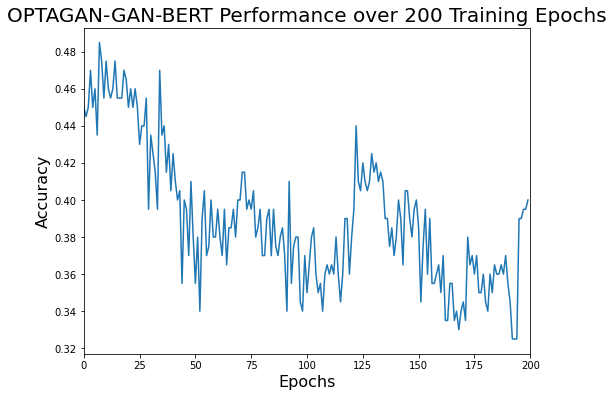

In [23]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_array)
plt.title('OPTAGAN-GAN-BERT Performance over 200 Training Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0,200)
plt.show

In [22]:
df_to_save = pd.DataFrame(accuracy_array)
df_to_save.to_csv('accuracy_array_optagan_yelp_nt_768_1.csv')

In [ ]:
#Generating Sentences
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse

import logging
import torch
import torch.nn as nn
import numpy as np

from modules.gan import Generator

import glob
import os
import pickle
import random

import torch.nn.functional as F
from tqdm import tqdm, trange

from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
from func import XLNetLMHeadModel, XLNetTokenizer
from func import TransfoXLLMHeadModel, TransfoXLTokenizer
from func import BertForLatentConnector, BertTokenizer

from collections import defaultdict
import pdb
from modules.utils import rollout_test

MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop

ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
    'gpt2v': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer)
}

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--new_sent', type=int, default=1, help="Number of sentences to generate")
    parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator")
    parser.add_argument('--block_dim', type=int, default=100)
    parser.add_argument('--interval', type=int, default=10)
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
    parser.add_argument('--generator_dir', default=None, type=str, required=True, help="Directory of GAN model checkpoint")
    parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
                        help="The directory where checkpoints are saved.")
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")
    parser.add_argument("--save", default=False, type=bool, help="Save results to file.")
    parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
    parser.add_argument("--output_name", default="results", type=str, help="File name of output")
    parser.add_argument("--batch_size", default=100, type=int, help="Batch size to generate outputs")
    ## Encoder options
    parser.add_argument("--encoder_model_type", default="bert", type=str,
                        help="The encoder model architecture to be fine-tuned.")
    parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The encoder model checkpoint for weights initialization.")
    parser.add_argument("--encoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--encoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    ## Decoder options
    parser.add_argument("--decoder_model_type", default="gpt2", type=str,
                        help="The decoder model architecture to be fine-tuned.")
    parser.add_argument("--decoder_model_name_or_path", default="gpt2", type=str,
                        help="The decoder model checkpoint for weights initialization.")
    parser.add_argument("--decoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--decoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    parser.add_argument("--max_seq_length", default=512, type=int,
                        help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")
    parser.add_argument("--finetune_decoder", default=False, type=bool,
                        help="Uses finetuned decoder in output dir if true.")

    ## Variational auto-encoder(check this)
    parser.add_argument("--top_k", type=int, default=0)
    parser.add_argument("--top_p", type=float, default=1.0)
    parser.add_argument("--prompt", type=str, default="")
    parser.add_argument("--padding_text", type=str, default="")
    parser.add_argument("--length", type=int, default=20)
    parser.add_argument("--block_size", default=-1, type=int,
                        help="Optional input sequence length after tokenization."
                             "The training dataset will be truncated in block of this size for training."
                             "Default to the model max input length for single sentence inputs (take into account special tokens).")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--use_philly", action='store_true',
                        help="Use Philly for computing.")
    parser.add_argument('--gloabl_step_eval', type=int, default=508523,
                        help="Evaluate the results at the given global step")

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    args = parser.parse_args("--checkpoint_dir=output_dir_yahoo_768_0 \
    --output_dir=output_dir_yahoo_768_0 \
    --generator_dir=output_dir_yahoo_768_0 \
    --block_size 100 \
    --max_seq_length 60 \
    --gloabl_step_eval 24000 \
    --latent_size 32 \
    --block_dim 100 \
    --new_sent 100 \
    --n_layers 10 \
    --top_p 0.9 \
    --output_name=results \
    --save True".split())
    global_step = args.gloabl_step_eval

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    args.device = torch.device("cuda" if args.cuda else "cpu")
    args.n_gpu = torch.cuda.device_count()
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)       
    
    args.encoder_model_type = args.encoder_model_type.lower()
    args.decoder_model_type = args.decoder_model_type.lower()

    output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
    output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
    if not args.finetune_decoder:
        output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
    else:
         output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
    checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
    model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

    model_encoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

    # Load a trained Decoder model and vocabulary that you have fine-tuned
    if not args.finetune_decoder:
        decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
    else:
        decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES["gpt2v"]
    model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
    model_decoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

    # Chunyuan: Add Padding token to GPT2
    special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
    num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
    logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
    model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
    assert tokenizer_decoder.pad_token == '<PAD>'
    
    generator = Generator(args.n_layers, args.block_dim, args.latent_size)

    if args.cuda:
        generator = generator.cuda()

    generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
    generator.eval()
    model_decoder.eval()
    model_encoder.eval()
    if args.save:
        if not os.path.exists(args.output_dir+"/{}.txt".format(args.output_name)):
            with open(args.output_dir+"/{}.txt".format(args.output_name), 'w'): 
                pass

    for i in range(int(args.new_sent/args.batch_size)):
        # sample noise
        noise = torch.Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_size))).to(args.device)
        new_z = generator(noise).data

        # create new sent
        sents = rollout_test(model_decoder, new_z, tokenizer_decoder, args.max_seq_length, args.batch_size, args.top_k, args.top_p)

        if args.save:
            with open(args.output_dir+"/{}.txt".format(args.output_name), 'a') as file:
                for i in sents:
                    file.write(i+"\n")
        else:
            for i in sents:
                logger.info(i)
